In [1]:
# Basic modules
import os
import glob
import pandas as pd
import numpy as np
import scipy.optimize as so
from scipy.integrate import quad
import astropy.units as u
import astropy.constants as c 
import math
import re
import csv


# Modules for MESA
import mesa_reader as mr
import mesaPlot as mp
import mkipp
from mesa_data import * 
import kipp_data


# Other useful modules
from collections import namedtuple
import time
import datetime
from pathlib import Path 
import fnmatch 
from file_read_backwards import FileReadBackwards as frb
# import latexify



# Modules for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
from matplotlib.patches import PathPatch
from matplotlib.patches import Patch
import matplotlib.cm as cm
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoLocator, AutoMinorLocator)
import matplotlib.dates as mdates
from matplotlib.transforms import Transform
from ipywidgets import FloatProgress
from IPython.display import display, clear_output
from matplotlib.colors import ListedColormap as cmap
from matplotlib.colors import BoundaryNorm as bn
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from labellines import labelLine, labelLines
from collections import OrderedDict


%matplotlib inline

In [2]:
linestyles_dict = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])

## Basic Config

In [3]:
# Where MESA is located
mesa_dir = '/Users/schanlar/Software/mesa-r15140/' 

# Where data is located
work_dir = '/Volumes/SavvasExternal'

series1_tams_work_dir = os.path.join(work_dir, 'aifa_models/he_tams')
carbon_free_work_dir = os.path.join(work_dir, 'aifa_models/carbon_free')

fiducial_models_prefix = os.path.join(work_dir, 'aifa_models/representatives')
fiducial_models_suffix = ['/0.8000_0.0001_0.0000',
                         '/1.4000_0.0010_0.0160',
                         '/1.8000_0.0200_0.0140',
                         '/2.5000_0.0200_0.0000',
                         '/3.1000_0.0001_0.0140'
                         ]

fiducial_models_work_dir = []
for i in fiducial_models_suffix:
    fiducial_models_work_dir.append(os.path.join(work_dir, fiducial_models_prefix)+i)



series2_prefix = 'zsol_eta'
series2_suffix = ['0p1', '0p25', '0p5', '0p8', '1p0', '1p58']


series2_work_dir = []
for i in series2_suffix:
    series2_work_dir.append(os.path.join(work_dir, series2_prefix)+i)
       
    
# Where to save results
plot_results_dir = '/Users/schanlar/Desktop/TNS_HeStars'

    
# Store original plot parameters so that we can revert:
ORIG_MATPLOTLIB_CONF = dict(matplotlib.rcParams)

def make_canvas(fig_width=None, fig_height=None, columns=2, fontsize=18, clear=False):
    
    assert(columns in [1,2])

    if fig_width is None:
        if columns == 1:
            fig_width = 14.0
        else:
            fig_width = 7.0

    if fig_height is None:
        golden_ratio = (np.sqrt(5.0) - 1.0) / 2.0    
        fig_height = fig_width * golden_ratio 



    params = {
        'font.family': 'sans-serif',
        'font.sans-serif' : ['Times New Roman'],
        'font.size' : fontsize,
        "figure.figsize":[fig_width, fig_height],
        'axes.labelsize' : fontsize,
        'axes.titlesize' : fontsize,
        'xtick.labelsize' : fontsize,
        'ytick.labelsize' : fontsize,
        'legend.fontsize' : fontsize,
        'axes.linewidth' : 1,
        'lines.linewidth' : 2.5,
        'savefig.dpi' : 300
    }
    plt.rcParams.update(params)
    
    ax = plt.gca()
    ax.tick_params(direction='in',length=8,top=True,right=True)
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        #tick.label1.set_fontweight('bold')
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        #tick.label1.set_fontweight('bold')
    plt.locator_params(nbins=14)
    
    if clear:
        plt.clf()
        
def revert_params():
    """
    Reverts any changes done to matplotlib parameters and restores
    the state before make_canvas was called
    """

    matplotlib.rcParams.update(ORIG_MATPLOTLIB_CONF)

In [4]:
# plt.style.use(['science', 'notebook'])
plt.style.use(['default'])

## Core boundaries

In [5]:
'''
@version: v.26.04.19
@description: https://github.com/schanlar/mesa_star_class
'''
# import numpy as np
# import math
# import mesa_reader as mr
# import os, re, glob, csv
# import logging
# import astropy.units as u
# import astropy.constants as c
# from functools import wraps
# import matplotlib.pyplot as plt
# from file_read_backwards import FileReadBackwards as frb



class MESA_STAR(object):


    # Paths to MESA stellar evolution code + output for plots
    mesa_dir = '/vol/aibn1107/data2/schanlar/mesa-r10398'
    plot_results_dir = '/users/schanlar/Desktop'



    # Main Constructor
    def __init__(self,
        mass: str,
        metallicity: str,
        overshooting: str,
        history_name = 'history',
        profile_number = 'final',
        **kwargs):

        '''
        The argument "profile_number" accepts either the number of a profile (e.g. 28, for profile28.data),
        or the word "final" as a default value which corresponds to the final profile (final_profile.data).

        If there is no file with such a name, you can use the "find_profile_number()"
        method, in order to find a specific profile.

        The absolute paths for the history file, and a given profile can be set using the kwargs "history_path",
        and "profile_path" respectively.
        '''

        # For internal use
        self._mesa = 'r10398'

        self.initial_mass = mass
        self.initial_metallicity = metallicity
        self.initial_overshooting = overshooting
        self.history_path = kwargs.get('history_path')
        self.profile_path = kwargs.get('profile_path')
        self.history_name = f'{history_name}.data'

        if not profile_number == 'final':
            self.profile_name = f'profile{profile_number}.data'
        else:
            self.profile_name = 'final_profile.data'


    # Output
    def __str__(self):
        return 'MESA_STAR[' + '\n' + \
            f'> Initial mass: {self.initial_mass} Msol' + '\n' + \
            f'> Initial metallicity: {self.initial_metallicity}'  + '\n' + \
            f'> Overshooting factor: {self.initial_overshooting}' + '\n' + \
            ']'


    # Destructor
    def __del__(self, verbatim = False):
        if verbatim:
            print('MESA_STAR Object has been destructed!')


    # CLASS METHODS
    # --------------------------------------------------------------------------

    # Second Constructor
    @classmethod # This decorator accounts for function overloading as in C++
    def from_string(cls,
        input_as_string: str,
        history_name = 'history',
        profile_number = 'final',
        **kwargs):

        '''
        This constructor builds a MESA_STAR object when the user passes the
        info for mass, metallicity, and overshooting as a string with format
        "mass_metallicity_overshooting".

        The function parses the string and continues by calling the class.
        All other relative variables (e.g. history_name, profile_path etc)
        can/should be inserted separately.
        '''

        mass, metallicity, overshooting = map(str, input_as_string.split('_'))

        history_path = kwargs.get('history_path')
        profile_path = kwargs.get('profile_path')

        star = cls(mass,
            metallicity,
            overshooting,
            history_name,
            profile_number,
            **kwargs)

        return star


    # MESA VERSION
    # --------------------------------------------------------------------------

    @property
    def mesa(self):
        return f'MESA VERSION: {self._mesa}'

    @mesa.setter
    def mesa(self, new_version: str):
        self._mesa = new_version


    # ACCESER METHODS (GETTERS)
    # --------------------------------------------------------------------------

    def getMass(self):
        '''
        Returns the initial mass of the star (type: str)
        '''
        return self.initial_mass

    def getMetallicity(self):
        '''
        Returns the initial metallicity of the star (type: str)
        '''
        return self.initial_metallicity

    def getOvershoot(self):
        '''
        Returns the overshooting factor of the star (type: str)
        '''
        return self.initial_overshooting

    def getHistory(self):
        '''
        This method exploits the mesa_reader module in order to load a MESA history file
        from a user-specified directory.

        It returns a <class 'mesa_reader.MesaData'> object.
        '''
        h = mr.MesaData(os.path.join(self.history_path, self.history_name))
        return h

    def getProfile(self):
        '''
        This method exploits the mesa_reader module in order to load a MESA profile file
        from a user-specified directory.

        It returns a <class 'mesa_reader.MesaData'> object.
        '''
        p = mr.MesaData(os.path.join(self.profile_path, self.profile_name))
        return p

    def getHistoryName(self):
        '''
        Returns the name of the MESA history file (type: str)
        '''
        return self.history_name

    def getProfileName(self):
        '''
        Returns the name of the MESA profile file (type: str)
        '''
        return self.profile_name

    def getHistoryPath(self):
        '''
        Returns the absolute path for the MESA history file (type: str)
        '''
        return self.history_path

    def getProfilePath(self):
        '''
        Returns the absolute path for the MESA profile file (type: str)
        '''
        return self.profile_path

    def getName(self):
        '''
        Returns the name of the star as a single string.
        Here as name we consider a string with the following
        format: mass_metallicity_overshooting
        '''
        a = [self.getMass(), self.getMetallicity(), self.getOvershoot()]
        self.name = '_'.join(a)
        return self.name

    def getChandraMass(self):
        '''
        Returns an estimation for the Chandrasekhar mass limit
        based on the electron fraction Y_e
        '''
        try:
            p = self.getProfile()
        except Exception as e:
            print('Something went wrong while trying to load the profile!')
            raise SystemExit(e)

        average_ye = round(np.mean(p.data('ye')), 3)
        chan_mass = round(5.836 * (average_ye ** 2), 3)
        return chan_mass

    def getCoreMass(self):
        '''
        Returns
            a float with the value of the initial star mass.
            a float with the value of the initial metallicity.
            a float with the value of the overshooting factor.
            a float with the value of the carbon core mass.
            a float with the value of the envelope mass.

        If MESA cannot distinguish between the carbon core mass,
        and the final mass of the star, then we define the outer
        boundary of the carbon core as the location where the
        degeneracy pressure is equal to the ideal gas pressure.

        If you're satisfied with this estimation, the function
        will return this value along with the initial mass,
        initial metallicity, overshooting factor, and envelope
        mass.

        It is also possible to set a new value for the core mass,
        ignoring the original approximation. In this case, a plot
        will appear every time you enter a new value for the core
        mass, in order to help visualize the mass cut.
        '''

        try:
            h = self.getHistory()

        except FileNotFoundError as e:
            print('Could not load history file! File not found!')
            raise SystemExit(e)

        except Exception as e:
            print('Something went wrong while trying to load the history file!')
            raise SystemExit(e)

        else:
            print('History file loaded succesfully!')

        finally:
            pass


        if h.data('star_mass')[-1] != h.data('c_core_mass')[-1] and not \
            math.isclose(h.data('c_core_mass')[-1], 0.0, abs_tol = 0.0):

            initial_mass = round(float(self.getMass()),1)
            initial_metallicity = float(self.getMetallicity())
            overshooting_factor = float(self.getOvershoot())

            final_core_mass = round(h.data('c_core_mass')[-1], 3)
            final_envelope_mass = round(h.data('star_mass')[-1] - h.data('c_core_mass')[-1], 3)

            return initial_mass, initial_metallicity, overshooting_factor, final_core_mass, final_envelope_mass

        # When the carbon core mass is equal to the total mass of the star, or
        # when -due to MESA core definition- the carbon core mass is evaluated
        # to zero, we need manual investigation
        elif h.data('star_mass')[-1] == h.data('c_core_mass')[-1] or \
            math.isclose(h.data('c_core_mass')[-1], 0.0, abs_tol = 0.0):

            try:
                p = self.getProfile()

            except FileNotFoundError as e:
                print('Failed to load profile! File not found!')
                raise SystemExit(e)

            except Exception as e:
                print('Something went wrong while trying to load the profile!')
                raise SystemExit(e)

            else:
                initial_mass = round(float(self.getMass()),1)
                initial_metallicity = float(self.getMetallicity())
                overshooting_factor = float(self.getOvershoot())


                logP = p.data("logP")
                logR = p.data("logR")

                # Degeneracy pressure
                Pdeg = 10 ** p.data("logP") - p.data("Pgas")
                P_ratio = p.data("Pgas") / Pdeg

                # Find the index where P_ratio is close to unity, i.e.
                # the location where the contribution in pressure from the ideal gas
                # can no longer be neglected
                foundCoreMassWithPratio = False
                for i in range(len(P_ratio)):
                    if math.isclose(P_ratio[i], 1.0, abs_tol=0.05):
                        core_boundary = p.data("mass")[i]
                        foundCoreMassWithPratio = True

                if foundCoreMassWithPratio:
                    print("Core mass estimated with Pratio")
                else:
                    mask = 0.80 * max(p.data("logP"))
                    core_boundary = p.data("mass")[np.where(logP < mask)][-1]
                    print("Core mass estimated with the pressure profile")

                print(f"Final core mass estimate: {round(core_boundary,3)} Msol")
                
                
                # Make a plot for visual aid
                make_canvas(fig_width=13, fig_height=9, clear=True)
                fig, ax1 = plt.subplots()

                color = 'tab:red'
                ax1.set_xlabel(r'Mass coordinate [M$_{\odot}$]')
                ax1.set_ylabel(r'$\logP$ [Ba]', color=color)
                ax1.plot(p.data('mass'), logP, color=color)
                ax1.tick_params(axis='y', labelcolor=color)

                ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

                color = 'tab:blue'
                ax2.set_ylabel(r'$\log R$ [R$_{\odot}$]', color=color)  # we already handled the x-label with ax1
                ax2.plot(p.data('mass'), logR, color=color)
                ax2.tick_params(axis='y', labelcolor=color)

                fig.tight_layout()

                plt.axvline(core_boundary, c = 'gray', linestyle = '--')
                plt.show()

                answer = input('Accept this estimation? (y/n) ')

                if answer == 'y' or answer == 'Y':
                    final_core_mass = round(core_boundary, 3)
                    final_envelope_mass = round(h.data('star_mass')[-1] - final_core_mass, 3)

                    return initial_mass, initial_metallicity, overshooting_factor, final_core_mass, final_envelope_mass

                else:
                    answer = input('Do you want to set a value for the core mass? (y/n) ')

                    if answer == 'y' or answer == 'Y':
                        tryAgain = True

                        while tryAgain:
                            core_boundary = float(input('set value: '))

                            # Make a plot for visual aid
                            make_canvas(fig_width=13, fig_height=9, clear=True)
                            fig, ax1 = plt.subplots()

                            color = 'tab:red'
                            ax1.set_xlabel(r'Mass coordinate [M$_{\odot}$]')
                            ax1.set_ylabel(r'$\logP$ [Ba]', color=color)
                            ax1.plot(p.data('mass'), logP, color=color)
                            ax1.tick_params(axis='y', labelcolor=color)

                            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

                            color = 'tab:blue'
                            ax2.set_ylabel(r'$\log R$ [R$_{\odot}$]', color=color)  # we already handled the x-label with ax1
                            ax2.plot(p.data('mass'), logR, color=color)
                            ax2.tick_params(axis='y', labelcolor=color)

                            fig.tight_layout()

                            plt.axvline(core_boundary, c = 'gray', linestyle = '--')
                            plt.show()

                            answer = input('Try again? (y/n) ')

                            if answer == 'n' or answer == 'N':
                                tryAgain = False
                            else:
                                tryAgain = True

                        final_core_mass = round(core_boundary, 3)
                        final_envelope_mass = round(h.data('star_mass')[-1] - final_core_mass, 3)

                        return initial_mass, initial_metallicity, overshooting_factor, final_core_mass, final_envelope_mass

                    else:
                        final_core_mass = float('nan')
                        final_envelope_mass = float('nan')

                        return initial_mass, initial_metallicity, overshooting_factor, final_core_mass, final_envelope_mass
                    
    # MUTATOR METHODS (SETTERS)
    # --------------------------------------------------------------------------

    def setMass(self, new_mass: str):
        '''
        Set a new value for the initial mass (type: str)
        '''
        self.initial_mass = new_mass

    def setMetallicity(self, new_metallicity: str):
        '''
        Set a new value for the initial metallicity (type: str)
        '''
        self.initial_metallicity = new_metallicity

    def setOvershoot(self, new_overshoot: str):
        '''
        Set a new value for the overshooting factor (type: str)
        '''
        self.initial_overshooting = new_overshoot

    def setHistoryName(self, new_name: str):
        '''
        Set a new value for the name of the history file (type: str)
        '''
        self.history_name = new_name

    def setProfileName(self, new_name: str):
        '''
        Set a new value for the name of the profile file (type: str)
        '''
        self.profile_name = new_name

    def setHistoryPath(self, new_path: str):
        '''
        Set a new value for the absolute path of the history file (type: str)
        '''
        self.history_path = new_path

    def setProfilePath(self, new_path: str):
        '''
        Set a new value for the absolute path of the profile file (type: str)
        '''
        self.profile_path = new_path
        

    # STATIC METHODS
    # --------------------------------------------------------------------------
    @staticmethod
    def name_is_valid(name_as_string):

        '''
        This static method checks if a given string is a valid name, and
        returning a boolean True or False.
        '''

        isValid = False

        try:
            mass, metallicity, overshooting = map(str, name_as_string.split('_'))

            if len(mass) == 6 and len(metallicity) == 6 and len(overshooting) == 6:
                try:
                    a = float(mass)
                    b = float(metallicity)
                    c = float(overshooting)

                    isValid = True
                    return isValid

                except:
                    print(f'The name {name_as_string} is not valid!')
                    return isValid

            else:
                print(f'The length of the name {name_as_string} is not valid!')
                return isValid

        except:
            print(f'The name {name_as_string} is not valid!')
            return isValid



    @staticmethod
    def export_csvFile(zip_object, name = 'csvData'):

        '''
        This static method takes a <zip object> as a mandatory argument,
        and creates a csv file of the data along with a single-row header.

        The header format follows the output of the <MESA_STAR.getCoreMass()>
        method.

        The default name of the output file is "csvData" and it can be changed
        using the optional  argument "name".
        '''

        # A simple header that follows the self.getCoreMass() method
        header = ['#initial_mass', 'initial_metallicity', 'overshooting_factor', 'core_mass', 'envelope_mass']

        # List that stores all data + header
        csvData = [header]

        # Unpack data
        for a,b,c,d,e in zip_object:

            data_row = [a,b,c,d,e]
            csvData.append(data_row)


        # Create csv file
        with open(f'{name}.csv', 'w') as csvFile:
            writer = csv.writer(csvFile)
            writer.writerows(csvData)

        csvFile.close()


    @staticmethod
    def find_profile_number(path: str, num = -1):
        '''
        Returns a string for the profile number.

        It takes a mandatory argument for the path where
        the profiles.index file is located.

        The optional argument "num" defines the number of row
        in the file.

        num < 0 means the script will start reading the
        profiles.index file bottop-up, and will stop at the
        specified row.

        Thus, num = -1 will return the last saved profile,
        num = -2 will return the second to last etc.

        num > 0 means the script will start reading the
        profiles.index file up-bottom, and will stop at the
        specified row.

        Thus, num = 1 will return the first saved profile
        within the profiles.index file.

        num = 0 will print the header info of the profiles.index
        file. In this case, the funtion does not return anything.
        '''

        counter = 0

        if num < 0:
            with frb(f'{path}/profiles.index') as file:

                for line in file:
                    counter -= 1

                    if counter == num:

                        info = re.split(' |, |\n', line)

                        # Try casting the profile number as integer
                        try:
                            info[-1] = int(info[-1])
                        except:
                            info[-1] = int(info[-2])

                        #print(f'The profile is: profile{info[-1]}.data')
                        return repr(info[-1])

                if abs(num) > counter:
                    raise ValueError('Number out of range!')

        elif num > 0:
            with open(f'{path}/profiles.index', 'r') as file:

                # Skip the first row
                next(file)

                for line in file:
                    counter += 1

                    if counter == num:

                        info = re.split(' |, |\n', line)

                        # Try casting the profile number as integer
                        try:
                            info[-1] = int(info[-1])
                        except:
                            info[-1] = int(info[-2])

                        #print(f'The profile is: profile{info[-1]}.data')
                        return repr(info[-1])

                if abs(num) > counter:
                    raise ValueError('Number out of range!')

        else:
            with open(f'{path}/profiles.index', 'r') as file:
                for line in file:
                    print(f'Header info: {line}')
                    break


    @staticmethod
    def find_termination_code(path_to_file: str):
        '''
        The function takes a single argument which is the path to the
        output file, e.g. condor.out, and returns the termination code
        for this model (if it exists).
        '''

        keyword = 'termination code: '
        line_number = 0

        with frb(path_to_file) as file:

            for line in file:
                line_number += 1

                if line.startswith(keyword) and line_number <= 50:

                    code = line.split(' ')

                    return code[-1]

                elif line_number > 50:
                    out = 'N/A'

                    return out

History file loaded succesfully!
0.8 0.0001 0.0 0.782 0.01
History file loaded succesfully!
1.4 0.001 0.016 1.234 0.0
History file loaded succesfully!
Core mass estimated with Pratio
Final core mass estimate: 1.361 Msol


<Figure size 1300x900 with 0 Axes>

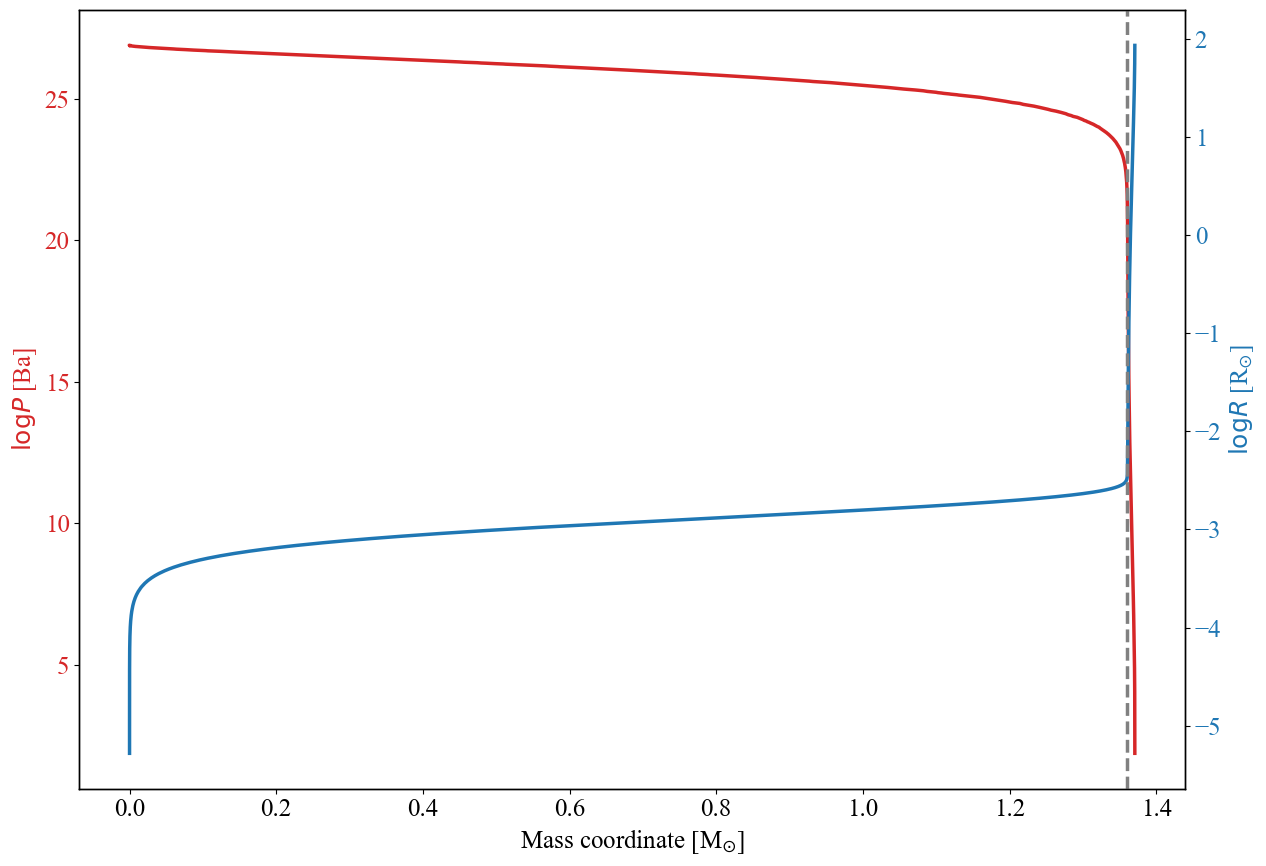

Accept this estimation? (y/n) y
1.8 0.02 0.014 1.361 0.01
History file loaded succesfully!
Core mass estimated with Pratio
Final core mass estimate: 1.363 Msol


<Figure size 1300x900 with 0 Axes>

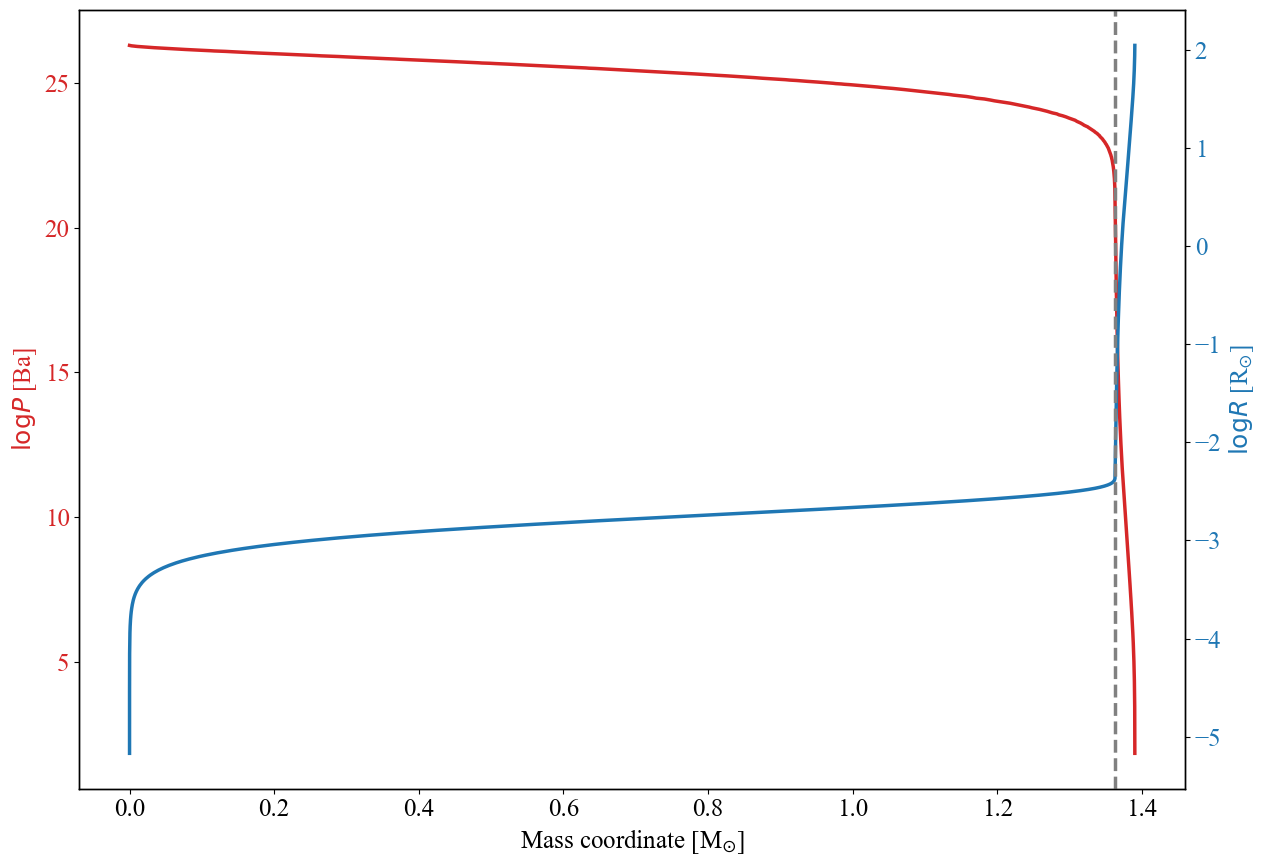

Accept this estimation? (y/n) y
2.5 0.02 0.0 1.363 0.027
History file loaded succesfully!
Core mass estimated with Pratio
Final core mass estimate: 1.446 Msol


<Figure size 1300x900 with 0 Axes>

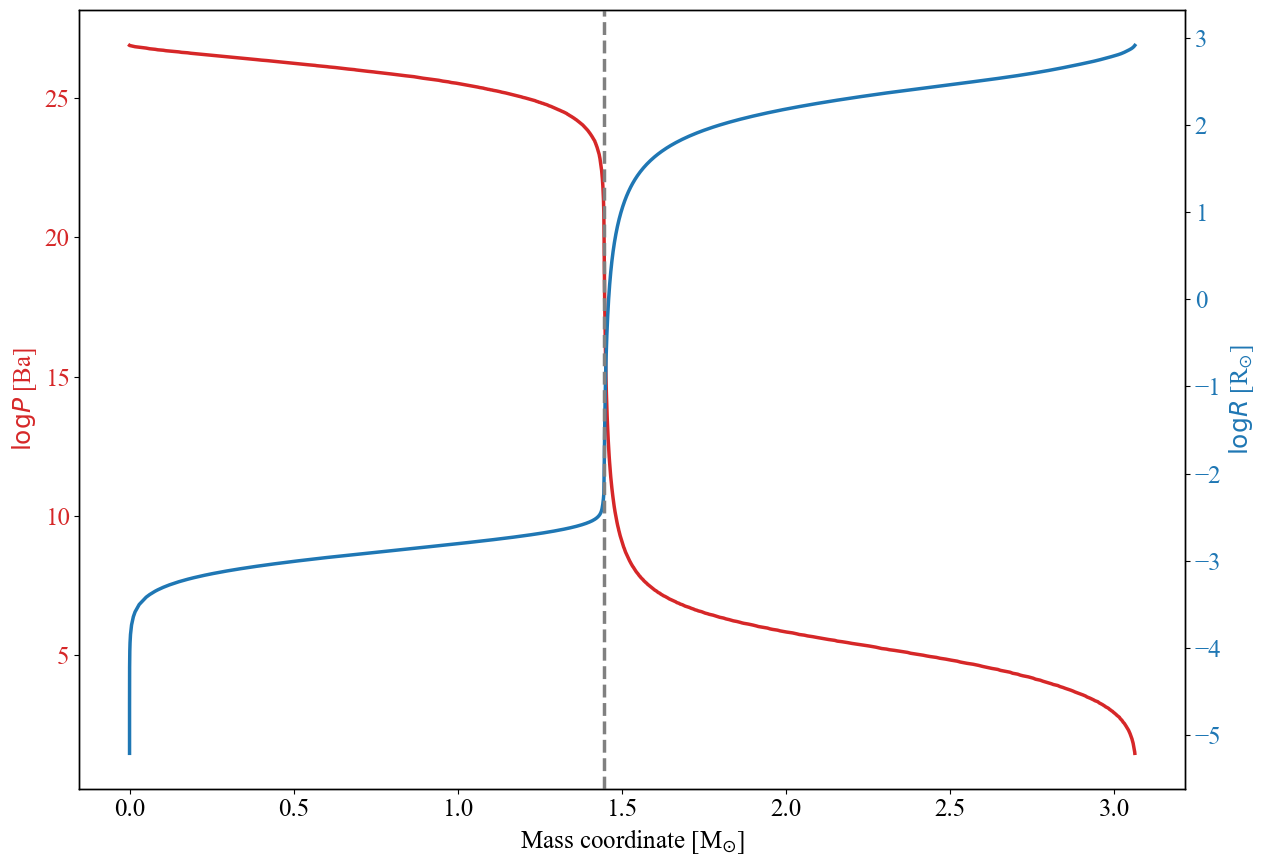

Accept this estimation? (y/n) y
3.1 0.0001 0.014 1.446 1.617


In [6]:
# Find final core and envelope masses
# for our fiducial models
# of Series I

for path in fiducial_models_work_dir:
    input_info = path.split('/')[-1]
    model_log_directory = os.path.join(path,'LOGS')

    if MESA_STAR.name_is_valid(input_info):
        try: 
            last_profile_num = MESA_STAR.find_profile_number(model_log_directory)
            stellar_model = MESA_STAR.from_string(input_info, 
                                                  history_path=model_log_directory, 
                                                  profile_path=model_log_directory,
                                                  profile_number=last_profile_num)
            
            a,b,c,d,e = stellar_model.getCoreMass()
            print(a,b,c,d,e)
        except Exception as e:
            print(e)
            continue

## Luminosity / Teff / Mass-loss / Radius vs Remaining time of evolution

In [7]:
def vink2001(logTeff,logL,mass,ZdivZsun):
    #print(ZdivZsun)
    temp = np.power(10,logTeff)
    LdivLsun = np.power(10,logL)
    if temp>27500:
        alfa = 1
    elif temp<22500:
        alfa = 0
    else:
        Teff_jump = 1e3*(61.2e0 + 2.59e0*(-13.636e0 + 0.889e0*np.log10(ZdivZsun)))
        dT = 100e0
        if (temp > Teff_jump + dT):
            alfa = 1
        elif (temp < Teff_jump - dT):
            alfa = 0
        else:
            alfa = (temp - (Teff_jump - dT)) / (2*dT)
    if (alfa > 0):
        vinf_div_vesc = 2.6
        vinf_div_vesc = vinf_div_vesc*np.power(ZdivZsun,0.13e0)
        logMdot = -6.697e0 + 2.194e0*np.log10(LdivLsun/1e5) - 1.313e0*np.log10(mass/30) - 1.226e0*np.log10(vinf_div_vesc/2e0) + 0.933e0*np.log10(temp/4e4) - 10.92e0*np.power(np.log10(temp/4e4),2) + 0.85e0*np.log10(ZdivZsun)
        w1 = np.power(10,logMdot)
    else:
        w1 = 0
    if (alfa < 1):
        vinf_div_vesc = 1.3e0
        vinf_div_vesc = vinf_div_vesc*np.power(ZdivZsun,0.13e0)
        logMdot = -6.688e0 + 2.210e0*np.log10(LdivLsun/1e5) - 1.339e0*np.log10(mass/30) - 1.601e0*np.log10(vinf_div_vesc/2e0) + 1.07e0*np.log10(temp/2e4)  + 0.85e0*np.log10(ZdivZsun)
        w2 = np.power(10,logMdot)
    else:
        w2 = 0
    w = alfa*w1 + (1 - alfa)*w2
    w = np.log10(w)
    return w


def nugislamers(logL,Y,Z):
    temp = np.power(10,logTeff)
    LdivLsun = np.power(10,logL)
    w = 1e-11 * np.power(LdivLsun,1.29e0) * np.power(Y,1.7e0) * np.sqrt(Z)
    w = np.log10(w)
    return w


def deJager(logL,logTeff):
    temp = np.power(10,logTeff)
    LdivLsun = np.power(10,logL)
    log10w = 1.769e0*np.log10(LdivLsun) - 1.676e0*np.log10(temp) - 8.158e0
    return log10w

In [8]:
history_path = os.path.join(fiducial_models_work_dir[3], 'history.data')
profile = mr.MesaData(history_path).data
max_age = max(profile("star_age"))
remaining_time_func = lambda x: np.log10(max(x)+0.01 - x)

<Figure size 1200x1400 with 0 Axes>

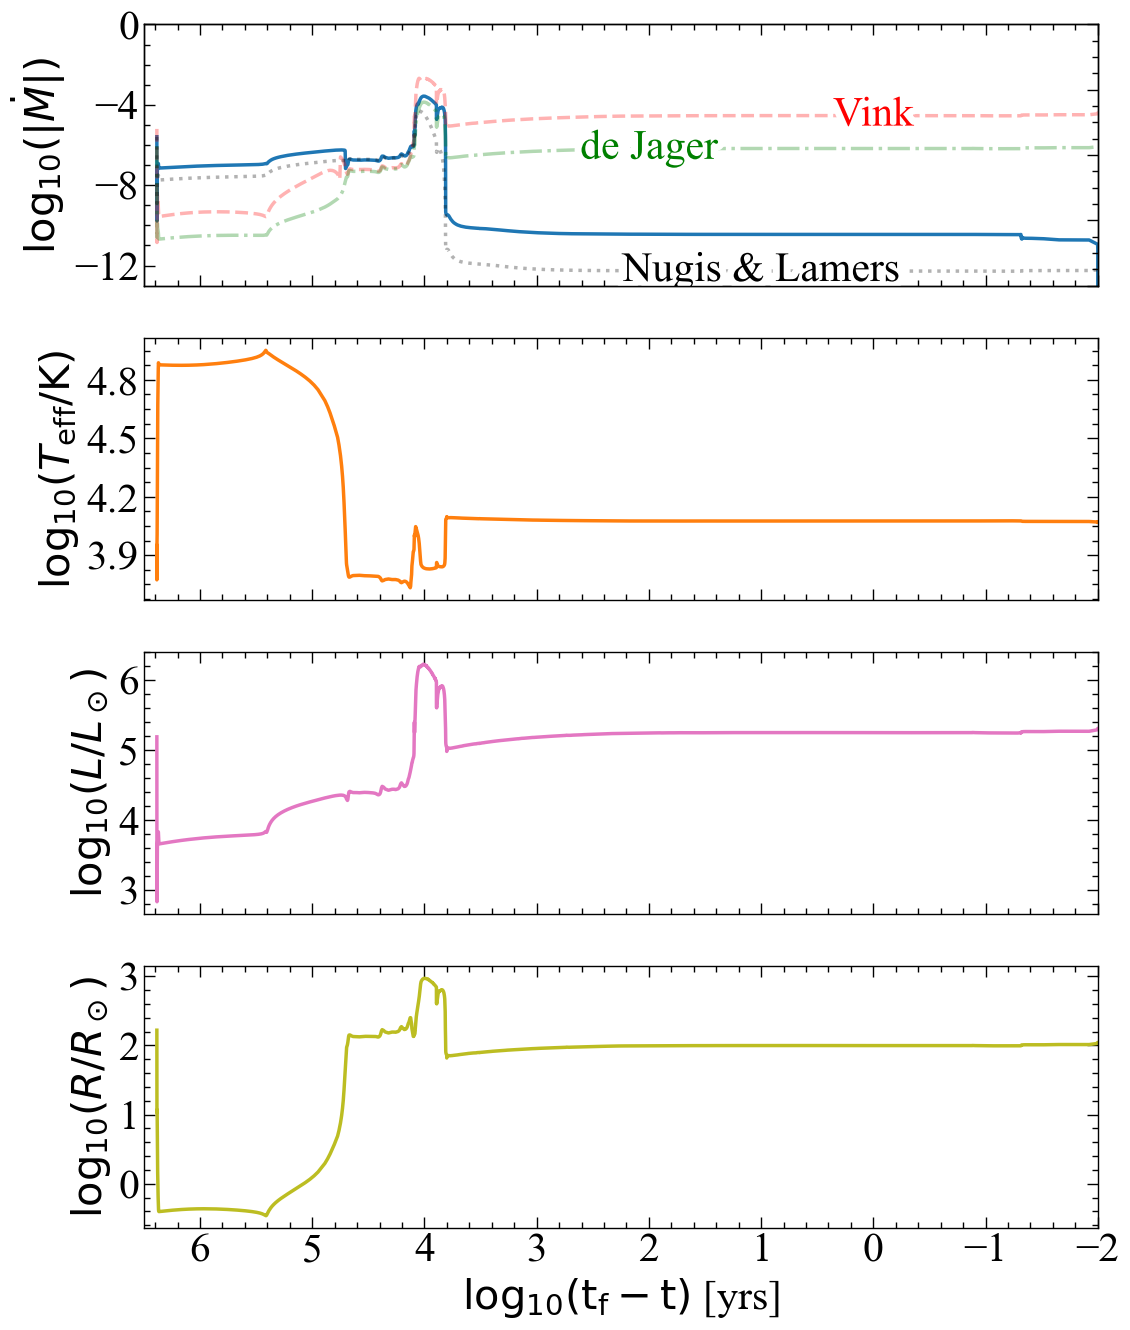

In [9]:
fontsize = 30
make_canvas(fig_width=12, fig_height=14, fontsize=fontsize, clear=True)


logTeff = profile('log_Teff')
log_L = profile('log_L')
mass = profile('star_mass')
surface_he4 = profile("surface_he4")
age = profile('star_age')

ZdivZsun = 0.02/0.014
vink = []
nugis = []
de_Jager = []

for i in range(0,len(mass)):
    a = vink2001(logTeff[i],log_L[i],mass[i],ZdivZsun)
    vink.append(a)
    b = nugislamers(log_L[i],surface_he4[i],0.02)
    nugis.append(b)
    c = deJager(log_L[i],logTeff[i])
    de_Jager.append(c)


fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, sharex=True)

ax0.set_ylabel(r'$\log_{10}(|\dot{M}|)$', color='k')
ax0.set_ylim([-13,0])
ax0.set_xlim([-2.0,6.5])
ax0.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax0.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax0.xaxis.set_major_locator(plt.MaxNLocator(10))
ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax0.yaxis.set_major_locator(plt.MaxNLocator(4))
ax0.yaxis.set_minor_locator(AutoMinorLocator())

ax0.plot(remaining_time_func(profile("star_age")), profile("log_abs_mdot"), color='tab:blue', linewidth=2.5, label=r'$\log(|\dot{M}|)$')




ax1.set_ylabel(r'$\log_{10}(T_{\rm eff} / \rm K)$', color='k')
ax1.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax1.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax1.plot(remaining_time_func(profile("star_age")), profile("log_Teff"),color='tab:orange', linewidth=2.5, label=r'$\log(T_{\rm eff})$')



ax2.set_ylabel(r'$\log_{10}(L/L_\odot)$', color='k')  
ax2.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax2.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax2.xaxis.set_major_locator(plt.MaxNLocator(10))
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
ax2.yaxis.set_minor_locator(AutoMinorLocator())

ax2.plot(remaining_time_func(profile("star_age")), profile("log_L"), color='tab:pink', linewidth=2.5, label=r'$\log(L)$')



ax3.set_xlabel(r"$\rm \log_{10} (t_f-t)$ [yrs]")
ax3.set_ylabel(r'$\log_{10}(R/R_\odot)$', color='k') 
ax3.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax3.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax3.xaxis.set_major_locator(plt.MaxNLocator(10))
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_major_locator(plt.MaxNLocator(4))
ax3.yaxis.set_minor_locator(AutoMinorLocator())

ax3.plot(remaining_time_func(profile("star_age")), profile("log_R"), color='tab:olive', linewidth=2.5, label=r'$\log(R)$')




ax4 = ax0.twinx()
ax4.set_yticklabels([])
ax4.set_ylim([-12,0])
ax4.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax4.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax4.xaxis.set_major_locator(plt.MaxNLocator(10))
ax4.xaxis.set_minor_locator(AutoMinorLocator())
ax4.yaxis.set_major_locator(plt.MaxNLocator(4))
ax4.yaxis.set_minor_locator(AutoMinorLocator())

ax4.plot(remaining_time_func(profile("star_age")),vink,c="red",alpha=0.3,linewidth=2.5, ls="--", label='Vink')
ax4.plot(remaining_time_func(profile("star_age")),de_Jager,c="green",alpha=0.3,linewidth=2.5, ls="-.", label='de Jager')
ax4.plot(remaining_time_func(profile("star_age")),nugis,c="k",alpha=0.3,linewidth=2.5, ls=':', label='Nugis & Lamers')

xvals = [0.0, 2.0, 1.0]
labelLines(ax4.get_lines(), drop_label=True, outline_width=10, xvals=xvals) 



ax0.invert_xaxis()


fig.tight_layout() 
# fig.legend(loc='upper center', bbox_to_anchor=(0.54, 1.1),
#           ncol=4, fancybox=True, shadow=False, prop={'size':18})

# plt.savefig(os.path.join(plot_results_dir, 'envelope_evolution_grid.pdf'), dpi=300, bbox_inches='tight')

## He-MS vs Initial Mass

In [2]:
def power_law(x,a,k,c):
    """A simple power-law 
       to fit data
    """
    return a * (x**k) + c

In [10]:
mass_zlow_fov0, mass_zlow_fov1, mass_zlow_fov2 = [], [], []
tams_zlow_fov0, tams_zlow_fov1, tams_zlow_fov2 = [], [], []

mass_zim_fov0, mass_zim_fov1, mass_zim_fov2 = [], [], []
tams_zim_fov0, tams_zim_fov1, tams_zim_fov2 = [], [], []

mass_zsol_fov0, mass_zsol_fov1, mass_zsol_fov2 = [], [], []
tams_zsol_fov0, tams_zsol_fov1, tams_zsol_fov2 = [], [], []


sorted_paths = []
for i in glob.glob(series1_tams_work_dir+'/*'):

    sorted_paths.append(i)


sorted_paths = sorted(sorted_paths)

for model_path in sorted_paths:

    mass_str = model_path.split('/')[-1].split('_')[0]
    z_str = model_path.split('/')[-1].split('_')[1]
    fov_str = model_path.split('/')[-1].split('_')[2]

    # print(mass_str, z_str, fov_str)

    try:

        h = mr.MesaData(os.path.join(model_path, 'history.data'))

    except Exception as e:

        print('Problem with: ', model_path)
        print(e)

    if z_str == '0.0001' and fov_str == '0.0000':
        mass_zlow_fov0.append(h.data('star_mass')[0])
        tams_zlow_fov0.append(h.data('star_age')[-1] / (10**6))

    elif z_str == '0.0001' and fov_str == '0.0140':
        mass_zlow_fov1.append(h.data('star_mass')[0])
        tams_zlow_fov1.append(h.data('star_age')[-1] / (10**6))

    elif z_str == '0.0001' and fov_str == '0.0160':
        mass_zlow_fov2.append(h.data('star_mass')[0])
        tams_zlow_fov2.append(h.data('star_age')[-1] / (10**6))

    elif z_str == '0.0010' and fov_str == '0.0000':
        mass_zim_fov0.append(h.data('star_mass')[0])
        tams_zim_fov0.append(h.data('star_age')[-1] / (10**6))

    elif z_str == '0.0010' and fov_str == '0.0140':
        mass_zim_fov1.append(h.data('star_mass')[0])
        tams_zim_fov1.append(h.data('star_age')[-1] / (10**6))

    elif z_str == '0.0010' and fov_str == '0.0160':
        mass_zim_fov2.append(h.data('star_mass')[0])
        tams_zim_fov2.append(h.data('star_age')[-1] / (10**6))

    elif z_str == '0.0200' and fov_str == '0.0000':
        mass_zsol_fov0.append(h.data('star_mass')[0])
        tams_zsol_fov0.append(h.data('star_age')[-1] / (10**6))

    elif z_str == '0.0200' and fov_str == '0.0140':
        mass_zsol_fov1.append(h.data('star_mass')[0])
        tams_zsol_fov1.append(h.data('star_age')[-1] / (10**6))

    elif z_str == '0.0200' and fov_str == '0.0160':
        mass_zsol_fov2.append(h.data('star_mass')[0])
        tams_zsol_fov2.append(h.data('star_age')[-1] / (10**6))

    else:
        print('Something went wrong with: ', model_path)

<Figure size 700x432.624 with 0 Axes>

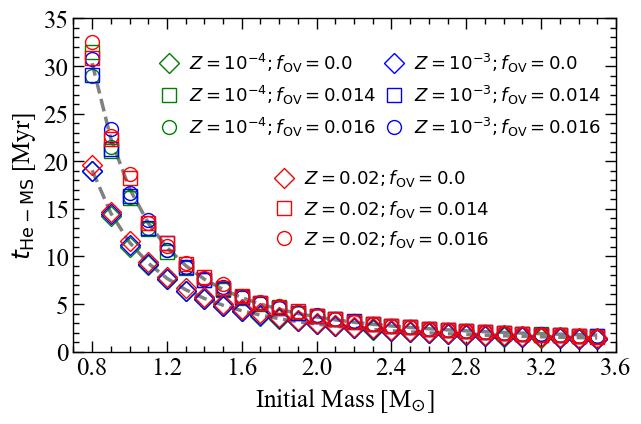

In [11]:
s=10
make_canvas(clear=True)


fig, ax = plt.subplots()
ax.set_xlabel(r'Initial Mass [M$_{\odot}$]')
ax.set_ylabel(r'$t_{\rm He-MS}$ [Myr]')

ax.set_xlim(0.7, 3.6)
ax.set_ylim(0.0, 35.0)

ax.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_major_locator(plt.MaxNLocator(8))
ax.yaxis.set_minor_locator(AutoMinorLocator())


# Average values from individual fittings
y_fit_fov0 = [power_law(i, 10.538, -2.43, 0.931) for i in mass_zim_fov0]
y_fit_fov2 = [power_law(j, 15.93, -2.702, 1.193) for j in mass_zim_fov2]

plt.plot(mass_zim_fov0, y_fit_fov0, c='grey', ls='--', lw=2.5)
plt.plot(mass_zim_fov2, y_fit_fov2, c='grey', ls='--', lw=2.5)



plot_lines = []
# ax.plot(mass_zlow_fov0, tams_zlow_fov0, s=s, marker = 'D', facecolors='none', edgecolors='g', ls='')
l1, = ax.plot(mass_zlow_fov0, tams_zlow_fov0, marker='D', fillstyle='none', markeredgecolor='g', markersize = s, ls='')
# popt, pcov = so.curve_fit(power_law, mass_zlow_fov0, tams_zlow_fov0)
# print(popt)
# plt.plot(mass_zlow_fov0, power_law(mass_zlow_fov0, *popt), ls='--')



l2, = ax.plot(mass_zlow_fov1, tams_zlow_fov1, marker='s', fillstyle='none', markeredgecolor='g', markersize = s,  ls='')
# popt, pcov = so.curve_fit(power_law, mass_zlow_fov1, tams_zlow_fov1)
# print(popt)
# plt.plot(mass_zlow_fov1, power_law(mass_zlow_fov1, *popt), ls='--')



l3, = ax.plot(mass_zlow_fov2, tams_zlow_fov2, marker='o', fillstyle='none', markeredgecolor='g', markersize = s,  ls='')
# popt, pcov = so.curve_fit(power_law, mass_zlow_fov2, tams_zlow_fov2)
# print(popt)
# plt.plot(mass_zlow_fov2, power_law(mass_zlow_fov2, *popt), ls='--')

plot_lines.append([l1,l2,l3])

ax.legend(plot_lines[0], [r'$Z=10^{-4};f_{\rm OV} = 0.0$', r'$Z=10^{-4};f_{\rm OV} = 0.014$', r'$Z=10^{-4};f_{\rm OV} = 0.016$'],
          loc='upper center', frameon=False, bbox_to_anchor=(0.35, 0.95), handletextpad=0.1, prop={'size':13})




l1, = ax.plot(mass_zim_fov0, tams_zim_fov0, marker='D', fillstyle='none', markeredgecolor='b', markersize = s, ls='')
# popt, pcov = so.curve_fit(power_law, mass_zim_fov0, tams_zim_fov0)
# print(popt)
# plt.plot(mass_zim_fov0, power_law(mass_zim_fov0, *popt), ls='--')



l2, = ax.plot(mass_zim_fov1, tams_zim_fov1, marker='s', fillstyle='none', markeredgecolor='b', markersize = s, ls='')
# popt, pcov = so.curve_fit(power_law, mass_zim_fov1, tams_zim_fov1)
# print(popt)
# plt.plot(mass_zim_fov1, power_law(mass_zim_fov1, *popt), ls='--')



l3, = ax.plot(mass_zim_fov2, tams_zim_fov2, marker='o', fillstyle='none', markeredgecolor='b', markersize = s, ls='')
# popt, pcov = so.curve_fit(power_law, mass_zim_fov2, tams_zim_fov2)
# print(popt)
# plt.plot(mass_zim_fov2, power_law(mass_zim_fov2, *popt), ls='--')

plot_lines.append([l1,l2,l3])

leg2 = Legend(ax, plot_lines[1], [r'$Z=10^{-3};f_{\rm OV} = 0.0$', r'$Z=10^{-3};f_{\rm OV} = 0.014$', r'$Z=10^{-3};f_{\rm OV} = 0.016$'],
             loc='upper center', frameon=False, bbox_to_anchor=(0.765, 0.95), handletextpad=0.1, prop={'size':13})
ax.add_artist(leg2)




l1, = ax.plot(mass_zsol_fov0, tams_zsol_fov0, marker='D', fillstyle='none', markeredgecolor='r', markersize = s, ls='')
# popt, pcov = so.curve_fit(power_law, mass_zsol_fov0, tams_zsol_fov0)
# print(popt)
# plt.plot(mass_zsol_fov0, power_law(mass_zsol_fov0, *popt), ls='--')


l2, = ax.plot(mass_zsol_fov1, tams_zsol_fov1, marker='s', fillstyle='none', markeredgecolor='r', markersize = s, ls='')
# popt, pcov = so.curve_fit(power_law, mass_zsol_fov1, tams_zsol_fov1)
# print(popt)
# plt.plot(mass_zsol_fov1, power_law(mass_zsol_fov1, *popt), ls='--')


l3, = ax.plot(mass_zsol_fov2, tams_zsol_fov2, marker='o', fillstyle='none', markeredgecolor='r', markersize = s, ls='')
# popt, pcov = so.curve_fit(power_law, mass_zsol_fov2, tams_zsol_fov2)
# print(popt)
# plt.plot(mass_zsol_fov2, power_law(mass_zsol_fov2, *popt), ls='--')

plot_lines.append([l1,l2,l3])

leg3 = Legend(ax, plot_lines[2], [r'$Z=0.02;f_{\rm OV} = 0.0$', r'$Z=0.02;f_{\rm OV} = 0.014$', r'$Z=0.02;f_{\rm OV} = 0.016$'],
             loc='upper center', frameon=False, bbox_to_anchor=(0.56, 0.6), handletextpad=0.1, prop={'size':13})
ax.add_artist(leg3)



# plt.savefig(os.path.join(plot_results_dir, 'hetams_vs_mass.pdf'), dpi=300, bbox_inches='tight')

## Hertzprung-Russel Diagrams

In [12]:
from astropy.constants import sigma_sb, R_sun, L_sun

def f(R, T):
    """Stefan-Boltzmann law"""
    
    L = 4*np.pi * (R * R_sun.value)**2 * sigma_sb.value * (T**4)
    return L/L_sun.value



teff = np.linspace(2500, 10000000)
lums = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
rad_labels = [r'$\rm 10^{-6}\,R_\odot$',
              r'$\rm 10^{-5}\,R_\odot$',
              r'$\rm 10^{-4}\,R_\odot$',
              r'$\rm 10^{-3}\,R_\odot$',
              r'$\rm 0.01\,R_\odot$',
              r'$\rm 0.1\,R_\odot$',
              r'$\rm 1.0\,R_\odot$',
              r'$\rm 10\,R_\odot$',
              r'$\rm 100\,R_\odot$',
              r'$\rm 10^3\,R_\odot$',
              r'$\rm 10^4\,R_\odot$'
    
]


# LOAD DATA
histories_paths = []
for path in fiducial_models_work_dir:
    histories_paths.append(os.path.join(path, 'LOGS/history.data'))
    
labels = [r'0.8 M$_{\odot}$; $Z=10^{-4}$; $f_{\rm OV}=0.0$',
          r'1.4 M$_{\odot}$; $Z=10^{-3}$; $f_{\rm OV}=0.016$',
          r'1.8 M$_{\odot}$; $Z=0.02$; $f_{\rm OV}=0.014$',
          r'2.5 M$_{\odot}$; $Z=0.02$; $f_{\rm OV}=0.0$',
          r'3.1 M$_{\odot}$; $Z=10^{-4}$; $f_{\rm OV}=0.014$'
         ]
colors = ['brown', 'green', 'magenta', 'blue', 'red']

<Figure size 700x432.624 with 0 Axes>

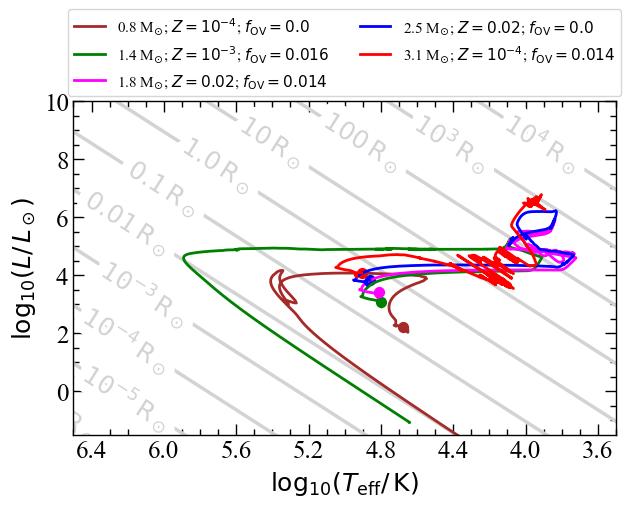

In [13]:
s1 = 0
s2 = 750
make_canvas(clear=True)


fig, ax = plt.subplots()
ax.set_xlabel(r'$\log_{10} (T_{\rm eff} / \,\rm K)$')
ax.set_ylabel(r'$\log_{10} (L / \,L_\odot)$')

ax.set_xlim(6.5, 3.5)
ax.set_ylim(-1.5, 10.0)

ax.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_minor_locator(AutoMinorLocator())



# PLOT RADII   
for idx, lum in enumerate(lums):
    L = [f(lum, i) for i in teff]
    ax.plot(np.log10(teff), np.log10(L), c = 'lightgrey', label=rad_labels[idx])
    
xvals = [6.6, 6.2, 6.2, 6.1, 6.2, 6.0, 5.7, 5.4, 4.9, 4.4, 3.9 ] 
labelLines(ax.get_lines(), drop_label=True, outline_width=15, xvals=xvals) 



# PLOT DATA
for idx, history in enumerate(histories_paths):
    h = mr.MesaData(history)
    he = h.data('log_LHe')
    filt = np.where(he > 1)
    filt = filt[0][0]

    plt.plot(h.data('log_Teff')[filt:], h.data('log_L')[filt:], c = colors[idx], lw=2, label = labels[idx])
    
    # Start of core He burning
    ax.scatter(h.data('log_Teff')[filt], h.data('log_L')[filt], c=colors[idx], marker='o', s=50)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
           ncol=2, fancybox=True, shadow=False, prop={'size':11})
    if idx == 2:
        plt.scatter(h.data('log_Teff')[-1], h.data('log_L')[-1], c='magenta', marker='*', s=s1)
    if idx == 3:
        plt.scatter(h.data('log_Teff')[-1], h.data('log_L')[-1], c='blue', marker='*', s=s1)
    if idx == 4:
        plt.scatter(h.data('log_Teff')[-1], h.data('log_L')[-1], c='red', marker='*', s=s1)



plt.gca().invert_xaxis()
ax.invert_xaxis()


# plt.savefig(os.path.join(plot_results_dir, 'hrd_series1.pdf'), dpi=300, bbox_inches='tight')

<Figure size 700x432.624 with 0 Axes>

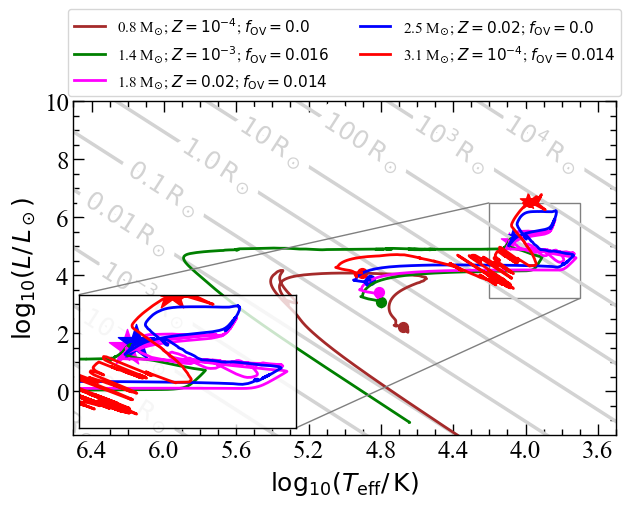

In [14]:
s1 = 150
s2 = 750
make_canvas(clear=True)


fig, ax = plt.subplots()
ax.set_xlabel(r'$\log_{10} (T_{\rm eff} / \,\rm K)$')
ax.set_ylabel(r'$\log_{10} (L / \,L_\odot)$')

ax.set_xlim(6.5, 3.5)
ax.set_ylim(-1.5, 10.0)

ax.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_minor_locator(AutoMinorLocator())



# PLOT RADII   
for idx, lum in enumerate(lums):
    L = [f(lum, i) for i in teff]
    ax.plot(np.log10(teff), np.log10(L), c = 'lightgrey', label=rad_labels[idx])
    
# xvals = [6.9, 6.8, 6.6, 6.5, 6.3, 6.0, 5.6, 5.2, 4.8, 4.4, 3.9 ]    
xvals = [6.6, 6.2, 6.2, 6.1, 6.2, 6.0, 5.7, 5.4, 4.9, 4.4, 3.9 ] 
labelLines(ax.get_lines(), drop_label=True, outline_width=15, xvals=xvals) 



# PLOT DATA
axins = ax.inset_axes([0.01, 0.02, 0.4, 0.4])
for idx, history in enumerate(histories_paths):
    h = mr.MesaData(history)
    he = h.data('log_LHe')
    filt = np.where(he > 1)
    filt = filt[0][0]

    plt.plot(h.data('log_Teff')[filt:], h.data('log_L')[filt:], c = colors[idx], lw=2, label = labels[idx])
    
    # Start of core He burning
    ax.scatter(h.data('log_Teff')[filt], h.data('log_L')[filt], c=colors[idx], marker='o', s=50)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
           ncol=2, fancybox=True, shadow=False, prop={'size':11})
    if idx == 2:
        plt.scatter(h.data('log_Teff')[-1], h.data('log_L')[-1], c='magenta', marker='*', s=s1)
        axins.scatter(h.data('log_Teff')[-1], h.data('log_L')[-1], c='magenta', marker='*', s=s2)
    if idx == 3:
        plt.scatter(h.data('log_Teff')[-1], h.data('log_L')[-1], c='blue', marker='*', s=s1)
        axins.scatter(h.data('log_Teff')[-1], h.data('log_L')[-1], c='blue', marker='*', s=s2)
    if idx == 4:
        plt.scatter(h.data('log_Teff')[-1], h.data('log_L')[-1], c='red', marker='*', s=s1)
        axins.scatter(h.data('log_Teff')[-1], h.data('log_L')[-1], c='red', marker='*', s=s2)
    
    axins.plot(h.data('log_Teff')[filt:], h.data('log_L')[filt:], c = colors[idx], lw=2)
    axins.patch.set_alpha(0.8)
    

    
# sub region of the original image
x1, x2, y1, y2 = 4.2, 3.7, 3.2, 6.5
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=False, right=False, colors='white')
axins.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=False, right=False, colors='white')

patch, pp1,pp2 = mark_inset(ax, axins, loc1=1, loc2=1, fc="none", ec="0.5")
pp1.loc1 = 2
pp1.loc2 = 1
pp2.loc1 = 4
pp2.loc2 = 3


plt.gca().invert_xaxis()
ax.invert_xaxis()


# plt.savefig(os.path.join(plot_results_dir, 'hrd_series1_inset.pdf'), dpi=300, bbox_inches='tight')

## Density - Temperature History Plot

In [15]:
import astropy.constants as c 

def find(pattern,path):
    result = []
    for root,dirs,files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name,pattern):
                result.append(os.path.join(root,name))
    return result

    
def capture_density(t,rho_0,Q,t_comp,ft):
    rho = rho_0/(1 + (3*c.k_B*t/Q)* np.log(2*np.log(2)*(c.k_B*t/(c.m_e*c.c**2))**5 * (Q/(c.k_B*t))**2 * (t_comp/ft)))
    return rho 

def nse_boundary(rho,T,s=1.0):
    rho = 10**rho
    T = (10**T)/1e9
    logrho = -(np.log10(np.exp(179./T - 40.5))-np.log10(s))/0.2
    return logrho
    
def logrhoc_logTc(data,
                  labels,
                  mesa_dir = mesa_dir, 
                  fontsize = 18,
                  colors=None,
                  lstyle=None,
                  xlim=None,
                  ylim=None,
                  ecap_density_corrections=False,
                  t_comp=1e4*u.yr):
    
    
#     hydrogen_burning_line = os.path.join(mesa_dir,'data/star_data/plot_info/hydrogen_burn.data')
#     helium_burning_line = os.path.join(mesa_dir,'data/star_data/plot_info/helium_burn.data')
#     carbon_burning_line = os.path.join(mesa_dir,'data/star_data/plot_info/carbon_burn.data')
#     oxygen_burning_line = os.path.join(mesa_dir,'data/star_data/plot_info/oxygen_burn.data')
#     electron_degeneracy_line = os.path.join(mesa_dir,'data/star_data/plot_info/psi4.data')

    helium_burning_line = os.path.join('/Users/schanlar/Desktop','helium_burn.data')
    carbon_burning_line = os.path.join('/Users/schanlar/Desktop','carbon_burn.data')
    oxygen_burning_line = os.path.join('/Users/schanlar/Desktop','oxygen_burn.data')
    electron_degeneracy_line = os.path.join('/Users/schanlar/Desktop','psi4.data')
    
    
    # hburn = np.genfromtxt(hydrogen_burning_line)
    heburn = np.genfromtxt(helium_burning_line)
    cburn = np.genfromtxt(carbon_burning_line)
    oburn = np.genfromtxt(oxygen_burning_line)
    electron = np.genfromtxt(electron_degeneracy_line)

    # Radiation pressure line 
    logrho = np.arange(-9.0,10.0,0.1)
    logt = np.log10(3.2e7) + (logrho - np.log10(0.7))/3.0
    
    rhonse = nse_boundary(logrho,logt,s=1)
    plt.plot(rhonse,logt,ls=':',color='black')
    plt.text(5.25, 9.7, 'NSE', fontsize=fontsize,
               rotation=0, rotation_mode='anchor') 


    plt.plot(heburn[:,0],heburn[:,1],ls=':',color='black')
    plt.text(5.1, 7.95, 'He burn', fontsize=fontsize,
               rotation=0, rotation_mode='anchor')


    plt.plot(cburn[:,0],cburn[:,1],ls=':',color='black')
    plt.text(5.1, 8.67, 'C burn', fontsize=fontsize,
               rotation=0, rotation_mode='anchor')


    plt.plot(oburn[:,0],oburn[:,1],ls=':',color='black')
    plt.text(5.1, 9.05, 'O burn', fontsize=fontsize,
               rotation=0, rotation_mode='anchor')

    plt.plot(electron[:,0],electron[:,1],ls='--',color='black')

    plt.plot(logrho,logt,ls='--',color='black')
    plt.text(6.98, 9.5, r'$\epsilon_{\rm F}/k T \simeq 4$', fontsize=fontsize, rotation=0, rotation_mode='anchor')
    
    plt.text(5.25, 9.5, r'$P_{\rm rad}\simeq P_{\rm gas}$', fontsize=fontsize, rotation=0, rotation_mode='anchor')
    

    # Weak reaction lines 
    plt.text(9.05, 7.87, r'$^{25}{\rm Mg}\leftrightarrow ^{25}{\rm Na}$', fontsize=fontsize, rotation=90,verticalalignment='bottom')
    plt.text(9.25, 7.87, r'$^{23}{\rm Na} \leftrightarrow ^{23}{\rm Ne}$', fontsize=fontsize, rotation=90,verticalalignment='bottom')
    plt.text(9.65, 7.87, r'$^{24}{\rm Mg}\rightarrow ^{24}{\rm Na}$', fontsize=fontsize, rotation=90,verticalalignment='bottom')
    plt.text(9.75, 7.87, r'$^{24}{\rm Na}\rightarrow ^{24}{\rm Ne}$', fontsize=fontsize, rotation=90,verticalalignment='bottom')
    plt.text(9.85, 7.87, r'$^{25}{\rm Na}\leftrightarrow ^{25}{\rm Ne}$', fontsize=fontsize, rotation=90,verticalalignment='bottom')
    plt.text(10.00, 7.87, r'$^{20}{\rm Ne}\rightarrow ^{20}{\rm F}\rightarrow  ^{20}{\rm O}$', fontsize=fontsize, rotation=90,color='black',verticalalignment='bottom')
    
    
    if ecap_density_corrections:
        t = np.arange(7.5,11,0.1)
        t = 10**t * u.K
        rho_ce = capture_density(t,10**9.96,7.025*u.MeV,t_comp,10**9.801*u.s)
        plt.fill_between(np.log10(rho_ce),np.log10(t.value),np.max(np.log10(t.value)), facecolor="none", hatch="....", edgecolor="gray", linewidth=0.0)
        plt.fill_between([9.96,13],0,15,facecolor="none", hatch="....", edgecolor="gray", linewidth=0.0)
        
        plt.text(10.22, 8.6, r'ECSNe', 
                {'color': 'black', 'ha': 'center', 'va': 'center','fontsize': fontsize,'bbox': dict(boxstyle="round", fc="w", ec="k", pad=0.2)})
        
    else:
        #plt.axvline(x=9.96,color='gray',ls='--')
        plt.fill_between([9.96,13],0,15,facecolor="none", hatch="....", edgecolor="gray", linewidth=0.0)
        
        plt.text(10.2, 9.05, r'ECSNe', 
                {'color': 'black', 'ha': 'center', 'va': 'center','fontsize': fontsize,'bbox': dict(boxstyle="round", fc="w", ec="k", pad=0.2)})
    
   # now loop over data 
    for i in range(len(data)):
        d = data[i]
        if lstyle !=None:
            ls = lstyle[i]
        else:
            ls = '-'
        if colors !=None:
            color = colors[i]
        else:
            color=np.random.rand(3,1)
        if i==4: #2
            #pass
            plt.plot(d('log_center_Rho')[:],d('log_center_T')[:],label=labels[i],color=color,ls=ls, linewidth=2.5)
        else:
            plt.plot(d('log_center_Rho'),d('log_center_T'),label=labels[i],color=color,ls=ls, linewidth=2.5)
        
    
    # frame & labels 
    xlabel = r'$\log_{10} (\rho_{\rm c} / {\rm g}\,{\rm cm}^{-3})$'
    ylabel = r'$\log_{10} (T_{\rm c} / {\rm K})$'
    plt.xlabel(xlabel,fontsize=fontsize)
    plt.ylabel(ylabel,fontsize=fontsize) 
    
    if xlim:
        plt.xlim(xlim)
    else:
        plt.xlim([5,10.5])
    if ylim:
        plt.ylim(ylim)
    else:
        plt.ylim([7.5,10.0])

In [16]:
data = [
        mr.MesaData(os.path.join(fiducial_models_work_dir[0], 'LOGS/history.data')).data,
        mr.MesaData(os.path.join(fiducial_models_work_dir[1], 'LOGS/history.data')).data,
        mr.MesaData(os.path.join(fiducial_models_work_dir[2], 'LOGS/history.data')).data,
        mr.MesaData(os.path.join(fiducial_models_work_dir[3], 'LOGS/history.data')).data,
        mr.MesaData(os.path.join(carbon_free_work_dir, '2.5000_0.0200_0.0000/LOGS/history.data')).data,
        mr.MesaData(os.path.join(fiducial_models_work_dir[4], 'LOGS/history.data')).data
    ]
        
labels = [
          r'0.8 M$_{\odot}$; $Z=0.0001$; $f_{\rm OV}=0.0$',
          r'1.4 M$_{\odot}$; $Z=0.001$;$f_{\rm OV}=0.016$',
          r'1.8 M$_{\odot}$; $Z=0.02$; $f_{\rm OV}=0.014$',
          r'2.5 M$_{\odot}$; $Z=0.02$; $f_{\rm OV}=0.0$',
          r'2.5 M$_{\odot}$; $Z=0.02$; $f_{\rm OV}=0.0$; no carbon reactions',
          r'3.1 M$_{\odot}$; $Z=0.0001$; $f_{\rm OV}=0.014$'
    ]

colors = ['brown','green', 'magenta', 'blue', 'blue', 'red']
lstyle = ['-', '-', '-', '-', '--', '-'] 

<ipython-input-15-bc74916e51c9>:19: RuntimeWarning: overflow encountered in exp
  logrho = -(np.log10(np.exp(179./T - 40.5))-np.log10(s))/0.2


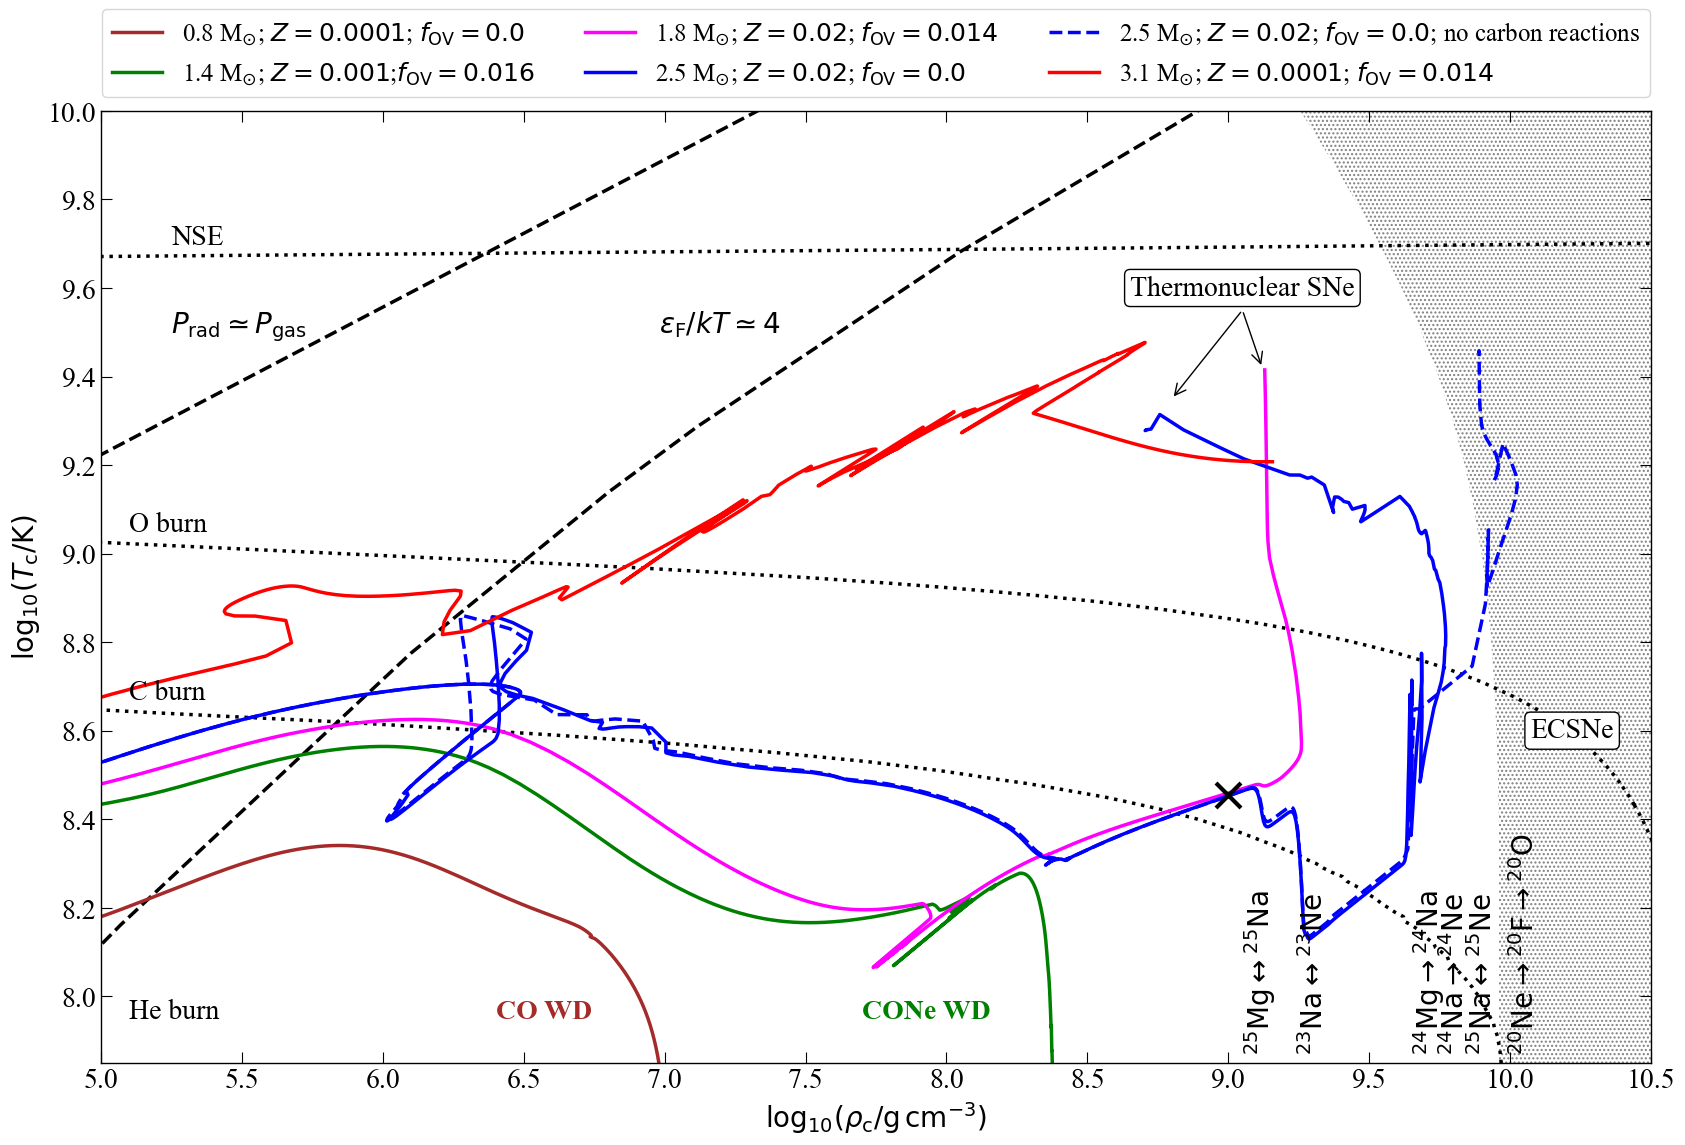

In [17]:
fontsize=20
make_canvas(fig_width=20, columns=1, fontsize=fontsize)

logrhoc_logTc(data, labels,
              colors=colors, lstyle=lstyle,
              ecap_density_corrections=True, 
              fontsize=fontsize,
              xlim=[5.0, 10.5], ylim=[7.85, 10.0]
             )

# Arbitrary location prior to Urca process
# At this density we calculate the amount of 
# residual carbon
plt.plot(9.0, 8.455, 'x', markersize=18, color='k', mew=3)



    
plt.text(9.05, 9.60, r'Thermonuclear SNe', 
                {'color': 'black', 'ha': 'center', 'va': 'center','fontsize': fontsize,'bbox': dict(boxstyle="round", fc="w", ec="k", pad=0.2)})
plt.annotate("",
            xy=(8.8, 9.35),
            xytext=(9.05, 9.55),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.annotate("",
            xy=(9.12, 9.42),
            xytext=(9.05, 9.55),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.text(6.4, 7.95, 'CO WD', color = 'brown', fontsize = fontsize, weight='bold')
plt.text(7.7, 7.95, 'CONe WD', color = 'green', fontsize = fontsize, weight='bold')


plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12),
           ncol=3, fancybox=True, shadow=False, prop={'size': 18}) 

# plt.savefig(os.path.join(plot_results_dir, "RhoT_series1_final.pdf"), dpi=300, bbox_inches='tight')

In [18]:
data2 = [
        mr.MesaData(os.path.join(fiducial_models_work_dir[3], 'history.data')).data,
        mr.MesaData(os.path.join(series2_work_dir[1], '2.0000_0.0200_0.2500/LOGS/history.data')).data,
        mr.MesaData(os.path.join(series2_work_dir[3], '2.7000_0.0200_0.8000/LOGS/history.data')).data,
        mr.MesaData(os.path.join(series2_work_dir[5], '2.1000_0.0200_1.5800/LOGS/history.data')).data,
    ]
        
labels2 = [
          r'2.5 M$_{\odot}$; $Z=0.02$; $f_{\rm OV}=0.0$; $\eta=1.0$',
          r'2.0 M$_{\odot}$; $Z=0.02$, $f_{\rm OV}=0.0$; $\eta = 0.25$',
          r'2.7 M$_{\odot}$; $Z=0.02$, $f_{\rm OV}=0.0$; $\eta = 0.8$',
          r'2.1 M$_{\odot}$; $Z=0.02$, $f_{\rm OV}=0.0$; $\eta = 1.58$'
    ]



colors2 = ['grey','tab:orange', 'tab:purple', 'tab:brown']
lstyle2 = ['-.', '-', '-', '-'] 

<ipython-input-15-bc74916e51c9>:19: RuntimeWarning: overflow encountered in exp
  logrho = -(np.log10(np.exp(179./T - 40.5))-np.log10(s))/0.2


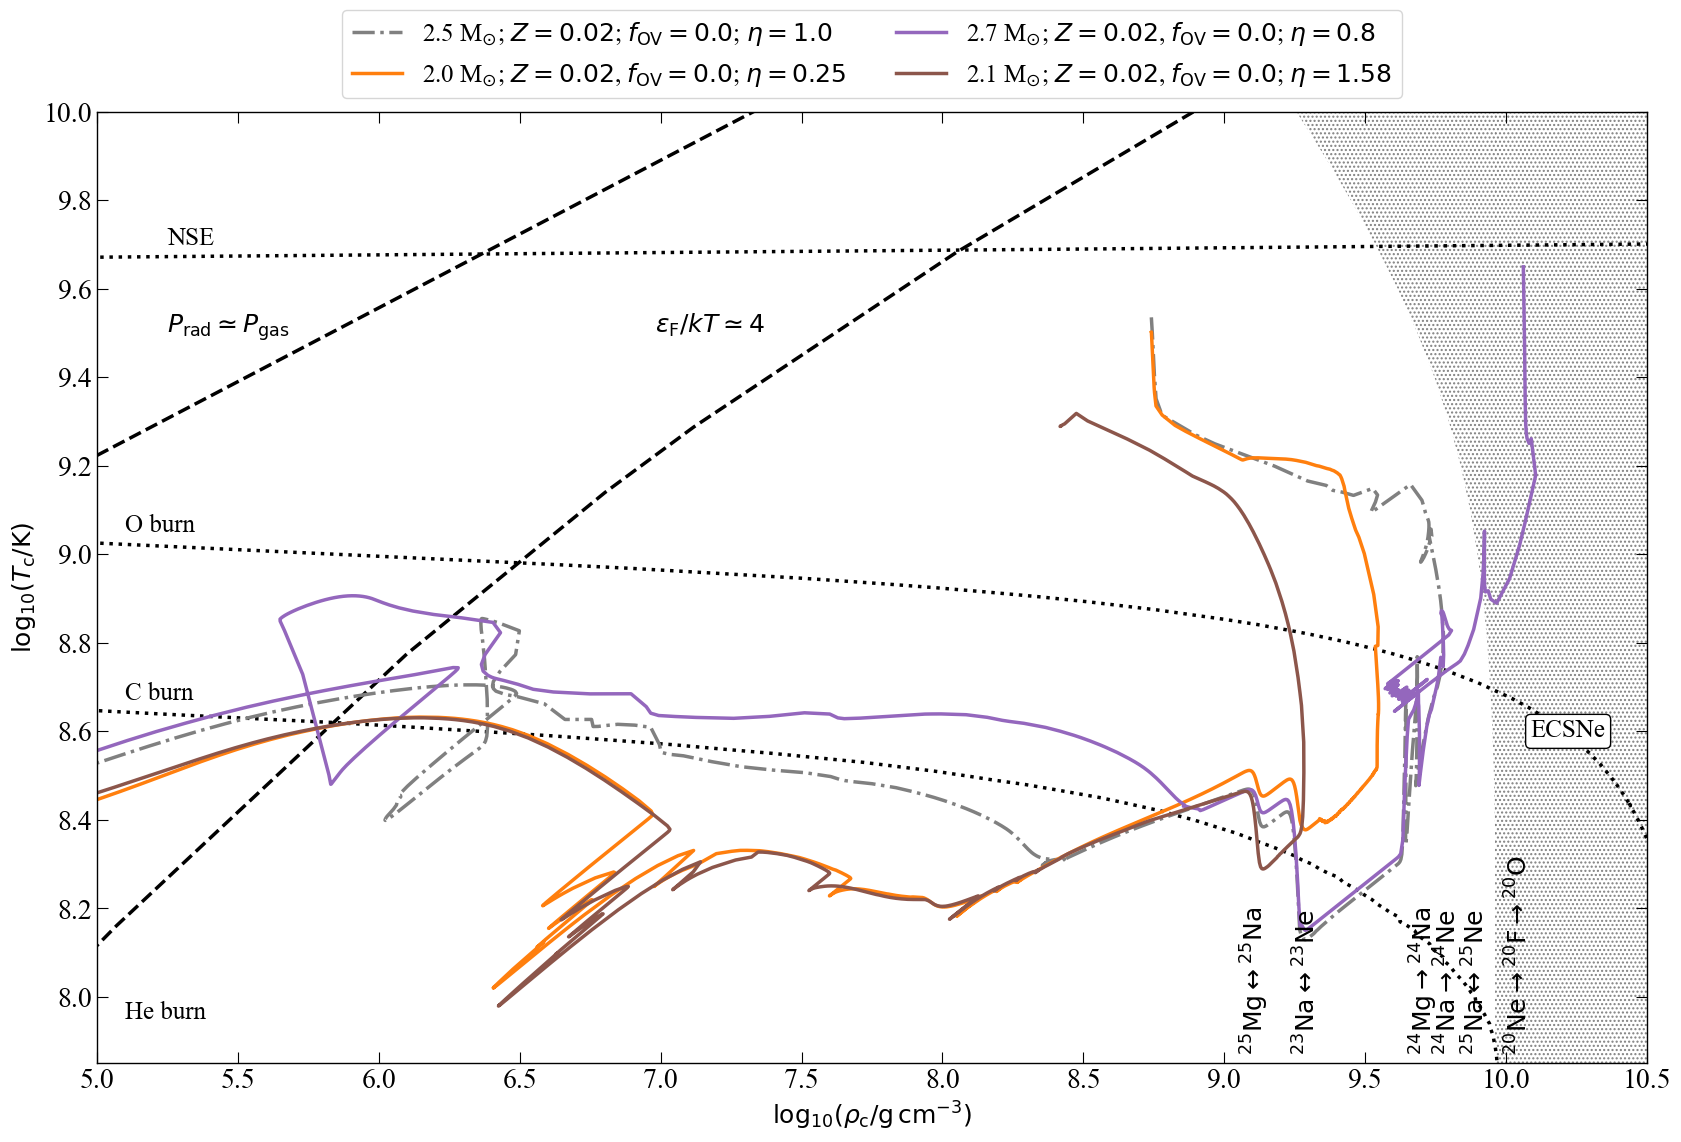

In [19]:
fontsize=20
make_canvas(fig_width=20, columns=1, fontsize=fontsize)


logrhoc_logTc(data2, labels2,
              colors=colors2, lstyle=lstyle2,
              ecap_density_corrections=True,
              xlim=[5.0, 10.5], ylim=[7.85, 10.0]
             )


plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12),
           ncol=2, fancybox=True, shadow=False, prop={'size': 18}) 

# plt.savefig(os.path.join(plot_results_dir, "RhoT_series2_final.pdf"), dpi=300, bbox_inches='tight')

## Energetics & Nucleosynthesis

In [20]:
def potential_energy(rad,rho):
    udr = c.G*16./3. * np.pi**2. *rho**2 * rad**4 
    return np.trapz(udr,rad).to(u.erg)


def total_energy(Et,mass):
    Et = Et*u.erg/u.gram 
    mass = (mass*u.Msun)
    
    return (Et*mass).sum().to(u.erg)

def nuc_energy(A1,A2,mu1,mu2,X,mtot):
     # A1 -> A2 + energy
    energy_per_reaction = ((A2*mu1 - A1*mu2)*u.mu*c.c**2).to(u.erg)
    reactions_per_gram = (1*u.g / (A2*mu1*u.mu)).to(u.dimensionless_unscaled)/u.g
    mtot = u.Quantity(mtot,u.Msun)
    return (energy_per_reaction*reactions_per_gram *(X*mtot)).to(u.erg)


def kinetic_energy(p,Xige,Xime,Xfe=0.2):
    mass = p('dq')*p('mass')[0]
    Mige = p('mass')[0]*Xige
    Mime = p('mass')[0]*Xime
    c12  = 12.00000
    o16  = 15.994915
    ne20 = 19.992440
    na23 = 22.989769
    mg24 = 23.985042
    si28 = 27.976927
    fe56 = 55.934937
    ni56 = 55.942129
    
    E = 0.0
    msum = 0.0
    i=0
    for m in mass[::-1]:
        if msum <= Mige:
            E += nuc_energy(12,56,c12,ni56,p('c12')[::-1][i]*(1-Xfe),m)
            E += nuc_energy(12,56,c12,fe56,p('c12')[::-1][i]*Xfe,m)
            E += nuc_energy(16,56,o16,ni56,p('o16')[::-1][i]*(1-Xfe),m)
            E += nuc_energy(16,56,o16,fe56,p('o16')[::-1][i]*Xfe,m)   
            E += nuc_energy(20,56,ne20,ni56,p('ne20')[::-1][i]*(1-Xfe),m)
            E += nuc_energy(20,56,ne20,fe56,p('ne20')[::-1][i]*Xfe,m) 
            E += nuc_energy(23,56,na23,ni56,p('na23')[::-1][i]*(1-Xfe),m)
            E += nuc_energy(23,56,na23,fe56,p('na23')[::-1][i]*Xfe,m) 
            E += nuc_energy(24,56,mg24,ni56,p('mg24')[::-1][i]*(1-Xfe),m)
            E += nuc_energy(24,56,mg24,fe56,p('mg24')[::-1][i]*Xfe,m) 

        elif ((msum > Mige) & (msum <= (Mige+ Mime))):
            E += nuc_energy(12,28,c12,si28,p('c12')[::-1][i],m)
            E += nuc_energy(16,28,o16,si28,p('o16')[::-1][i],m)
            E += nuc_energy(20,28,ne20,si28,p('ne20')[::-1][i],m)
            E += nuc_energy(23,28,na23,si28,p('na23')[::-1][i],m)
            E += nuc_energy(24,28,mg24,si28,p('mg24')[::-1][i],m)
        i+=1
        msum += m 
    Eint=(p('total_energy')*mass* u.erg/u.gram * u.Msun).sum().to(u.erg)
    return E,Eint,E+Eint 

0.08049741728517892 0.033857664912216576 0.4164771419792812 0.422622640406031 0.0370988975820531 0.20044067267130025 0.0019020381825963343 0.49825848059703187
0.05513860821665217 8.325408893832521e-05 0.5202355321359251 0.1043940393537097 0.040075015574717036 0.2385786786286394 0.00311608707034004 0.49852015095781427
0.003163559445577965 1.6970282196944294e-06 0.44190846533854344 0.4143911840494696 0.027306477747552987 0.06574991151235889 0.0007131095181906776 0.49490801622087793
0.003163242408180163 1.359246404136264e-05 0.3370403753980802 0.3280665081404776 0.027269673969181778 0.06619405297443096 0.0007125805667033821 0.4945910701528685
0.031239172048348526 0.05627467497555509 0.42542891720151466 0.39755649117222036 0.04803109263378217 0.11932800415971295 0.002581015466278924 0.49843626507436806
0.005821514669245835 4.480635113000659e-06 0.46060841717306694 0.24244822173829272 0.03731582299115 0.18777496120303977 0.0031091776953482662 0.49840432526446304


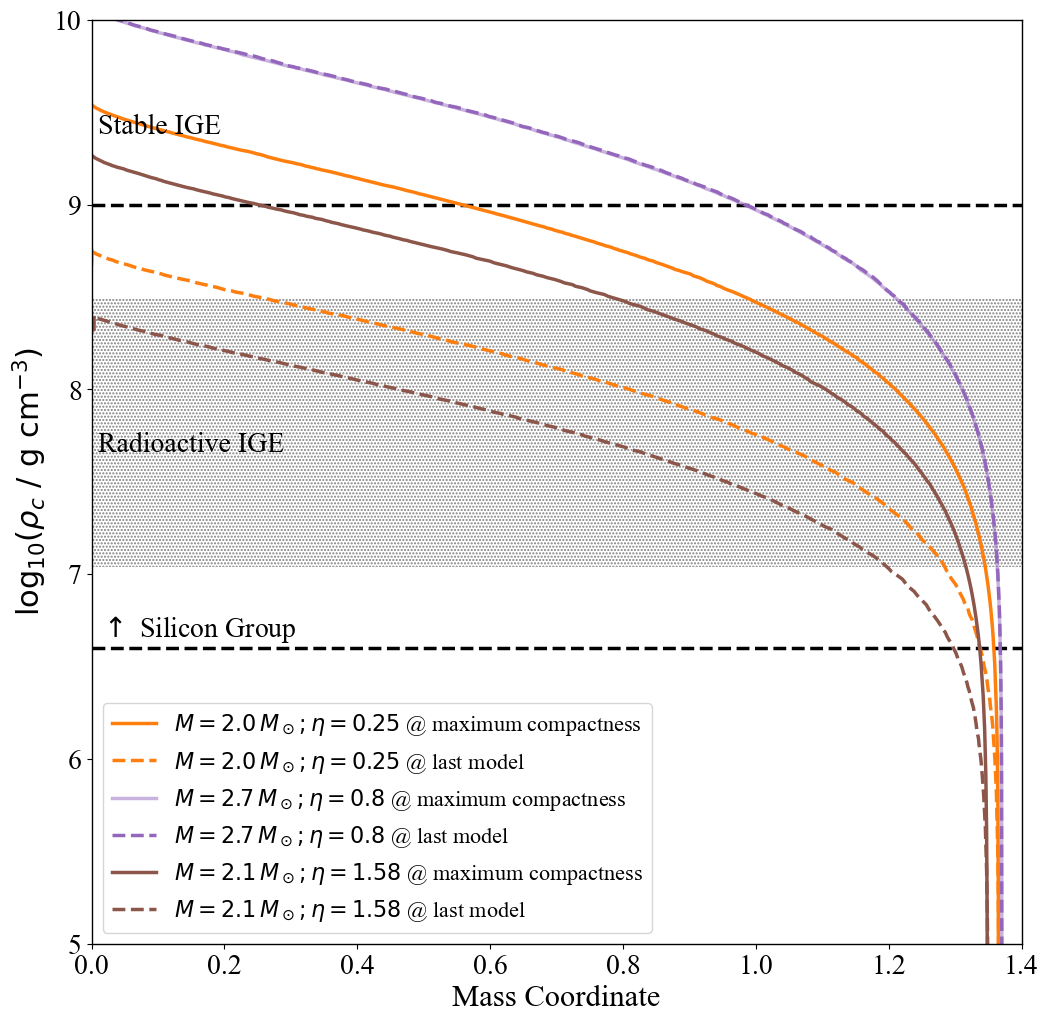

In [21]:
profiles = [#mr.MesaData(os.path.join(series2_work_dir[4],'2.5000_0.0200_1.0000/profile_max_Rho.data')).data,
            #mr.MesaData(os.path.join(series2_work_dir[4],'2.5000_0.0200_1.0000/final_profile.data')).data,
            mr.MesaData(os.path.join(series2_work_dir[1],'2.0000_0.0200_0.2500/profile_max_Rho.data')).data,
            mr.MesaData(os.path.join(series2_work_dir[1],'2.0000_0.0200_0.2500/final_profile.data')).data,
            mr.MesaData(os.path.join(series2_work_dir[3],'2.7000_0.0200_0.8000/profile_max_Rho.data')).data,
            mr.MesaData(os.path.join(series2_work_dir[3],'2.7000_0.0200_0.8000/final_profile.data')).data,
            mr.MesaData(os.path.join(series2_work_dir[5],'2.1000_0.0200_1.5800/profile_max_Rho.data')).data,
            mr.MesaData(os.path.join(series2_work_dir[5],'2.1000_0.0200_1.5800/final_profile.data')).data
            #mr.MesaData(os.path.join(series2_work_dir[5],'2.4000_0.0200_1.5800/final_profile.data')).data
           ]


def mass_average(profile,quantity='o16'):
    mass = profile('dq')*profile('mass')[0]
    
    return (profile(quantity)*mass).sum()/mass.sum()


def nucleosynthesis():
    plt.rcParams['figure.figsize'] = [12, 12]
    plt.rcParams['font.size'] = 22
    plt.xlabel(r'Mass Coordinate',fontsize=22)
    plt.ylabel(r'$\log_{10} (\rho_c \ / \rm \ g \ cm^{-3})$', fontsize=22)
    m = np.arange(0.0,1.5,0.1)
    rho  = np.arange(0,11.,0.01)
    

    
    plt.plot(m,np.ones_like(m)*9.0,ls='--',color='black')
    plt.text(0.01, 9.42, r'Stable IGE ', 
             {'color': 'black', 'ha': 'left', 'va': 'center','fontsize': 20})
    
    
    plt.text(0.01, 7.7, r'Radioactive IGE', 
             {'color': 'black', 'ha': 'left', 'va': 'center','fontsize': 20})
    
    
    
    plt.plot(m,np.ones_like(m)*6.6,ls='--',color='black')
    plt.text(0.01, 6.7, r'$\uparrow$ Silicon Group', 
             {'color': 'black', 'ha': 'left', 'va': 'center','fontsize': 20})
    plt.fill_between(m,7.04,8.49,facecolor="none", hatch=".....", edgecolor="gray", linewidth=0.0)
    
    plt.plot(profiles[0]('mass'),profiles[0]('logRho'),color='tab:orange',ls='-',label=r'$M=2.0\,M_\odot;\eta=0.25$ @ maximum compactness')
    plt.plot(profiles[1]('mass'),profiles[1]('logRho'),color='tab:orange',ls='--',label=r'$M=2.0\,M_\odot;\eta=0.25$ @ last model')
    plt.plot(profiles[2]('mass'),profiles[2]('logRho'),alpha=0.5,color='tab:purple',ls='-',label=r'$M=2.7\,M_\odot;\eta=0.8$ @ maximum compactness')
    plt.plot(profiles[3]('mass'),profiles[3]('logRho'),color='tab:purple',ls='--',label=r'$M=2.7\,M_\odot;\eta=0.8$ @ last model')
    plt.plot(profiles[4]('mass'),profiles[4]('logRho'),color='tab:brown',ls='-',label=r'$M=2.1\,M_\odot;\eta=1.58$ @ maximum compactness')
    plt.plot(profiles[5]('mass'),profiles[5]('logRho'),color='tab:brown',ls='--',label=r'$M=2.1\,M_\odot;\eta=1.58$ @ last model')
    plt.ylim([5,10.0])
    plt.xlim([0.0,1.4])
    plt.legend(prop={'size': 16},loc='lower left')
    
    # plt.savefig(os.path.join(plot_results_dir,'composition_series2.pdf'), dpi=300, bbox_inches='tight')

    
# make_canvas(fig_width=12, fig_height=12, fontsize=20)

nucleosynthesis()

for p in profiles:
    print(mass_average(p,quantity='c12'),p('c12')[-1],p('o16')[-1],p('ne20')[-1],mass_average(p,quantity='na23'),mass_average(p,quantity='mg24'),mass_average(p,quantity='mg25'),mass_average(p,quantity='ye'))

In [22]:
# kinetic_energy(profiles[8],0.7,0.8,Xfe=0.1)

for p in profiles:
    print(kinetic_energy(p, 0.7, 0.8, Xfe=0.1))

(<Quantity 1.81072861e+51 erg>, <Quantity -5.50460469e+50 erg>, <Quantity 1.26026814e+51 erg>)
(<Quantity 1.73337494e+51 erg>, <Quantity 1.81771796e+61 erg>, <Quantity 1.81771796e+61 erg>)
(<Quantity 1.39216772e+51 erg>, <Quantity -6.18315736e+50 erg>, <Quantity 7.73851983e+50 erg>)
(<Quantity 1.38242833e+51 erg>, <Quantity 2.83439507e+51 erg>, <Quantity 4.2168234e+51 erg>)
(<Quantity 1.4578726e+51 erg>, <Quantity -5.1292877e+50 erg>, <Quantity 9.44943828e+50 erg>)
(<Quantity 1.34745412e+51 erg>, <Quantity -4.01843301e+50 erg>, <Quantity 9.4561082e+50 erg>)


## Central abundances when log(Rho) \sim 9.0

In [23]:
# initial_masses_grid_s1 = [q/10.0 for q in range(8, 36)]
# initial_masses_grid_s2 = [q/10.0 for q in range(14, 36)]

s1_grid_dir = ['/Volumes/SavvasExternal/aifa_models/full_grid_logfiles']

zlow_f0_c12, zlow_f0_o16, zlow_f0_ne20, zlow_f0_mg25, zlow_f0_na25, zlow_f0_na23, zlow_f0_ne23 = [], [], [], [], [], [], []
zlow_f1_c12, zlow_f1_o16, zlow_f1_ne20, zlow_f1_mg25, zlow_f1_na25, zlow_f1_na23, zlow_f1_ne23 = [], [], [], [], [], [], []
zlow_f2_c12, zlow_f2_o16, zlow_f2_ne20, zlow_f2_mg25, zlow_f2_na25, zlow_f2_na23, zlow_f2_ne23 = [], [], [], [], [], [], []
zlow_f0_mass, zlow_f1_mass, zlow_f2_mass = [], [], []

zim_f0_c12, zim_f0_o16, zim_f0_ne20, zim_f0_mg25, zim_f0_na25, zim_f0_na23, zim_f0_ne23 = [], [], [], [], [], [], []
zim_f1_c12, zim_f1_o16, zim_f1_ne20, zim_f1_mg25, zim_f1_na25, zim_f1_na23, zim_f1_ne23 = [], [], [], [], [], [], []
zim_f2_c12, zim_f2_o16, zim_f2_ne20, zim_f2_mg25, zim_f2_na25, zim_f2_na23, zim_f2_ne23 = [], [], [], [], [], [], []
zim_f0_mass, zim_f1_mass, zim_f2_mass = [], [], []

zsol_f0_c12, zsol_f0_o16, zsol_f0_ne20, zsol_f0_mg25, zsol_f0_na25, zsol_f0_na23, zsol_f0_ne23 = [], [], [], [], [], [], []
zsol_f1_c12, zsol_f1_o16, zsol_f1_ne20, zsol_f1_mg25, zsol_f1_na25, zsol_f1_na23, zsol_f1_ne23 = [], [], [], [], [], [], []
zsol_f2_c12, zsol_f2_o16, zsol_f2_ne20, zsol_f2_mg25, zsol_f2_na25, zsol_f2_na23, zsol_f2_ne23 = [], [], [], [], [], [], []
zsol_f0_mass, zsol_f1_mass, zsol_f2_mass = [], [], []



s2_grid_dirs = ['/Volumes/SavvasExternal/zsol_eta0p1',
                '/Volumes/SavvasExternal/zsol_eta0p25',
                '/Volumes/SavvasExternal/zsol_eta0p5',
                '/Volumes/SavvasExternal/zsol_eta0p8',
                '/Volumes/SavvasExternal/zsol_eta1p0',
                '/Volumes/SavvasExternal/zsol_eta1p58'
]

eta0p1_mass, eta0p25_mass, eta0p5_mass, eta0p8_mass, eta1p0_mass, eta1p58_mass = [],[],[],[],[],[]

eta0p1_c12, eta0p1_o16, eta0p1_ne20, eta0p1_mg25, eta0p1_na25, eta0p1_na23, eta0p1_ne23 = [], [], [], [], [], [], []
eta0p25_c12, eta0p25_o16, eta0p25_ne20, eta0p25_mg25, eta0p25_na25, eta0p25_na23, eta0p25_ne23 = [], [], [], [], [], [], []
eta0p5_c12, eta0p5_o16, eta0p5_ne20, eta0p5_mg25, eta0p5_na25, eta0p5_na23, eta0p5_ne23 = [], [], [], [], [], [], []
eta0p8_c12, eta0p8_o16, eta0p8_ne20, eta0p8_mg25, eta0p8_na25, eta0p8_na23, eta0p8_ne23 = [], [], [], [], [], [], []
eta1p0_c12, eta1p0_o16, eta1p0_ne20, eta1p0_mg25, eta1p0_na25, eta1p0_na23, eta1p0_ne23 = [], [], [], [], [], [], []
eta1p58_c12, eta1p58_o16, eta1p58_ne20, eta1p58_mg25, eta1p58_na25, eta1p58_na23, eta1p58_ne23 = [], [], [], [], [], [], []

In [24]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def iso_mass(profile, starting_index=0, iso='he4'):
    return (profile.data('dq')[starting_index:]*profile.data(iso)[starting_index:]).sum()*profile.data('mass')[0]

In [25]:
'''
USE THIS ONLY TO CREATE LOG FILES FROM DATA! 
USE THESE LOG FILES TO READ DATA IN THE FUTURE!
DO NOT RUN THIS SHELL IF *_isos_distribution_log.txt EXIST
''' 

# orig_stdout = sys.stdout
# file_log_s1 = open('series1_isos_distribution_log.txt', 'w')
# sys.stdout = file_log_s1

# for path in glob.glob(os.path.join('/Volumes/SavvasExternal/aifa_models/full_grid_logfiles', '*')):

#     model_info = path.split('/')[-1]
#     initial_mass = float(model_info.split('_')[0])
#     z = str(model_info.split('_')[1])
#     f = str(model_info.split('_')[-1])

#     print('##'*50)
#     print('PROCEEDING WITH MODEL:', model_info)
#     print('----')

#     try:

#         l = mr.MesaLogDir(os.path.join(path, 'LOGS'))
#         h = l.history
#         print('History file loaded!')

#     except Exception as e:
#         print(e)

#     # Find the right profile
#     if max(h.data('log_center_Rho')) < 9.0:
#         last_model_number = h.data('model_number')[-1]

#         print('The density does not reach the threshold value of 9.0!')
#         print('Loading the profile for last saved model number: ', last_model_number)

#         try:
#             p = l.profile_data()
#             print('Last profile loaded!')
#         except Exception as e:
#             print(e)



#         # What is the core mass of this model?
#         try:
#             if h.data('star_mass')[-1] != h.data('c_core_mass')[-1] and not \
#                 math.isclose(h.data('c_core_mass')[-1], 0.0, abs_tol = 0.0):

#                 core_boundary = round(h.data('c_core_mass')[-1], 3)
#                 final_envelope_mass = round(h.data('star_mass')[-1] - h.data('c_core_mass')[-1], 3)
#                 print('Core mass estimate: ', core_boundary)


#             elif h.data('star_mass')[-1] == h.data('c_core_mass')[-1] or \
#                 math.isclose(h.data('c_core_mass')[-1], 0.0, abs_tol = 0.0):

#                 # Find the core mass based on the Pgas/Pdeg ratio
#                 # for the given profile
#                 Pdeg = 10 ** p.data("logP") - p.data("Pgas")
#                 P_ratio = p.data("Pgas") / Pdeg

#                 try:
#                     foundCoreMassWithPratio = False
#                     for i in range(len(P_ratio)):
#                         if math.isclose(P_ratio[i], 1.0, abs_tol=0.05):
#                             core_boundary = round(p.data("mass")[i], 3)
#                             foundCoreMassWithPratio = True
#                 except Exception as e:
#                     print(e)

#                 if foundCoreMassWithPratio:
#                     print("Core mass estimated with Pratio")
#                 else:
#                     mask = 0.80 * max(p.data("logP"))
#                     core_boundary = round(p.data("mass")[np.where(logP < mask)][-1], 3)
#                     print("Core mass estimated with the pressure profile")

#                 print('Core mass estimate: ', core_boundary)

#         except Exception as e:
#             print(e)


#     else:
#         for idx, rho in enumerate(h.data('log_center_Rho')):
#             if math.isclose(rho, 9.0, abs_tol=0.05):

#                 rho9_model_number = h.data('model_number')[idx]
#                 print('The density reaches the threshold value of 9.0!')
#                 print('Looking for profile closest to model number:', rho9_model_number)
#                 break

#         # Check to see if the model number has a corresponding profile
#         if l.have_profile_with_model_number(rho9_model_number):
#             try:
#                 p = l.profile_data(model_number=rho9_model_number)
#                 print('Rho9 profile loaded!')
#             except Exception as e:
#                 print(e)

#             # What is the core mass of this model?
#             try:
#                 if h.data('star_mass')[-1] != h.data('c_core_mass')[-1] and not \
#                     math.isclose(h.data('c_core_mass')[-1], 0.0, abs_tol = 0.0):

#                     core_boundary = round(h.data('c_core_mass')[-1], 3)
#                     final_envelope_mass = round(h.data('star_mass')[-1] - h.data('c_core_mass')[-1], 3)
#                     print('Core mass estimate: ', core_boundary)


#                 elif h.data('star_mass')[-1] == h.data('c_core_mass')[-1] or \
#                     math.isclose(h.data('c_core_mass')[-1], 0.0, abs_tol = 0.0):

#                     # Find the core mass based on the Pgas/Pdeg ratio
#                     # for the given profile
#                     Pdeg = 10 ** p.data("logP") - p.data("Pgas")
#                     P_ratio = p.data("Pgas") / Pdeg

#                     try:
#                         foundCoreMassWithPratio = False
#                         for i in range(len(P_ratio)):
#                             if math.isclose(P_ratio[i], 1.0, abs_tol=0.05):
#                                 core_boundary = round(p.data("mass")[i], 3)
#                                 foundCoreMassWithPratio = True
#                     except Exception as e:
#                         print(e)

#                     if foundCoreMassWithPratio:
#                         print("Core mass estimated with Pratio")
#                     else:
#                         mask = 0.80 * max(p.data("logP"))
#                         core_boundary = round(p.data("mass")[np.where(logP < mask)][-1], 3)
#                         print("Core mass estimated with the pressure profile")

#                     print('Core mass estimate: ', core_boundary)

#             except Exception as e:
#                 print(e)

#         else:
#             print('There is no profile that much the model number for Rho9!')
#             print('Trying to load the nearest profile!')

#             m_nums = l.model_numbers
#             print('Available profiles for models: ', m_nums)


#             new_rho9_model_number = find_nearest(m_nums, rho9_model_number)


#             for idx, value in enumerate(h.data('model_number')):
#                 if new_rho9_model_number == value:
#                     print('Estimation for density: ', h.data('log_center_Rho')[idx])

#             try:
#                 p = l.profile_data(model_number=new_rho9_model_number)
#                 print(f'Rho9 profile loaded! -> Model number {new_rho9_model_number}')
#             except Exception as e:
#                 print(e)

#             # What is the core mass of this model?
#             try:
#                 if h.data('star_mass')[-1] != h.data('c_core_mass')[-1] and not \
#                     math.isclose(h.data('c_core_mass')[-1], 0.0, abs_tol = 0.0):

#                     core_boundary = round(h.data('c_core_mass')[-1], 3)
#                     final_envelope_mass = round(h.data('star_mass')[-1] - h.data('c_core_mass')[-1], 3)
#                     print('Core mass estimate: ', core_boundary)


#                 elif h.data('star_mass')[-1] == h.data('c_core_mass')[-1] or \
#                     math.isclose(h.data('c_core_mass')[-1], 0.0, abs_tol = 0.0):

#                     # Find the core mass based on the Pgas/Pdeg ratio
#                     # for the given profile
#                     Pdeg = 10 ** p.data("logP") - p.data("Pgas")
#                     P_ratio = p.data("Pgas") / Pdeg

#                     try:
#                         foundCoreMassWithPratio = False
#                         for i in range(len(P_ratio)):
#                             if math.isclose(P_ratio[i], 1.0, abs_tol=0.05):
#                                 core_boundary = round(p.data("mass")[i], 3)
#                                 foundCoreMassWithPratio = True
#                     except Exception as e:
#                         print(e)

#                     if foundCoreMassWithPratio:
#                         print("Core mass estimated with Pratio")
#                     else:
#                         mask = 0.80 * max(p.data("logP"))
#                         core_boundary = round(p.data("mass")[np.where(logP < mask)][-1], 3)
#                         print("Core mass estimated with the pressure profile")

#                     print('Core mass estimate: ', core_boundary)

#             except Exception as e:
#                 print(e)


#     filt = np.where(p.data('mass') <= core_boundary)
#     filt = filt[0][0]
#     print('C12 distribution in core', sum(p.data('dq')[filt:]*p.data('c12')[filt:]))
#     print('O16 distribution in core', sum(p.data('dq')[filt:]*p.data('o16')[filt:]))
#     print('Ne20 distribution in core', sum(p.data('dq')[filt:]*p.data('ne20')[filt:]))

#     print('Mg25 distribution in core', sum(p.data('dq')[filt:]*p.data('mg25')[filt:]))
#     print('Na25 distribution in core', sum(p.data('dq')[filt:]*p.data('na25')[filt:]))

#     print('Na23 distribution in core', sum(p.data('dq')[filt:]*p.data('na23')[filt:]))
#     print('Ne23 distribution in core', sum(p.data('dq')[filt:]*p.data('ne23')[filt:]))

#     if z == '0.0001' and f == '0.0000':
#         zlow_f0_mass.append(initial_mass)

#         zlow_f0_c12.append(sum(p.data('dq')[filt:]*p.data('c12')[filt:]))
#         zlow_f0_o16.append(sum(p.data('dq')[filt:]*p.data('o16')[filt:]))
#         zlow_f0_ne20.append(sum(p.data('dq')[filt:]*p.data('ne20')[filt:]))
#         zlow_f0_mg25.append(sum(p.data('dq')[filt:]*p.data('mg25')[filt:]))
#         zlow_f0_na25.append(sum(p.data('dq')[filt:]*p.data('na25')[filt:]))
#         zlow_f0_na23.append(sum(p.data('dq')[filt:]*p.data('na23')[filt:]))
#         zlow_f0_ne23.append(sum(p.data('dq')[filt:]*p.data('ne23')[filt:]))
#     elif z == '0.0001' and f == '0.0140':
#         zlow_f1_mass.append(initial_mass)

#         zlow_f1_c12.append(sum(p.data('dq')[filt:]*p.data('c12')[filt:]))
#         zlow_f1_o16.append(sum(p.data('dq')[filt:]*p.data('o16')[filt:]))
#         zlow_f1_ne20.append(sum(p.data('dq')[filt:]*p.data('ne20')[filt:]))
#         zlow_f1_mg25.append(sum(p.data('dq')[filt:]*p.data('mg25')[filt:]))
#         zlow_f1_na25.append(sum(p.data('dq')[filt:]*p.data('na25')[filt:]))
#         zlow_f1_na23.append(sum(p.data('dq')[filt:]*p.data('na23')[filt:]))
#         zlow_f1_ne23.append(sum(p.data('dq')[filt:]*p.data('ne23')[filt:]))
#     elif z == '0.0001' and f == '0.0160':
#         zlow_f2_mass.append(initial_mass)

#         zlow_f2_c12.append(sum(p.data('dq')[filt:]*p.data('c12')[filt:]))
#         zlow_f2_o16.append(sum(p.data('dq')[filt:]*p.data('o16')[filt:]))
#         zlow_f2_ne20.append(sum(p.data('dq')[filt:]*p.data('ne20')[filt:]))
#         zlow_f2_mg25.append(sum(p.data('dq')[filt:]*p.data('mg25')[filt:]))
#         zlow_f2_na25.append(sum(p.data('dq')[filt:]*p.data('na25')[filt:]))
#         zlow_f2_na23.append(sum(p.data('dq')[filt:]*p.data('na23')[filt:]))
#         zlow_f2_ne23.append(sum(p.data('dq')[filt:]*p.data('ne23')[filt:]))
#     elif z == '0.0010' and f == '0.0000':
#         zim_f0_mass.append(initial_mass)

#         zim_f0_c12.append(sum(p.data('dq')[filt:]*p.data('c12')[filt:]))
#         zim_f0_o16.append(sum(p.data('dq')[filt:]*p.data('o16')[filt:]))
#         zim_f0_ne20.append(sum(p.data('dq')[filt:]*p.data('ne20')[filt:]))
#         zim_f0_mg25.append(sum(p.data('dq')[filt:]*p.data('mg25')[filt:]))
#         zim_f0_na25.append(sum(p.data('dq')[filt:]*p.data('na25')[filt:]))
#         zim_f0_na23.append(sum(p.data('dq')[filt:]*p.data('na23')[filt:]))
#         zim_f0_ne23.append(sum(p.data('dq')[filt:]*p.data('ne23')[filt:]))
#     elif z == '0.0010' and f == '0.0140':
#         zim_f1_mass.append(initial_mass)

#         zim_f1_c12.append(sum(p.data('dq')[filt:]*p.data('c12')[filt:]))
#         zim_f1_o16.append(sum(p.data('dq')[filt:]*p.data('o16')[filt:]))
#         zim_f1_ne20.append(sum(p.data('dq')[filt:]*p.data('ne20')[filt:]))
#         zim_f1_mg25.append(sum(p.data('dq')[filt:]*p.data('mg25')[filt:]))
#         zim_f1_na25.append(sum(p.data('dq')[filt:]*p.data('na25')[filt:]))
#         zim_f1_na23.append(sum(p.data('dq')[filt:]*p.data('na23')[filt:]))
#         zim_f1_ne23.append(sum(p.data('dq')[filt:]*p.data('ne23')[filt:]))
#     elif z == '0.0010' and f == '0.0160':
#         zim_f2_mass.append(initial_mass)

#         zim_f2_c12.append(sum(p.data('dq')[filt:]*p.data('c12')[filt:]))
#         zim_f2_o16.append(sum(p.data('dq')[filt:]*p.data('o16')[filt:]))
#         zim_f2_ne20.append(sum(p.data('dq')[filt:]*p.data('ne20')[filt:]))
#         zim_f2_mg25.append(sum(p.data('dq')[filt:]*p.data('mg25')[filt:]))
#         zim_f2_na25.append(sum(p.data('dq')[filt:]*p.data('na25')[filt:]))
#         zim_f2_na23.append(sum(p.data('dq')[filt:]*p.data('na23')[filt:]))
#         zim_f2_ne23.append(sum(p.data('dq')[filt:]*p.data('ne23')[filt:]))
#     elif z == '0.0200' and f == '0.0000':
#         zsol_f0_mass.append(initial_mass)

#         zsol_f0_c12.append(sum(p.data('dq')[filt:]*p.data('c12')[filt:]))
#         zsol_f0_o16.append(sum(p.data('dq')[filt:]*p.data('o16')[filt:]))
#         zsol_f0_ne20.append(sum(p.data('dq')[filt:]*p.data('ne20')[filt:]))
#         zsol_f0_mg25.append(sum(p.data('dq')[filt:]*p.data('mg25')[filt:]))
#         zsol_f0_na25.append(sum(p.data('dq')[filt:]*p.data('na25')[filt:]))
#         zsol_f0_na23.append(sum(p.data('dq')[filt:]*p.data('na23')[filt:]))
#         zsol_f0_ne23.append(sum(p.data('dq')[filt:]*p.data('ne23')[filt:]))
#     elif z == '0.0200' and f == '0.0140':
#         zsol_f1_mass.append(initial_mass)

#         zsol_f1_c12.append(sum(p.data('dq')[filt:]*p.data('c12')[filt:]))
#         zsol_f1_o16.append(sum(p.data('dq')[filt:]*p.data('o16')[filt:]))
#         zsol_f1_ne20.append(sum(p.data('dq')[filt:]*p.data('ne20')[filt:]))
#         zsol_f1_mg25.append(sum(p.data('dq')[filt:]*p.data('mg25')[filt:]))
#         zsol_f1_na25.append(sum(p.data('dq')[filt:]*p.data('na25')[filt:]))
#         zsol_f1_na23.append(sum(p.data('dq')[filt:]*p.data('na23')[filt:]))
#         zsol_f1_ne23.append(sum(p.data('dq')[filt:]*p.data('ne23')[filt:]))
#     elif z == '0.0200' and f == '0.0160':
#         zsol_f2_mass.append(initial_mass)

#         zsol_f2_c12.append(sum(p.data('dq')[filt:]*p.data('c12')[filt:]))
#         zsol_f2_o16.append(sum(p.data('dq')[filt:]*p.data('o16')[filt:]))
#         zsol_f2_ne20.append(sum(p.data('dq')[filt:]*p.data('ne20')[filt:]))
#         zsol_f2_mg25.append(sum(p.data('dq')[filt:]*p.data('mg25')[filt:]))
#         zsol_f2_na25.append(sum(p.data('dq')[filt:]*p.data('na25')[filt:]))
#         zsol_f2_na23.append(sum(p.data('dq')[filt:]*p.data('na23')[filt:]))
#         zsol_f2_ne23.append(sum(p.data('dq')[filt:]*p.data('ne23')[filt:]))

#     else:
#         print('STOP!')
#         break
            
# sys.stdout = orig_stdout
# file_log_s1.close()

'\nUSE THIS ONLY TO CREATE LOG FILES FROM DATA! \nUSE THESE LOG FILES TO READ DATA IN THE FUTURE!\nDO NOT RUN THIS SHELL IF *_isos_distribution_log.txt EXIST\n'

In [26]:
'''
USE THIS ONLY TO CREATE LOG FILES FROM DATA! 
USE THESE LOG FILES TO READ DATA IN THE FUTURE!
DO NOT RUN THIS SHELL IF *_isos_distribution_log.txt EXIST
''' 

# orig_stdout = sys.stdout
# file_log_s2 = open('series2_isos_distribution_log.txt', 'w')
# sys.stdout = file_log_s2

# for subdir in s2_grid_dirs:
#     for path in glob.glob(os.path.join(subdir, '*')):
        
#         model_info = path.split('/')[-1]
#         initial_mass = float(model_info.split('_')[0])
#         eta = str(model_info.split('_')[-1])
        
#         print('##'*50)
#         print('PROCEEDING WITH MODEL:', model_info)
#         print('----')

#         try:

#             l = mr.MesaLogDir(os.path.join(path, 'LOGS'))
#             h = l.history
#             print('History file loaded!')

#         except Exception as e:
#             print(e)

#         # Find the right profile
#         if max(h.data('log_center_Rho')) < 9.0:
#             last_model_number = h.data('model_number')[-1]

#             print('The density does not reach the threshold value of 9.0!')
#             print('Loading the profile for last saved model number: ', last_model_number)

#             try:
#                 p = l.profile_data()
#                 print('Last profile loaded!')
#             except Exception as e:
#                 print(e)



#             # What is the core mass of this model?
#             try:
#                 if h.data('star_mass')[-1] != h.data('c_core_mass')[-1]:

#                     core_boundary = round(h.data('c_core_mass')[-1], 3)
#                     final_envelope_mass = round(h.data('star_mass')[-1] - h.data('c_core_mass')[-1], 3)
#                     print('Core mass estimate: ', core_boundary)


#                 elif h.data('star_mass')[-1] == h.data('c_core_mass')[-1] or \
#                     math.isclose(h.data('c_core_mass')[-1], 0.0, abs_tol = 0.0):

#                     # Find the core mass based on the Pgas/Pdeg ratio
#                     # for the given profile
#                     Pdeg = 10 ** p.data("logP") - p.data("Pgas")
#                     P_ratio = p.data("Pgas") / Pdeg

#                     try:
#                         foundCoreMassWithPratio = False
#                         for i in range(len(P_ratio)):
#                             if math.isclose(P_ratio[i], 1.0, abs_tol=0.05):
#                                 core_boundary = round(p.data("mass")[i], 3)
#                                 foundCoreMassWithPratio = True
#                     except Exception as e:
#                         print(e)

#                     if foundCoreMassWithPratio:
#                         print("Core mass estimated with Pratio")
#                     else:
#                         mask = 0.80 * max(p.data("logP"))
#                         core_boundary = round(p.data("mass")[np.where(logP < mask)][-1], 3)
#                         print("Core mass estimated with the pressure profile")

#                     print('Core mass estimate: ', core_boundary)

#             except Exception as e:
#                 print(e)


#         else:
#             for idx, rho in enumerate(h.data('log_center_Rho')):
#                 if math.isclose(rho, 9.0, abs_tol=0.05):

#                     rho9_model_number = h.data('model_number')[idx]
#                     print('The density reaches the threshold value of 9.0!')
#                     print('Looking for profile closest to model number:', rho9_model_number)
#                     break

#             # Check to see if the model number has a corresponding profile
#             if l.have_profile_with_model_number(rho9_model_number):
#                 try:
#                     p = l.profile_data(model_number=rho9_model_number)
#                     print('Rho9 profile loaded!')
#                 except Exception as e:
#                     print(e)

#                 # What is the core mass of this model?
#                 try:
#                     if h.data('star_mass')[-1] != h.data('c_core_mass')[-1]:

#                         core_boundary = round(h.data('c_core_mass')[-1], 3)
#                         final_envelope_mass = round(h.data('star_mass')[-1] - h.data('c_core_mass')[-1], 3)
#                         print('Core mass estimate: ', core_boundary)


#                     elif h.data('star_mass')[-1] == h.data('c_core_mass')[-1] or \
#                         math.isclose(h.data('c_core_mass')[-1], 0.0, abs_tol = 0.0):

#                         # Find the core mass based on the Pgas/Pdeg ratio
#                         # for the given profile
#                         Pdeg = 10 ** p.data("logP") - p.data("Pgas")
#                         P_ratio = p.data("Pgas") / Pdeg

#                         try:
#                             foundCoreMassWithPratio = False
#                             for i in range(len(P_ratio)):
#                                 if math.isclose(P_ratio[i], 1.0, abs_tol=0.05):
#                                     core_boundary = round(p.data("mass")[i], 3)
#                                     foundCoreMassWithPratio = True
#                         except Exception as e:
#                             print(e)

#                         if foundCoreMassWithPratio:
#                             print("Core mass estimated with Pratio")
#                         else:
#                             mask = 0.80 * max(p.data("logP"))
#                             core_boundary = round(p.data("mass")[np.where(logP < mask)][-1], 3)
#                             print("Core mass estimated with the pressure profile")

#                         print('Core mass estimate: ', core_boundary)

#                 except Exception as e:
#                     print(e)

#             else:
#                 print('There is no profile that much the model number for Rho9!')
#                 print('Trying to load the nearest profile!')

#                 m_nums = l.model_numbers
#                 print('Available profiles for models: ', m_nums)


#                 new_rho9_model_number = find_nearest(m_nums, rho9_model_number)


#                 for idx, value in enumerate(h.data('model_number')):
#                     if new_rho9_model_number == value:
#                         print('Estimation for density: ', h.data('log_center_Rho')[idx])

#                 try:
#                     p = l.profile_data(model_number=new_rho9_model_number)
#                     print(f'Rho9 profile loaded! -> Model number {new_rho9_model_number}')
#                 except Exception as e:
#                     print(e)

#                 # What is the core mass of this model?
#                 try:
#                     if h.data('star_mass')[-1] != h.data('c_core_mass')[-1]:

#                         core_boundary = round(h.data('c_core_mass')[-1], 3)
#                         final_envelope_mass = round(h.data('star_mass')[-1] - h.data('c_core_mass')[-1], 3)
#                         print('Core mass estimate: ', core_boundary)


#                     elif h.data('star_mass')[-1] == h.data('c_core_mass')[-1] or \
#                         math.isclose(h.data('c_core_mass')[-1], 0.0, abs_tol = 0.0):

#                         # Find the core mass based on the Pgas/Pdeg ratio
#                         # for the given profile
#                         Pdeg = 10 ** p.data("logP") - p.data("Pgas")
#                         P_ratio = p.data("Pgas") / Pdeg

#                         try:
#                             foundCoreMassWithPratio = False
#                             for i in range(len(P_ratio)):
#                                 if math.isclose(P_ratio[i], 1.0, abs_tol=0.05):
#                                     core_boundary = round(p.data("mass")[i], 3)
#                                     foundCoreMassWithPratio = True
#                         except Exception as e:
#                             print(e)

#                         if foundCoreMassWithPratio:
#                             print("Core mass estimated with Pratio")
#                         else:
#                             mask = 0.80 * max(p.data("logP"))
#                             core_boundary = round(p.data("mass")[np.where(logP < mask)][-1], 3)
#                             print("Core mass estimated with the pressure profile")

#                         print('Core mass estimate: ', core_boundary)

#                 except Exception as e:
#                     print(e)


#         filt = np.where(p.data('mass') <= core_boundary)
#         filt = filt[0][0]
#         print('C12 distribution in core', sum(p.data('dq')[filt:]*p.data('c12')[filt:]))
#         print('O16 distribution in core', sum(p.data('dq')[filt:]*p.data('o16')[filt:]))
#         print('Ne20 distribution in core', sum(p.data('dq')[filt:]*p.data('ne20')[filt:]))

#         print('Mg25 distribution in core', sum(p.data('dq')[filt:]*p.data('mg25')[filt:]))
#         print('Na25 distribution in core', sum(p.data('dq')[filt:]*p.data('na25')[filt:]))

#         print('Na23 distribution in core', sum(p.data('dq')[filt:]*p.data('na23')[filt:]))
#         print('Ne23 distribution in core', sum(p.data('dq')[filt:]*p.data('ne23')[filt:]))

#         if eta == '0.1000':
#             eta0p1_c12.append(sum(p.data('dq')[filt:]*p.data('c12')[filt:]))
#             eta0p1_o16.append(sum(p.data('dq')[filt:]*p.data('o16')[filt:]))
#             eta0p1_ne20.append(sum(p.data('dq')[filt:]*p.data('ne20')[filt:]))
#             eta0p1_mg25.append(sum(p.data('dq')[filt:]*p.data('mg25')[filt:]))
#             eta0p1_na25.append(sum(p.data('dq')[filt:]*p.data('na25')[filt:]))
#             eta0p1_na23.append(sum(p.data('dq')[filt:]*p.data('na23')[filt:]))
#             eta0p1_ne23.append(sum(p.data('dq')[filt:]*p.data('ne23')[filt:]))
#         elif eta == '0.2500':
#             eta0p25_c12.append(sum(p.data('dq')[filt:]*p.data('c12')[filt:]))
#             eta0p25_o16.append(sum(p.data('dq')[filt:]*p.data('o16')[filt:]))
#             eta0p25_ne20.append(sum(p.data('dq')[filt:]*p.data('ne20')[filt:]))
#             eta0p25_mg25.append(sum(p.data('dq')[filt:]*p.data('mg25')[filt:]))
#             eta0p25_na25.append(sum(p.data('dq')[filt:]*p.data('na25')[filt:]))
#             eta0p25_na23.append(sum(p.data('dq')[filt:]*p.data('na23')[filt:]))
#             eta0p25_ne23.append(sum(p.data('dq')[filt:]*p.data('ne23')[filt:]))
#         elif eta == '0.5000':
#             eta0p5_c12.append(sum(p.data('dq')[filt:]*p.data('c12')[filt:]))
#             eta0p5_o16.append(sum(p.data('dq')[filt:]*p.data('o16')[filt:]))
#             eta0p5_ne20.append(sum(p.data('dq')[filt:]*p.data('ne20')[filt:]))
#             eta0p5_mg25.append(sum(p.data('dq')[filt:]*p.data('mg25')[filt:]))
#             eta0p5_na25.append(sum(p.data('dq')[filt:]*p.data('na25')[filt:]))
#             eta0p5_na23.append(sum(p.data('dq')[filt:]*p.data('na23')[filt:]))
#             eta0p5_ne23.append(sum(p.data('dq')[filt:]*p.data('ne23')[filt:]))
#         elif eta == '0.8000':
#             eta0p8_c12.append(sum(p.data('dq')[filt:]*p.data('c12')[filt:]))
#             eta0p8_o16.append(sum(p.data('dq')[filt:]*p.data('o16')[filt:]))
#             eta0p8_ne20.append(sum(p.data('dq')[filt:]*p.data('ne20')[filt:]))
#             eta0p8_mg25.append(sum(p.data('dq')[filt:]*p.data('mg25')[filt:]))
#             eta0p8_na25.append(sum(p.data('dq')[filt:]*p.data('na25')[filt:]))
#             eta0p8_na23.append(sum(p.data('dq')[filt:]*p.data('na23')[filt:]))
#             eta0p8_ne23.append(sum(p.data('dq')[filt:]*p.data('ne23')[filt:]))
#         elif eta == '1.0000':
#             eta1p0_c12.append(sum(p.data('dq')[filt:]*p.data('c12')[filt:]))
#             eta1p0_o16.append(sum(p.data('dq')[filt:]*p.data('o16')[filt:]))
#             eta1p0_ne20.append(sum(p.data('dq')[filt:]*p.data('ne20')[filt:]))
#             eta1p0_mg25.append(sum(p.data('dq')[filt:]*p.data('mg25')[filt:]))
#             eta1p0_na25.append(sum(p.data('dq')[filt:]*p.data('na25')[filt:]))
#             eta1p0_na23.append(sum(p.data('dq')[filt:]*p.data('na23')[filt:]))
#             eta1p0_ne23.append(sum(p.data('dq')[filt:]*p.data('ne23')[filt:]))
#         elif eta == '1.5800':
#             eta1p58_c12.append(sum(p.data('dq')[filt:]*p.data('c12')[filt:]))
#             eta1p58_o16.append(sum(p.data('dq')[filt:]*p.data('o16')[filt:]))
#             eta1p58_ne20.append(sum(p.data('dq')[filt:]*p.data('ne20')[filt:]))
#             eta1p58_mg25.append(sum(p.data('dq')[filt:]*p.data('mg25')[filt:]))
#             eta1p58_na25.append(sum(p.data('dq')[filt:]*p.data('na25')[filt:]))
#             eta1p58_na23.append(sum(p.data('dq')[filt:]*p.data('na23')[filt:]))
#             eta1p58_ne23.append(sum(p.data('dq')[filt:]*p.data('ne23')[filt:]))
#         else:
#             print('STOP!')
#             break
            
# sys.stdout = orig_stdout
# file_log_s2.close()

'\nUSE THIS ONLY TO CREATE LOG FILES FROM DATA! \nUSE THESE LOG FILES TO READ DATA IN THE FUTURE!\nDO NOT RUN THIS SHELL IF *_isos_distribution_log.txt EXIST\n'

In [27]:
with open('/Users/schanlar/Desktop/Projects/COSNe-Ia/TNS_HeStars/scripts/series1_isos_distribution_log.txt') as s1f:
    for line in s1f:
        hasReachedEnd = False
        
        if line.startswith('PROCEEDING'):
            model_info = line.split(' ')[-1]
            
            m_init, metallicity, fov = model_info.split('_')[0], model_info.split('_')[1], model_info.split('_')[2].split('\n')[0]
            continue
        
        if line.startswith('C12'):
            c12 = line.split(' ')[-1]
            continue
           # print('C12:', c12)
            
        elif line.startswith('O16'):
            o16 = line.split(' ')[-1]
            continue
           # print('O16:', o16)
        
        elif line.startswith('Ne20'):
            ne20 = line.split(' ')[-1]
            continue
           # print('Ne20:', ne20)
            
        elif line.startswith('Mg25'):
            mg25 = line.split(' ')[-1]
            continue
           # print('Mg25:', mg25)
            
        elif line.startswith('Na25'):
            na25 = line.split(' ')[-1]
            continue
           # print('Na25:', na25)
            
        elif line.startswith('Na23'):
            na23 = line.split(' ')[-1]
            continue
            # print('Na23:', na23)
            
        elif line.startswith('Ne23'):
            ne23 = line.split(' ')[-1]
            hasReachedEnd = True
            # print('Ne23:', ne23)
            
        
        if hasReachedEnd:
            if metallicity == '0.0001' and fov == '0.0000':

                zlow_f0_mass.append(float(m_init))

                zlow_f0_c12.append(float(c12))
                zlow_f0_o16.append(float(o16))
                zlow_f0_ne20.append(float(ne20))
                zlow_f0_mg25.append(float(mg25))
                zlow_f0_na25.append(float(na25))
                zlow_f0_na23.append(float(na23))
                zlow_f0_ne23.append(float(ne23))

            elif metallicity == '0.0001' and fov == '0.0140':

                zlow_f1_mass.append(float(m_init))

                zlow_f1_c12.append(float(c12))
                zlow_f1_o16.append(float(o16))
                zlow_f1_ne20.append(float(ne20))
                zlow_f1_mg25.append(float(mg25))
                zlow_f1_na25.append(float(na25))
                zlow_f1_na23.append(float(na23))
                zlow_f1_ne23.append(float(ne23))

            elif metallicity == '0.0001' and fov == '0.0160':

                zlow_f2_mass.append(float(m_init))

                zlow_f2_c12.append(float(c12))
                zlow_f2_o16.append(float(o16))
                zlow_f2_ne20.append(float(ne20))
                zlow_f2_mg25.append(float(mg25))
                zlow_f2_na25.append(float(na25))
                zlow_f2_na23.append(float(na23))
                zlow_f2_ne23.append(float(ne23))

            elif metallicity == '0.0010' and fov == '0.0000':

                zim_f0_mass.append(float(m_init))

                zim_f0_c12.append(float(c12))
                zim_f0_o16.append(float(o16))
                zim_f0_ne20.append(float(ne20))
                zim_f0_mg25.append(float(mg25))
                zim_f0_na25.append(float(na25))
                zim_f0_na23.append(float(na23))
                zim_f0_ne23.append(float(ne23))

            elif metallicity == '0.0010' and fov == '0.0140':

                zim_f1_mass.append(float(m_init))

                zim_f1_c12.append(float(c12))
                zim_f1_o16.append(float(o16))
                zim_f1_ne20.append(float(ne20))
                zim_f1_mg25.append(float(mg25))
                zim_f1_na25.append(float(na25))
                zim_f1_na23.append(float(na23))
                zim_f1_ne23.append(float(ne23))

            elif metallicity == '0.0010' and fov == '0.0160':

                zim_f2_mass.append(float(m_init))

                zim_f2_c12.append(float(c12))
                zim_f2_o16.append(float(o16))
                zim_f2_ne20.append(float(ne20))
                zim_f2_mg25.append(float(mg25))
                zim_f2_na25.append(float(na25))
                zim_f2_na23.append(float(na23))
                zim_f2_ne23.append(float(ne23))

            elif metallicity == '0.0200' and fov == '0.0000':

                zsol_f0_mass.append(float(m_init))

                zsol_f0_c12.append(float(c12))
                zsol_f0_o16.append(float(o16))
                zsol_f0_ne20.append(float(ne20))
                zsol_f0_mg25.append(float(mg25))
                zsol_f0_na25.append(float(na25))
                zsol_f0_na23.append(float(na23))
                zsol_f0_ne23.append(float(ne23))

            elif metallicity == '0.0200' and fov == '0.0140':

                zsol_f1_mass.append(float(m_init))

                zsol_f1_c12.append(float(c12))
                zsol_f1_o16.append(float(o16))
                zsol_f1_ne20.append(float(ne20))
                zsol_f1_mg25.append(float(mg25))
                zsol_f1_na25.append(float(na25))
                zsol_f1_na23.append(float(na23))
                zsol_f1_ne23.append(float(ne23))

            elif metallicity == '0.0200' and fov == '0.0160':

                zsol_f2_mass.append(float(m_init))

                zsol_f2_c12.append(float(c12))
                zsol_f2_o16.append(float(o16))
                zsol_f2_ne20.append(float(ne20))
                zsol_f2_mg25.append(float(mg25))
                zsol_f2_na25.append(float(na25))
                zsol_f2_na23.append(float(na23))
                zsol_f2_ne23.append(float(ne23))

<Figure size 700x432.624 with 0 Axes>

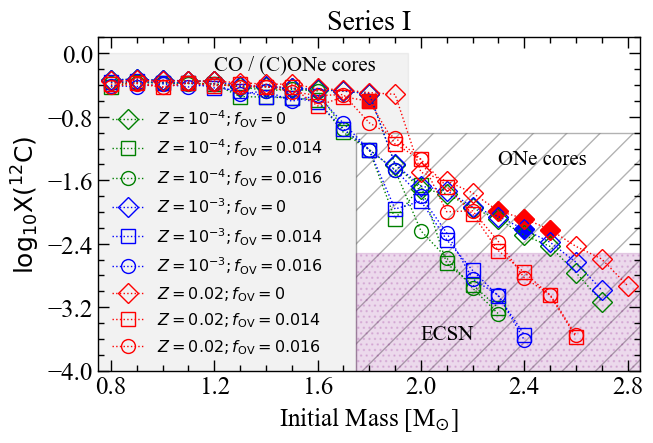

In [28]:
make_canvas(clear=True)
s=8
fig, ax = plt.subplots()
ax.set_xlabel(r'Initial Mass [M$_{\odot}$]')
ax.set_ylabel(r'$\rm \log_{10} X(^{12}C)$')

ax.set_xlim(0.75, 2.85)
ax.set_ylim(-4.0, 0.2)
#ax.set_ylim(-4.0, 0.8)

ax.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.plot(zlow_f0_mass[:-8], np.log10(zlow_f0_c12[:-8]), ':Dg', fillstyle='none', lw=1, label=r'$Z=10^{-4};f_{\rm OV} = 0$', markersize=10)
plt.plot(zlow_f1_mass[:-12], np.log10(zlow_f1_c12[:-12]), ':sg', fillstyle='none', lw=1, label=r'$Z=10^{-4};f_{\rm OV} = 0.014$', markersize=10)
plt.plot(zlow_f2_mass[:-12], np.log10(zlow_f2_c12[:-12]), ':og', fillstyle='none', lw=1, label=r'$Z=10^{-4};f_{\rm OV} = 0.016$', markersize=10)

plt.plot(zim_f0_mass[:-8], np.log10(zim_f0_c12[:-8]), ':Db', fillstyle='none', lw=1, label=r'$Z=10^{-3};f_{\rm OV} = 0$', markersize=10)
plt.plot(zim_f1_mass[:-11], np.log10(zim_f1_c12[:-11]), ':sb', fillstyle='none', lw=1, label=r'$Z=10^{-3};f_{\rm OV} = 0.014$', markersize=10)
plt.plot(zim_f2_mass[:-11], np.log10(zim_f2_c12[:-11]), ':ob', fillstyle='none', lw=1, label=r'$Z=10^{-3};f_{\rm OV} = 0.016$', markersize=10)

plt.plot(zsol_f0_mass[:-7], np.log10(zsol_f0_c12[:-7]), ':Dr', fillstyle='none', lw=1, label=r'$Z=0.02;f_{\rm OV} = 0$', markersize=10)
plt.plot(zsol_f1_mass[:-9], np.log10(zsol_f1_c12[:-9]), ':sr', fillstyle='none', lw=1, label=r'$Z=0.02;f_{\rm OV} = 0.014$', markersize=10)
plt.plot(zsol_f2_mass[:-9], np.log10(zsol_f2_c12[:-9]), ':or', fillstyle='none', lw=1, label=r'$Z=0.02;f_{\rm OV} = 0.016$', markersize=10)


plt.scatter(2.4, np.log10(0.006038270715046643), c='b', marker='D', s=100)
plt.scatter(1.8, np.log10(0.2488797993799279), c='r', marker='s', s=100)

plt.scatter(2.3, np.log10(0.010252154043324494), c='r', marker='D', s=100)
plt.scatter(2.4, np.log10(0.008231361830604788), c='r', marker='D', s=100)
plt.scatter(2.5, np.log10(0.005998299036129693), c='r', marker='D', s=100)


# plt.fill([1.8, 2.8, 2.8, 1.8],[-4.0, -4.0, np.log10(0.002323), np.log10(0.002323)], color='purple', hatch='*', alpha=0.15)
# plt.fill_betweenx([-4.0, 0.0], [0.8], [1.8], alpha=0.1, color='grey')
# plt.fill_betweenx([-1.0, 0.0],[1.807],[1.9], alpha=0.1, color='grey')
# plt.fill([1.8, 2.8, 2.8, 1.8],[-4.0, -4.0, -1.0, -1.0],color='k', hatch='/', fill=False, alpha=0.3)

plt.fill([0.75, 1.75, 1.75, 1.95, 1.95, 0.75], [-5.0, -5.0, -1.0, -1.0, 0.0, 0.0], alpha=0.1, color='grey')
plt.fill([1.75, 2.85, 2.85, 1.75],[-5.0, -5.0, -1.0, -1.0],color='k', hatch='/', fill=False, alpha=0.3)
plt.fill([1.75, 2.85, 2.85, 1.75],[-5.0, -5.0, np.log10(0.003), np.log10(0.003)], color='purple', hatch='...', alpha=0.15)




plt.text(1.2, -0.2, 'CO / (C)ONe cores', fontsize=15)
plt.text(2.3, -1.4, 'ONe cores', fontsize=15)
plt.text(2.0, -3.6, 'ECSN', fontsize=15)



plt.title('Series I', size=20)
plt.legend(ncol=1,prop={'size':11.5}, frameon=False, loc='lower left')

#plt.savefig('/Users/schanlar/Desktop/asdf/final_figures_draft/c12_distribution_series1.png', dpi=300, bbox_inches='tight')

In [29]:
with open('/Users/schanlar/Desktop/Projects/COSNe-Ia/TNS_HeStars/scripts/series2_isos_distribution_log.txt') as s2f:
    for line in s2f:
        hasReachedEnd = False
        
        if line.startswith('PROCEEDING'):
            model_info = line.split(' ')[-1]
            
            m_init, metallicity, eta = model_info.split('_')[0], model_info.split('_')[1], model_info.split('_')[2].split('\n')[0]
            continue
        
        if line.startswith('C12'):
            c12 = line.split(' ')[-1]
            continue
           # print('C12:', c12)
            
        elif line.startswith('O16'):
            o16 = line.split(' ')[-1]
            continue
           # print('O16:', o16)
        
        elif line.startswith('Ne20'):
            ne20 = line.split(' ')[-1]
            continue
           # print('Ne20:', ne20)
            
        elif line.startswith('Mg25'):
            mg25 = line.split(' ')[-1]
            continue
           # print('Mg25:', mg25)
            
        elif line.startswith('Na25'):
            na25 = line.split(' ')[-1]
            continue
           # print('Na25:', na25)
            
        elif line.startswith('Na23'):
            na23 = line.split(' ')[-1]
            continue
            # print('Na23:', na23)
            
        elif line.startswith('Ne23'):
            ne23 = line.split(' ')[-1]
            hasReachedEnd = True
            # print('Ne23:', ne23)
            
        
        if hasReachedEnd:
           
            if metallicity == '0.0200' and eta == '0.1000':
                
                eta0p1_mass.append(float(m_init))
                
                eta0p1_c12.append(float(c12))
                eta0p1_o16.append(float(o16))
                eta0p1_ne20.append(float(ne20))
                eta0p1_mg25.append(float(mg25))
                eta0p1_na25.append(float(na25))
                eta0p1_na23.append(float(na23))
                eta0p1_ne23.append(float(ne23))
                

            elif metallicity == '0.0200' and eta == '0.2500':

                eta0p25_mass.append(float(m_init))
                
                eta0p25_c12.append(float(c12))
                eta0p25_o16.append(float(o16))
                eta0p25_ne20.append(float(ne20))
                eta0p25_mg25.append(float(mg25))
                eta0p25_na25.append(float(na25))
                eta0p25_na23.append(float(na23))
                eta0p25_ne23.append(float(ne23))

            elif metallicity == '0.0200' and eta == '0.5000':

                eta0p5_mass.append(float(m_init))
                
                eta0p5_c12.append(float(c12))
                eta0p5_o16.append(float(o16))
                eta0p5_ne20.append(float(ne20))
                eta0p5_mg25.append(float(mg25))
                eta0p5_na25.append(float(na25))
                eta0p5_na23.append(float(na23))
                eta0p5_ne23.append(float(ne23))

            elif metallicity == '0.0200' and eta == '0.8000':
                
                eta0p8_mass.append(float(m_init))
                
                eta0p8_c12.append(float(c12))
                eta0p8_o16.append(float(o16))
                eta0p8_ne20.append(float(ne20))
                eta0p8_mg25.append(float(mg25))
                eta0p8_na25.append(float(na25))
                eta0p8_na23.append(float(na23))
                eta0p8_ne23.append(float(ne23))
                
            elif metallicity == '0.0200' and eta == '1.0000':
                
                eta1p0_mass.append(float(m_init))
                
                eta1p0_c12.append(float(c12))
                eta1p0_o16.append(float(o16))
                eta1p0_ne20.append(float(ne20))
                eta1p0_mg25.append(float(mg25))
                eta1p0_na25.append(float(na25))
                eta1p0_na23.append(float(na23))
                eta1p0_ne23.append(float(ne23))
                
            elif metallicity == '0.0200' and eta == '1.5800':
                
                eta1p58_mass.append(float(m_init))
                
                eta1p58_c12.append(float(c12))
                eta1p58_o16.append(float(o16))
                eta1p58_ne20.append(float(ne20))
                eta1p58_mg25.append(float(mg25))
                eta1p58_na25.append(float(na25))
                eta1p58_na23.append(float(na23))
                eta1p58_ne23.append(float(ne23))

Text(0.5, 1.0, 'Series II')

<Figure size 700x432.624 with 0 Axes>

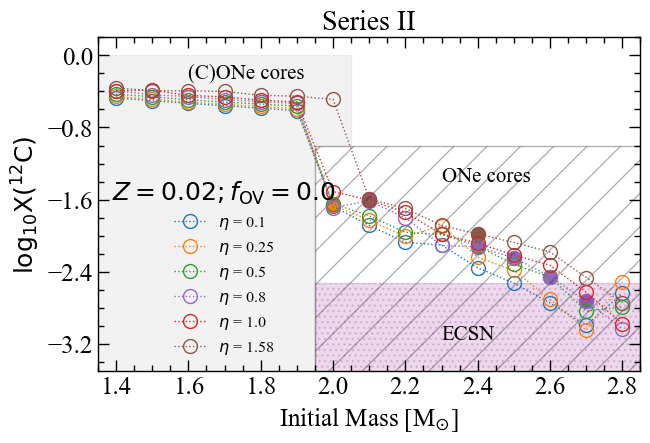

In [30]:
make_canvas(clear=True)
s=100

fig, ax = plt.subplots()
ax.set_xlabel(r'Initial Mass [M$_{\odot}$]')
ax.set_ylabel(r'$\rm \log_{10} X(^{12}C)$')

ax.set_xlim(1.35, 2.85)
ax.set_ylim(-3.5, 0.2)

ax.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator())


# plt.plot(initial_masses_grid_s2[:-8], np.log10(eta0p1_c12[:-8]), '-Dr', fillstyle='none', label = r'$\eta = 0.1$', lw=1)
# plt.plot(initial_masses_grid_s2[:-8], np.log10(eta0p25_c12[:-8]), '--Dr', fillstyle='none', label = r'$\eta = 0.25$', lw=1)
# plt.plot(initial_masses_grid_s2[:-8], np.log10(eta0p5_c12[:-8]), '-.Dr', fillstyle='none', label = r'$\eta = 0.5$', lw=1)
# plt.plot(initial_masses_grid_s2[:-7], np.log10(eta0p8_c12[:-7]), ':Dr', fillstyle='none', label = r'$\eta = 0.8$', lw=1)
# plt.plot(initial_masses_grid, np.log10(eta1p0_c12),  c='magenta', marker='D', ls='--', fillstyle='none', lw=1)
# plt.plot(initial_masses_grid_s2[:-7], np.log10(eta1p58_c12[:-7]), linestyle=linestyles_dict['loosely dashdotdotted'], c='r', marker='D', fillstyle='none', label = r'$\eta = 1.58$', lw=1)

plt.plot(eta0p1_mass[:-6], np.log10(eta0p1_c12[:-6]), ':o', fillstyle='none', lw=1, c='tab:blue', label = r'$\eta$ = 0.1', markersize=10)
plt.plot(eta0p25_mass[:-7], np.log10(eta0p25_c12[:-7]), ':o', fillstyle='none', lw=1, c='tab:orange', label = r'$\eta$ = 0.25', markersize=10)
plt.plot(eta0p5_mass[:-7], np.log10(eta0p5_c12[:-7]), ':o', fillstyle='none', lw=1, c='tab:green', label = r'$\eta$ = 0.5', markersize=10)
plt.plot(eta0p8_mass[:-7], np.log10(eta0p8_c12[:-7]), ':o', fillstyle='none', lw=1, c='tab:purple', label = r'$\eta$ = 0.8', markersize=10)
plt.plot(eta1p0_mass[:-7], np.log10(eta1p0_c12[:-7]), ':o', fillstyle='none', lw=1, c='tab:red', label = r'$\eta$ = 1.0', markersize=10)
plt.plot(eta1p58_mass[:-7], np.log10(eta1p58_c12[:-7]), ':o', fillstyle='none', lw=1, c='tab:brown', label = r'$\eta$ = 1.58', markersize=10)

plt.scatter(2.0, np.log10(0.021775086072803578), c='tab:orange', marker='o', s=s)

plt.scatter(2.4, np.log10(0.0074820485088032285), c='tab:purple', marker='o', s=s)
plt.scatter(2.5, np.log10(0.005654550452923077), c='tab:purple', marker='o', s=s)
plt.scatter(2.6, np.log10(0.003505638494871924), c='tab:purple', marker='o', s=s)
plt.scatter(2.7, np.log10(0.001869466564631306), c='tab:purple', marker='o', s=s)

plt.scatter(2.1, np.log10(0.025398965841630386), c='tab:brown', marker='o', s=s)
plt.scatter(2.4, np.log10(0.0104107118736928), c='tab:brown', marker='o', s=s)

# plt.scatter(2.3, np.log10(0.01), c='k', marker='D', s=100)
# plt.scatter(2.4, np.log10(0.0082), c='k', marker='D', s=100)
# plt.scatter(2.5, np.log10(0.005998299036129693), c='k', marker='D', s=100)

# plt.fill([1.4, 1.9, 2.0, 2.0, 1.4], [-4.0, -4.0, -1.0, 0.0, 0.0], alpha=0.1, color='grey')
# plt.fill([1.9, 2.8, 2.8, 2.0], [-4.0, -4.0, -1.0, -1.0], color='k', hatch='/', fill=False, alpha=0.3)
# plt.fill([1.9, 2.8, 2.8, 1.95], [-4.0, -4.0, np.log10(0.002323), np.log10(0.002323)], 
#          color='purple', hatch='*', alpha=0.15)

plt.fill([1.3, 1.95, 1.95, 2.05, 2.05, 1.3], [-4.0, -4.0, -1.0, -1.0, 0.0, 0.0], alpha=0.1, color='grey')
plt.fill([1.95, 2.85, 2.85, 1.95], [-4.0, -4.0, -1.0, -1.0], color='k', hatch='/', fill=False, alpha=0.3)
# plt.fill([2.0, 2.8, 2.8, 2.0], [-4.0, -4.0, np.log10(0.002323), np.log10(0.002323)], 
#          color='purple', hatch='*', alpha=0.15)


plt.fill([1.95, 2.85, 2.85, 1.95], [-4.0, -4.0, np.log10(0.003), np.log10(0.003)], 
         color='purple', hatch='...', alpha=0.15)

# plt.fill_betweenx([-4.0, 0.0], [1.4], [2.0], alpha=0.1, color='grey')

# plt.fill([2.0, 2.8, 2.8, 2.0],[-4.0, -4.0, 0.0, 0.0],color='k', hatch='/', fill=False, alpha=0.3)
# plt.fill([2.0, 2.8, 2.8, 2.0],[-4.0, -4.0, np.log10(0.002323), np.log10(0.002323)], color='purple', hatch='*', alpha=0.15)


plt.text(1.6, -0.25, '(C)ONe cores', fontsize=15)
plt.text(2.3, -1.4, 'ONe cores', fontsize=15)
plt.text(2.3, -3.15, 'ECSN', fontsize=15)


plt.legend(prop={'size':11.5}, frameon=False, loc='lower left', title=r'$Z = 0.02;f_{\rm OV} = 0.0$')
plt.title('Series II', size=20)

#plt.savefig('/Users/schanlar/Desktop/asdf/final_figures_draft/c12_distribution_series2.png', dpi=300, bbox_inches='tight')

In [31]:
# t = mr.MesaLogDir('/Volumes/SavvasExternal/aifa_models/full_grid_logfiles/2.5000_0.0200_0.0000/LOGS')
t = mr.MesaLogDir('/Volumes/SavvasExternal/zsol_eta0p8/2.7000_0.0200_0.8000/LOGS')

ht = t.history

for idx, val in enumerate(ht.data('log_center_Rho')):
    
#     if val == max(ht.data('log_center_Rho')):
#         print('Max density:', val)
#         max_mnum = ht.data('model_number')[idx]
#         print('Model number:', max_mnum)
#         break
        
    if math.isclose(val, 9.0, abs_tol=0.09):
        print('Rho9 density:', val)
        max_mnum = ht.data('model_number')[idx]
        print('Model number:', max_mnum)
        break
        
        
        
if t.have_profile_with_model_number(max_mnum):
    pt = t.profile_data(model_number=max_num)
    
    # Find the core mass based on the Pgas/Pdeg ratio
    # for the given profile
    Pdeg = 10 ** pt.data("logP") - pt.data("Pgas")
    P_ratio = pt.data("Pgas") / Pdeg

    try:
        foundCoreMassWithPratio = False
        for i in range(len(P_ratio)):
            if math.isclose(P_ratio[i], 1.0, abs_tol=0.05):
                masscut = round(pt.data("mass")[i], 3)
                foundCoreMassWithPratio = True
    except Exception as e:
        print(e)

    if foundCoreMassWithPratio:
        print("Core mass estimated with Pratio")
    else:
        mask = 0.80 * max(pt.data("logP"))
        masscut = round(pt.data("mass")[np.where(logP < mask)][-1], 3)
        print("Core mass estimated with the pressure profile")
        
    for idx, val in enumerate(ht.data('model_number')):
        if val == 20000:
            print('Pressure estimate at: ', ht.data('log_center_Rho')[idx])
            break

    print('Core mass estimate: ', masscut)
    
    filt = np.where(pt.data('mass') <= masscut)
    filt = filt[0][0]
    print('C12 distribution in core', sum(pt.data('dq')[filt:]*pt.data('c12')[filt:]))
    print('O16 distribution in core', sum(pt.data('dq')[filt:]*pt.data('o16')[filt:]))
    print('Ne20 distribution in core', sum(pt.data('dq')[filt:]*pt.data('ne20')[filt:]))

    print('Mg25 distribution in core', sum(pt.data('dq')[filt:]*pt.data('mg25')[filt:]))
    print('Na25 distribution in core', sum(pt.data('dq')[filt:]*pt.data('na25')[filt:]))

    print('Na23 distribution in core', sum(pt.data('dq')[filt:]*pt.data('na23')[filt:]))
    print('Ne23 distribution in core', sum(pt.data('dq')[filt:]*pt.data('ne23')[filt:]))
    
    print('Ye avg in core', sum(pt.data('dq')[filt:]*pt.data('ye')[filt:]))
    
else:
    print('There is no profile that much the model number for Rho9!')
    print('Trying to load the nearest profile!')

    models_nums = t.model_numbers
    print('Available profiles for models: ', models_nums)


    new_maxRho_model_number = find_nearest(models_nums, max_mnum)
    

    for idx, value in enumerate(ht.data('model_number')):
        if new_maxRho_model_number == value:
            print('Estimation for density: ', ht.data('log_center_Rho')[idx])

    try:
        pt = t.profile_data(model_number=new_maxRho_model_number)
        print(f'max Rho profile loaded! -> Model number {new_maxRho_model_number}')
    except Exception as e:
        print(e)
        
    # Find the core mass based on the Pgas/Pdeg ratio
    # for the given profile
    Pdeg = 10 ** pt.data("logP") - pt.data("Pgas")
    P_ratio = pt.data("Pgas") / Pdeg

    try:
        foundCoreMassWithPratio = False
        for i in range(len(P_ratio)):
            if math.isclose(P_ratio[i], 1.0, abs_tol=0.05):
                masscut = round(pt.data("mass")[i], 3)
                foundCoreMassWithPratio = True
    except Exception as e:
        print(e)

    if foundCoreMassWithPratio:
        print("Core mass estimated with Pratio")
    else:
        mask = 0.80 * max(pt.data("logP"))
        masscut = round(pt.data("mass")[np.where(logP < mask)][-1], 3)
        print("Core mass estimated with the pressure profile")
        
#     for idx, val in enumerate(ht.data('model_number')):
#         if val == 20000:
#             print('Density estimate at: ', ht.data('log_center_Rho')[idx])
#             break

    print('Core mass estimate: ', masscut)
    
    filt = np.where(pt.data('mass') <= masscut)
    filt = filt[0][0]
    print('C12 distribution in core', sum(pt.data('dq')[filt:]*pt.data('c12')[filt:]))
    print('O16 distribution in core', sum(pt.data('dq')[filt:]*pt.data('o16')[filt:]))
    print('Ne20 distribution in core', sum(pt.data('dq')[filt:]*pt.data('ne20')[filt:]))

    print('Mg25 distribution in core', sum(pt.data('dq')[filt:]*pt.data('mg25')[filt:]))
    print('Na25 distribution in core', sum(pt.data('dq')[filt:]*pt.data('na25')[filt:]))

    print('Na23 distribution in core', sum(pt.data('dq')[filt:]*pt.data('na23')[filt:]))
    print('Ne23 distribution in core', sum(pt.data('dq')[filt:]*pt.data('ne23')[filt:]))
    
    print('Ye avg in core', (sum(pt.data('dq')[filt:]*pt.data('ye')[filt:])) * (pt.data('mass')[0] / masscut))
    print('Ye avg in star', sum(pt.data('dq')*pt.data('ye')))

Rho9 density: 8.910020092300325
Model number: 20095
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Available profiles for models:  [  705   732  1000  2000  3000  4000  5000  6000  7000  8000  9000 10000
 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 20650 20700
 20750 20800 20850 20900 20950 21000 21050 21100 21150 21200 21250 21300
 21350 21400 21450 21500 21550 21600 21650 21700 21750 21800 21850 21900
 21950 22000 22050 22100 22150 22200 22250 22300 22350 22400 22450 22500
 22550 22600 22650 22700 22750 22800 22850 22900 22950 23000 23050 23100
 23150 23200 23250 23300 23350 23400 23450 23500 23550 23600 23650 23700
 23750 23800 23850 23900 23950 24000 24050 24100 24150 24200 24250 24300
 24350 24400 24450 24460]
Estimation for density:  8.906934427263753
max Rho profile loaded! -> Model number 20000
Core mass estimated with Pratio
Core mass estimate:  1.314
C12 distribution in core 0.002322745021809076
O16 distribution in

In [32]:
pt = t.profile_data()

Pdeg = 10 ** pt.data("logP") - pt.data("Pgas")
P_ratio = pt.data("Pgas") / Pdeg
logP = pt.data("logP")

try:
    foundCoreMassWithPratio = False
    for i in range(len(P_ratio)):
        if math.isclose(P_ratio[i], 1.0, abs_tol=0.05):
            masscut = round(pt.data("mass")[i], 3)
            foundCoreMassWithPratio = True
except Exception as e:
    print(e)

if foundCoreMassWithPratio:
    print("Core mass estimated with Pratio")
else:
    mask = 0.80 * max(pt.data("logP"))
    masscut = round(pt.data("mass")[np.where(logP < mask)][-1], 3)
    print("Core mass estimated with the pressure profile")

#     for idx, val in enumerate(ht.data('model_number')):
#         if val == 20000:
#             print('Density estimate at: ', ht.data('log_center_Rho')[idx])
#             break

print('Core mass estimate: ', masscut)
print('Density:', ht.data('log_center_Rho')[-1])

filt = np.where(pt.data('mass') <= masscut)
filt = filt[0][0]
print('C12 distribution in core', sum(pt.data('dq')[filt:]*pt.data('c12')[filt:]))
print('O16 distribution in core', sum(pt.data('dq')[filt:]*pt.data('o16')[filt:]))
print('Ne20 distribution in core', sum(pt.data('dq')[filt:]*pt.data('ne20')[filt:]))

print('Mg25 distribution in core', sum(pt.data('dq')[filt:]*pt.data('mg25')[filt:]))
print('Na25 distribution in core', sum(pt.data('dq')[filt:]*pt.data('na25')[filt:]))

print('Na23 distribution in core', sum(pt.data('dq')[filt:]*pt.data('na23')[filt:]))
print('Ne23 distribution in core', sum(pt.data('dq')[filt:]*pt.data('ne23')[filt:]))

print('Ye avg in core', (sum(pt.data('dq')[filt:]*pt.data('ye')[filt:])) * (pt.data('mass')[0] / masscut))
print('Ye avg in star', sum(pt.data('dq')*pt.data('ye')))

Core mass estimated with the pressure profile
Core mass estimate:  1.37
Density: 10.061119441784609
C12 distribution in core 2.8758657768660477e-05
O16 distribution in core 0.39397138660119674
Ne20 distribution in core 0.4197883176871997
Mg25 distribution in core 0.000708441319209188
Na25 distribution in core 0.00044791461641459905
Na23 distribution in core 0.027259226642292942
Ne23 distribution in core 0.03127527524726059
Ye avg in core 0.494485534969846
Ye avg in star 0.4945910701528688


<ipython-input-32-38cf01faf1a0>:4: RuntimeWarning: divide by zero encountered in true_divide
  P_ratio = pt.data("Pgas") / Pdeg


4.016724491398098e-05
2.8758657768660477e-05
1.213148427801613


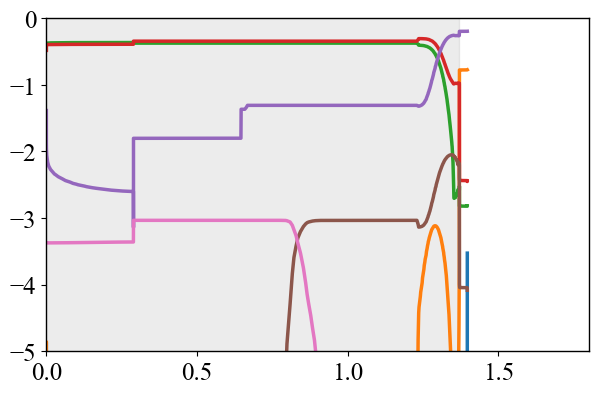

In [33]:
make_canvas(clear=True)

plt.ylim([-5, 0])
plt.xlim([0.0, 1.8])

# The degenerate core
plt.fill([-1.0, masscut, masscut, -1.0],[-6.0, -6.0, 0.0, 0.0], alpha=0.15, color='grey')

plt.plot(pt.data('mass'), np.log10(pt.data('he4')))
plt.plot(pt.data('mass'), np.log10(pt.data('c12')))
plt.plot(pt.data('mass'), np.log10(pt.data('o16')))
plt.plot(pt.data('mass'), np.log10(pt.data('ne20')))
plt.plot(pt.data('mass'), np.log10(pt.data('mg24')))
plt.plot(pt.data('mass'), np.log10(pt.data('mg25')))
plt.plot(pt.data('mass'), np.log10(pt.data('na25')))

print((pt.data('dq')[filt:]*pt.data('c12')[filt:]).sum()*pt.data('mass')[0])
print(sum(pt.data('dq')[filt:]*pt.data('c12')[filt:]))

print(((pt.data('dq')[filt:]*pt.data('he4')[filt:])).sum()*pt.data('mass')[0] + ((pt.data('dq')[filt:]*pt.data('c12')[filt:])).sum()*pt.data('mass')[0] +
      ((pt.data('dq')[filt:]*pt.data('o16')[filt:])).sum()*pt.data('mass')[0] + ((pt.data('dq')[filt:]*pt.data('ne20')[filt:])).sum()*pt.data('mass')[0] + 
      ((pt.data('dq')[filt:]*pt.data('mg24')[filt:])).sum()*pt.data('mass')[0] + ((pt.data('dq')[filt:]*pt.data('mg25')[filt:])).sum()*pt.data('mass')[0] +
     ((pt.data('dq')[filt:]*pt.data('na22')[filt:])).sum()*pt.data('mass')[0])

## Surface abundance

In [34]:
history_path = os.path.join('/Volumes/SavvasExternal/aifa_models/representatives', '2.5000_0.0200_0.0000/history.data')
profile = mr.MesaData(history_path).data
max_age = max(profile("star_age"))
remaining_time_func = lambda x: np.log10(max(x)+0.01 - x)

In [35]:
h = mr.MesaData(history_path)
print(h.bulk_names)

('model_number', 'star_age', 'star_mass', 'log_abs_mdot', 'log_rotational_mdot_boost', 'log_dt', 'num_zones', 'log_total_angular_momentum', 'conv_mx1_top', 'conv_mx1_bot', 'conv_mx2_top', 'conv_mx2_bot', 'mx1_top', 'mx1_bot', 'mx2_top', 'mx2_bot', 'epsnuc_M_1', 'epsnuc_M_2', 'epsnuc_M_3', 'epsnuc_M_4', 'epsnuc_M_5', 'epsnuc_M_6', 'epsnuc_M_7', 'epsnuc_M_8', 'he_core_mass', 'c_core_mass', 'o_core_mass', 'si_core_mass', 'fe_core_mass', 'kh_timescale', 'log_LH', 'log_LHe', 'log_LZ', 'log_Lnuc', 'log_Lneu', 'log_L', 'log_Teff', 'log_R', 'log_g', 'surf_avg_j_rot', 'surf_avg_omega', 'surf_avg_omega_crit', 'surf_avg_omega_div_omega_crit', 'surf_avg_v_rot', 'surf_avg_v_crit', 'surf_avg_v_div_v_crit', 'surf_avg_Lrad_div_Ledd', 'surf_avg_logT', 'surf_avg_logRho', 'surf_avg_opacity', 'surf_r_equatorial_div_r', 'surf_r_polar_div_r', 'log_center_T', 'log_center_Rho', 'log_center_P', 'center_degeneracy', 'center_ye', 'center_entropy', 'center_eps_grav', 'center_eps_nuc', 'center_non_nuc_neu', 'cente

<Figure size 700x432.624 with 0 Axes>

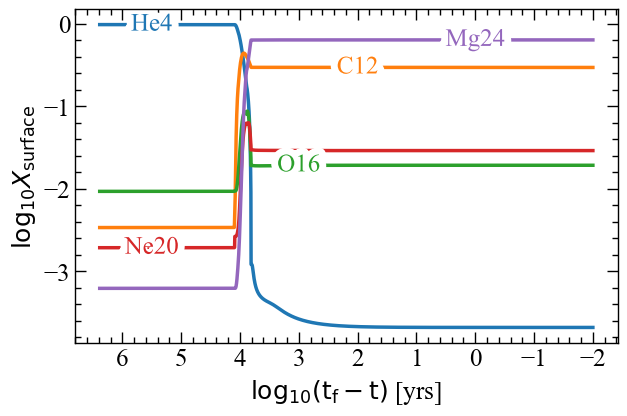

In [36]:
from labellines import labelLine, labelLines
make_canvas(clear=True)
fig, ax = plt.subplots()

#ax.set_ylim([-0.1, 1.1])
ax.set_xlabel(r"$\rm \log_{10} (t_f-t)$ [yrs]")
ax.set_ylabel(r"$\log_{10} X_{\rm surface}$")
ax.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.plot(remaining_time_func(profile("star_age")), np.log10(profile('surface_he4')), lw=2.5, label='He4')
ax.plot(remaining_time_func(profile("star_age")), np.log10(profile('surface_c12')), lw=2.5, label='C12')
ax.plot(remaining_time_func(profile("star_age")), np.log10(profile('surface_o16')), lw=2.5, label='O16')
ax.plot(remaining_time_func(profile("star_age")), np.log10(profile('surface_ne20')), lw=2.5, label='Ne20')
ax.plot(remaining_time_func(profile("star_age")), np.log10(profile('surface_mg24')), lw=2.5, label='Mg24')
# ax.plot(remaining_time_func(profile("star_age")), profile('surface_si28'), lw=2.5, label='Si28')




xvals = [5.5, 2.0, 3.0, 5.5, 0.0]
labelLines(ax.get_lines(), drop_label=True, outline_width=10, xvals=xvals) 


plt.gca().invert_xaxis()

# plt.savefig('/Users/schanlar/Desktop/TNS_HeStars_figures/surface_abundance_evolution_2p5.pdf', dpi=300, bbox_inches='tight')

## Radius evolution

In [37]:
grid_dir = '/Volumes/SavvasExternal/aifa_models/full_grid_logfiles'

initial_mass_zlow_f0, initial_mass_zlow_f1, initial_mass_zlow_f2 = [], [],[]
initial_mass_zim_f0, initial_mass_zim_f1, initial_mass_zim_f2 = [], [], []
initial_mass_zsol_f0, initial_mass_zsol_f1, initial_mass_zsol_f2 = [], [], []

max_radius_zlow_f0, max_radius_zlow_f1, max_radius_zlow_f2 = [], [], []
max_radius_zim_f0, max_radius_zim_f1, max_radius_zim_f2 = [], [], []
max_radius_zsol_f0, max_radius_zsol_f1, max_radius_zsol_f2 = [], [], []

In [38]:
for path in glob.glob(os.path.join(grid_dir, '*')):
    
    model_info = path.split('/')[-1]
    initial_mass = float(model_info.split('_')[0])
    z = str(model_info.split('_')[1])
    fov = str(model_info.split('_')[2])
    
    
    log_dir = os.path.join(path, 'LOGS')
    h = mr.MesaData(os.path.join(log_dir, 'history.data')).data
    
    max_radius = max(h('log_R'))
    
    if z == '0.0001' and fov == '0.0000':
        initial_mass_zlow_f0.append(initial_mass)
        max_radius_zlow_f0.append(max_radius)
        print('Model ', model_info, ': OK!')
        
    elif z == '0.0001' and fov == '0.0140':
        initial_mass_zlow_f1.append(initial_mass)
        max_radius_zlow_f1.append(max_radius)
        print('Model ', model_info, ': OK!')
        
    elif z == '0.0001' and fov == '0.0160':
        initial_mass_zlow_f2.append(initial_mass)
        max_radius_zlow_f2.append(max_radius)
        print('Model ', model_info, ': OK!')
        
    elif z == '0.0010' and fov == '0.0000':
        initial_mass_zim_f0.append(initial_mass)
        max_radius_zim_f0.append(max_radius)
        print('Model ', model_info, ': OK!')
        
    elif z == '0.0010' and fov == '0.0140':
        initial_mass_zim_f1.append(initial_mass)
        max_radius_zim_f1.append(max_radius)
        print('Model ', model_info, ': OK!')
        
    elif z == '0.0010' and fov == '0.0160':
        initial_mass_zim_f2.append(initial_mass)
        max_radius_zim_f2.append(max_radius)
        print('Model ', model_info, ': OK!')
        
    elif z == '0.0200' and fov == '0.0000':
        initial_mass_zsol_f0.append(initial_mass)
        max_radius_zsol_f0.append(max_radius)
        print('Model ', model_info, ': OK!')
        
    elif z == '0.0200' and fov == '0.0140':
        initial_mass_zsol_f1.append(initial_mass)
        max_radius_zsol_f1.append(max_radius)
        print('Model ', model_info, ': OK!')
        
    elif z == '0.0200' and fov == '0.0160':
        initial_mass_zsol_f2.append(initial_mass)
        max_radius_zsol_f2.append(max_radius)
        print('Model ', model_info, ': OK!')
        
    else:
        print('Problem with model: ', model_info)
        break

Model  0.8000_0.0001_0.0000 : OK!
Model  0.8000_0.0001_0.0140 : OK!
Model  0.8000_0.0001_0.0160 : OK!
Model  0.8000_0.0010_0.0000 : OK!
Model  0.8000_0.0010_0.0140 : OK!
Model  0.8000_0.0010_0.0160 : OK!
Model  0.8000_0.0200_0.0000 : OK!
Model  0.8000_0.0200_0.0140 : OK!
Model  0.8000_0.0200_0.0160 : OK!
Model  0.9000_0.0001_0.0000 : OK!
Model  0.9000_0.0001_0.0140 : OK!
Model  0.9000_0.0001_0.0160 : OK!
Model  0.9000_0.0010_0.0000 : OK!
Model  0.9000_0.0010_0.0140 : OK!
Model  0.9000_0.0010_0.0160 : OK!
Model  0.9000_0.0200_0.0000 : OK!
Model  0.9000_0.0200_0.0140 : OK!
Model  0.9000_0.0200_0.0160 : OK!
Model  1.0000_0.0001_0.0000 : OK!
Model  1.0000_0.0001_0.0140 : OK!
Model  1.0000_0.0001_0.0160 : OK!
Model  1.0000_0.0010_0.0000 : OK!
Model  1.0000_0.0010_0.0140 : OK!
Model  1.0000_0.0010_0.0160 : OK!
Model  1.0000_0.0200_0.0000 : OK!
Model  1.0000_0.0200_0.0140 : OK!
Model  1.0000_0.0200_0.0160 : OK!
Model  1.1000_0.0001_0.0000 : OK!
Model  1.1000_0.0001_0.0140 : OK!
Model  1.1000_

Model  3.4000_0.0200_0.0140 : OK!
Model  3.4000_0.0200_0.0160 : OK!
Model  3.5000_0.0001_0.0000 : OK!
Model  3.5000_0.0001_0.0140 : OK!
Model  3.5000_0.0001_0.0160 : OK!
Model  3.5000_0.0010_0.0000 : OK!
Model  3.5000_0.0010_0.0140 : OK!
Model  3.5000_0.0010_0.0160 : OK!
Model  3.5000_0.0200_0.0000 : OK!
Model  3.5000_0.0200_0.0140 : OK!
Model  3.5000_0.0200_0.0160 : OK!


<Figure size 700x432.624 with 0 Axes>

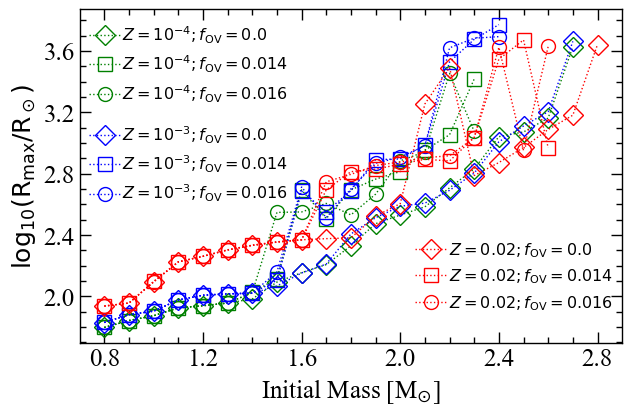

In [39]:
make_canvas(clear=True)
s=10
fig, ax = plt.subplots()
ax.set_xlabel(r'Initial Mass [M$_{\odot}$]')
ax.set_ylabel(r'$\rm \log_{10} \left(R_{\rm max} / R_\odot \right)$')

#ax.set_xlim(0.75, 2.85)
#ax.set_ylim(-4.0, 0.2)
#ax.set_ylim(-4.0, 0.8)

ax.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_minor_locator(AutoMinorLocator())

plot_lines = []

l1, = ax.plot(initial_mass_zlow_f0[:-8], max_radius_zlow_f0[:-8], ':Dg', fillstyle='none', lw=1, markersize=s)
l2, = ax.plot(initial_mass_zlow_f1[:-12], max_radius_zlow_f1[:-12], ':sg', fillstyle='none', lw=1, markersize=s)
l3, = ax.plot(initial_mass_zlow_f2[:-12], max_radius_zlow_f2[:-12], ':og', fillstyle='none', lw=1, markersize=s)
plot_lines.append([l1,l2,l3])

ax.legend(plot_lines[0], [r'$Z=10^{-4};f_{\rm OV} = 0.0$', r'$Z=10^{-4};f_{\rm OV} = 0.014$', r'$Z=10^{-4};f_{\rm OV} = 0.016$'],
          loc='upper center', frameon=False, bbox_to_anchor=(0.2, 1.0), handletextpad=0.1, prop={'size':11.5})

l1, = ax.plot(initial_mass_zim_f0[:-8], max_radius_zim_f0[:-8], ':Db', fillstyle='none', lw=1, markersize=s)
l2, = ax.plot(initial_mass_zim_f1[:-11], max_radius_zim_f1[:-11], ':sb', fillstyle='none', lw=1, markersize=s)
l3, = ax.plot(initial_mass_zim_f2[:-11], max_radius_zim_f2[:-11], ':ob', fillstyle='none', lw=1, markersize=s)
plot_lines.append([l1,l2,l3])

leg2 = Legend(ax, plot_lines[1], [r'$Z=10^{-3};f_{\rm OV} = 0.0$', r'$Z=10^{-3};f_{\rm OV} = 0.014$', r'$Z=10^{-3};f_{\rm OV} = 0.016$'],
             loc='upper center', frameon=False, bbox_to_anchor=(0.2, 0.7), handletextpad=0.1, prop={'size':11.5})
ax.add_artist(leg2)

l1, = ax.plot(initial_mass_zsol_f0[:-7], max_radius_zsol_f0[:-7], ':Dr', fillstyle='none', lw=1, markersize=s)
l2, = ax.plot(initial_mass_zsol_f1[:-9], max_radius_zsol_f1[:-9], ':sr', fillstyle='none', lw=1, markersize=s)
l3, = ax.plot(initial_mass_zsol_f2[:-9], max_radius_zsol_f2[:-9], ':or', fillstyle='none', lw=1, markersize=s)
plot_lines.append([l1,l2,l3])

leg3 = Legend(ax, plot_lines[2], [r'$Z=0.02;f_{\rm OV} = 0.0$', r'$Z=0.02;f_{\rm OV} = 0.014$', r'$Z=0.02;f_{\rm OV} = 0.016$'],
             loc='upper center', frameon=False, bbox_to_anchor=(0.8, 0.35), handletextpad=0.1, prop={'size':11.5})
ax.add_artist(leg3)

# plt.plot(initial_mass_zlow_f0[:], max_radius_zlow_f0[:], ':Dg', fillstyle='none', lw=1, label=r'$Z=10^{-4};f_{\rm OV} = 0$', markersize=s)
# plt.plot(initial_mass_zlow_f1[:], max_radius_zlow_f1[:], ':sg', fillstyle='none', lw=1, label=r'$Z=10^{-4};f_{\rm OV} = 0.014$', markersize=s)
# plt.plot(initial_mass_zlow_f2[:], max_radius_zlow_f2[:], ':og', fillstyle='none', lw=1, label=r'$Z=10^{-4};f_{\rm OV} = 0.016$', markersize=s)

# plt.plot(initial_mass_zim_f0[:], max_radius_zim_f0[:], ':Db', fillstyle='none', lw=1, label=r'$Z=10^{-3};f_{\rm OV} = 0$', markersize=s)
# plt.plot(initial_mass_zim_f1[:], max_radius_zim_f1[:], ':sb', fillstyle='none', lw=1, label=r'$Z=10^{-3};f_{\rm OV} = 0.014$', markersize=s)
# plt.plot(initial_mass_zim_f2[:], max_radius_zim_f2[:], ':ob', fillstyle='none', lw=1, label=r'$Z=10^{-3};f_{\rm OV} = 0.016$', markersize=s)

# plt.plot(initial_mass_zsol_f0[:], max_radius_zsol_f0[:], ':Dr', fillstyle='none', lw=1, label=r'$Z=0.02;f_{\rm OV} = 0$', markersize=s)
# plt.plot(initial_mass_zsol_f1[:], max_radius_zsol_f1[:], ':sr', fillstyle='none', lw=1, label=r'$Z=0.02;f_{\rm OV} = 0.014$', markersize=s)
# plt.plot(initial_mass_zsol_f2[:], max_radius_zsol_f2[:], ':or', fillstyle='none', lw=1, label=r'$Z=0.02;f_{\rm OV} = 0.016$', markersize=s)

# plt.legend(ncol=1,prop={'size':11.5}, frameon=False, loc='upper left')

# plt.savefig('/Users/schanlar/Desktop/mass_radius.pdf', dpi=300, bbox_inches='tight')

<Figure size 700x432.624 with 0 Axes>

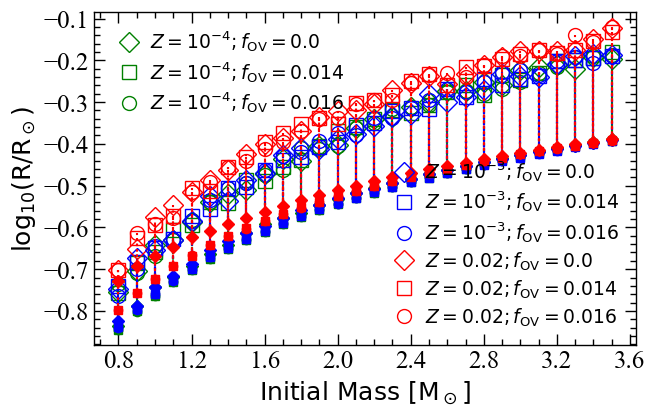

In [41]:
s=10
make_canvas(clear=True)


fig, ax = plt.subplots()
ax.set_xlabel(r'$\rm Initial \ Mass \ [M_\odot]$')
ax.set_ylabel(r'$\rm \log_{10}(R/R_\odot)$')

#ax.set_xlim(0.7, 3.6)
#ax.set_ylim(0.0, 35.0)

ax.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_major_locator(plt.MaxNLocator(8))
ax.yaxis.set_minor_locator(AutoMinorLocator())

lines = []

for path in glob.glob('/Volumes/SavvasExternal/aifa_models/he_tams/*'):
    initial_mass = float(path.split('/')[-1].split('_')[0])
    z = path.split('/')[-1].split('_')[1]
    f = path.split('/')[-1].split('_')[2]
    
    h = mr.MesaData(os.path.join(path, 'history.data'))
    
    if z == '0.0001':
        color = 'green'
    elif z == '0.0010':
        color = 'blue'
    elif z == '0.0200':
        color = 'red'
    else:
        print('Error in selecting color!')
        break
        
    if f == '0.0000':
        marker = 'D'
    elif f == '0.0140':
        marker = 's'
    elif f == '0.0160':
        marker = 'o'
    else:
        print('Error in selecting marker!')
        break
        
    if z == '0.0001' and f == '0.0000':
        label = r'$Z=10^{-4}; f_{\rm OV} = 0.0$'
    elif z == '0.0001' and f == '0.0140':
        label = r'$Z=10^{-4}; f_{\rm OV} = 0.014$'
    elif z == '0.0001' and f == '0.0160':
        label = r'$Z=10^{-4}; f_{\rm OV} = 0.016$'
    elif z == '0.0010' and f == '0.0000':
        label = r'$Z=10^{-3}; f_{\rm OV} = 0.0$'
    elif z == '0.0010' and f == '0.0140':
        label = r'$Z=10^{-3}; f_{\rm OV} = 0.014$'
    elif z == '0.0010' and f == '0.0160':
        label = r'$Z=10^{-3}; f_{\rm OV} = 0.016$'
    elif z == '0.0200' and f == '0.0000':
        label = r'$Z=0.02; f_{\rm OV} = 0.0$'
    elif z == '0.0200' and f == '0.0140':
        label = r'$Z=0.02; f_{\rm OV} = 0.0140$'
    elif z == '0.0200' and f == '0.0160':
        label = r'$Z=0.02; f_{\rm OV} = 0.016$'
    else:
        print('Error in selecting label')
        break
    
    for idx, value in enumerate(h.data('tri_alfa')):
        if value >= 0.0:
            initial_index = idx
            break
        
    lines += ax.plot([initial_mass], [h.data('log_R')[initial_index]], c = color, marker=marker, markersize=s, fillstyle='none', ls='', label=label)
    ax.plot([initial_mass], [h.data('log_R')[-1]], c = color, marker=marker, markersize=6, ls='')
    arrowline = ax.plot((initial_mass, initial_mass),(h.data('log_R')[initial_index], h.data('log_R')[-1]), c=color, lw=1.5, ls=":")[0]
    
    
ax.legend(lines[:3], [r'$Z=10^{-4}; f_{\rm OV} = 0.0$', r'$Z=10^{-4}; f_{\rm OV} = 0.014$', r'$Z=10^{-4}; f_{\rm OV} = 0.016$'],
          loc='upper left', frameon=False, prop={'size':13.5}, handletextpad=0.1,labelspacing=0.3)

leg2 = Legend(ax, lines[3:9], [r'$Z=10^{-3}; f_{\rm OV} = 0.0$', r'$Z=10^{-3}; f_{\rm OV} = 0.014$', r'$Z=10^{-3}; f_{\rm OV} = 0.016$',
                               r'$Z=0.02; f_{\rm OV} = 0.0$', r'$Z=0.02; f_{\rm OV} = 0.014$', r'$Z=0.02; f_{\rm OV} = 0.016$'],
             loc='lower right', frameon=False, prop={'size':13.5}, ncol=1, columnspacing=0.1, handletextpad=0.1, labelspacing=0.3)
ax.add_artist(leg2)



# plt.savefig('/Users/schanlar/Desktop/asdf/new/radius_vs_mass_tams.pdf', dpi=300, bbox_inches='tight')

## Final fates - Mass boundaries

In [42]:
def mass_converter_he_to_zams(masses):
    
    """Relation between He-star and original star, 
    based on Woosley (2019)"""
    
    zams_mass = []
    for mass in masses:
        zams_mass.append(round((mass/0.0385)**(1/1.603),1))
    return zams_mass

def mass_converter_zams_to_he(masses):
    
    """Relation between He-star and original star, 
    based on Woosley (2019)"""
    
    helium_cores_mass = []
    for mass in masses:
        helium_cores_mass.append(round(0.0385 * mass ** 1.603, 1))
    return helium_cores_mass 

def farmer_converter(zams_mass):
    
    """Relation between He-star and original star, 
    based on Figure 4 from Farmer (2015)"""
    
    he_core_mass = []
    for m in zams_mass:
        if m < 7.5:
            he_core_mass.append(round(0.5 * m - 2.45 ,2))
        elif m >= 7.5 and m <= 7.8:
            he_core_mass.append(round(0.565 * m ** (1.443) - 9.05 ,2))
        else:
            he_core_mass.append(round(0.375 * m - 0.934 ,2))
            
    return he_core_mass

def farmer_invert_converter(he_core_mass):
    
    """Relation between He-star and original star, 
    based on Figure 4 from Farmer (2015)"""
        
    zams_mass = []
    for m in he_core_mass:
        try:
            if m < 1.3:
                #print('M={}, entered first clause!'.format(m))
                #print('For {} the ZAMS mass is {} Msol'.format(m, round(2 * (m + 2.45) ,2)))
                zams_mass.append(round(2 * (m + 2.45) ,2))
            elif m >= 1.3 and m <= 1.9:
                #print('M={}, entered second clause!'.format(m))
                #print('For {} the ZAMS mass is {} Msol'.format(m, round(((m + 9.05)/0.565)**(1.0/1.443) ,2)))
                zams_mass.append(round(((m + 9.05)/0.565)**(1.0/1.443) ,2))
            else:
                #print('M={}, entered third clause!'.format(m))
                #print('For {} the ZAMS mass is {} Msol'.format(m, round((m + 0.934)/0.375 ,2)))
                zams_mass.append(round((m + 0.934)/0.375 ,2))
        except Exception as e:
            print(e)
            
    return zams_mass



# Same functions as above
# They take (and return) a single
# value instead of a list of values

def f1(x):
    '''Returns ZAMS mass based on He-star mass (Woosley2019)'''
    return (x/0.0385)**(1/1.603)

def f2(x):
    '''Returns He-star mass based on ZAMS mass (Woosley2019)'''
    return 0.0385 * x ** 1.603

def f3(i):
    '''Returns ZAMS mass based on He-core mass (Farmer2015)'''
    print(i)
    for m in i:
        print(m)
        if (m < 1.3):
            return 2 * (m + 2.45)
        elif (1.3 <= m <= 1.7):
            #(m >= 1.3) & (m <= 1.7)
            return ((m + 9.05)/0.565)**(1.0/1.443)
        else:
            return (m + 0.934)/0.375

def f4(i):
    '''Returns He-core mass based on ZAMS mass (Farmer2015)'''
    print(i)
    for m in i:
        print(m)
        if (m < 7.5):
            return 0.5 * m - 2.45
        elif (7.5 <= m <= 7.7):
            #(m >= 7.5) & (m <= 7.7)
            return 0.565 * m ** (1.443) - 9.05
        else:
            return 0.375 * m - 0.934


In [43]:
test1 = mass_converter_he_to_zams([6.0])
test3 = farmer_invert_converter([6.0])
print(test1, test3)
test2 = mass_converter_zams_to_he([23.3])
test4 = farmer_converter([23.3])
print(test2, test4)


zams_masses_grid = mass_converter_he_to_zams([0.7, 0.8, 0.9, 
                                             1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9,
                                             2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9,
                                             3.0, 3.1, 3.2, 3.3, 3.4, 3.5])

zams_masses_grid_farmer = farmer_invert_converter([0.7, 0.8, 0.9, 
                                             1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9,
                                             2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9,
                                             3.0, 3.1, 3.2, 3.3, 3.4, 3.5])
print(zams_masses_grid)
print(zams_masses_grid_farmer)


[23.3] [18.49]
[6.0] [7.8]
[6.1, 6.6, 7.1, 7.6, 8.1, 8.5, 9.0, 9.4, 9.8, 10.2, 10.6, 11.0, 11.4, 11.8, 12.1, 12.5, 12.8, 13.2, 13.5, 13.8, 14.2, 14.5, 14.8, 15.1, 15.5, 15.8, 16.1, 16.4, 16.7]
[6.3, 6.5, 6.7, 6.9, 7.1, 7.3, 7.5, 7.55, 7.6, 7.65, 7.7, 7.75, 7.8, 7.82, 8.09, 8.36, 8.62, 8.89, 9.16, 9.42, 9.69, 9.96, 10.22, 10.49, 10.76, 11.02, 11.29, 11.56, 11.82]


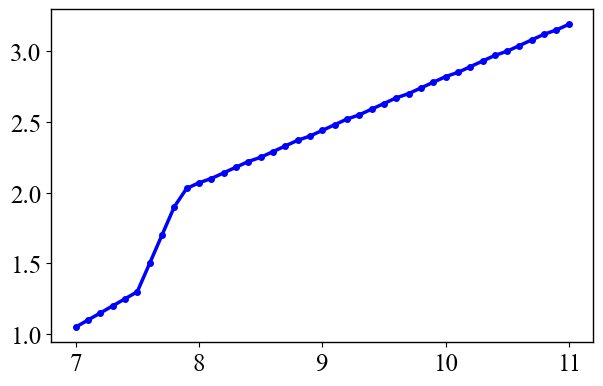

In [44]:
low_xaxis_values = [0.7, 0.8, 0.9, 
                 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9,
                 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9,
                 3.0, 3.1, 3.2, 3.3, 3.4, 3.5]
top_xaxis_values = farmer_invert_converter(low_xaxis_values)
#print(top_xaxis_values)

foo_zams = [i/10.0 for i in range(70,111)]
foo_he = farmer_converter(foo_zams)

_ = plt.plot(foo_zams, foo_he, '-ob', markersize=4)

<Figure size 1200x741.641 with 0 Axes>

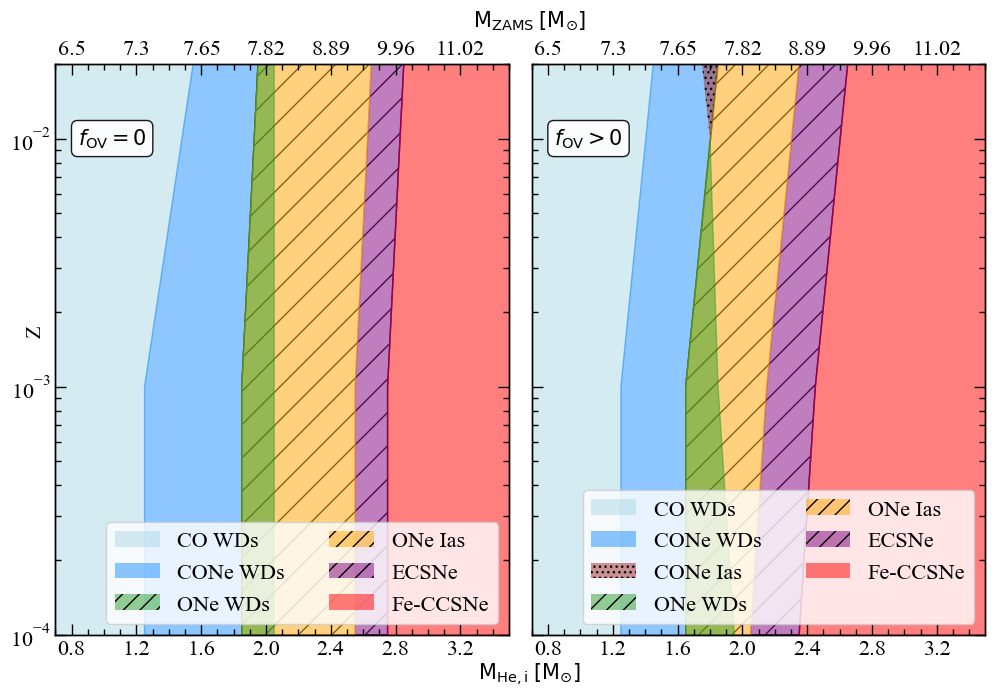

In [45]:
fontsize=16
make_canvas(fig_width=12.0, columns=1, clear=True, fontsize=fontsize)


text_cowd = 'CO WD'
text_conewd = 'CONe' + '\n' + 'WD'
#text_tns = 'Thermonuclear' + '\n' + 'ONe' + '\n' + 'explosions' + '\n' + '+' + '\n' + 'ECSN'
text_one_cores = 'ONe CORES'
text_tns = '\n \n' + 'ONe WD' + '\n' + 'or' + '\n' + 'thermonuclear' + '\n' + 'explosions'
text_ccsn = 'Fe-CCSN'
text_onewd = 'ONe' + '\n' + 'WD/TNS'



f, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, sharey=True)

# Leave some whitespace between the plots
f.subplots_adjust(wspace=0.05)

# Common axes labels
f.text(0.52, 0.93, r'$\rm M_{ZAMS}$ $\left[\rm M_{\odot} \right]$', ha='center', size = 15)
f.text(0.52, 0.05, r'$\rm M_{He,i}$ $\left[\rm M_{\odot} \right]$', ha='center', size = 15)
f.text(0.1, 0.52, r'Z', va='center', rotation='vertical', size = 15)


# Left Panel
# -----------------------------------------------
ax1.set_yscale('log')
ax1.set_xscale('linear')
ax1.set_ylim([0.0001, 0.02])
ax1.set_xlim([0.7, 3.5])

ax1.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=False, right=True)
ax1.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=False, right=True)
ax1.xaxis.set_major_locator(plt.MaxNLocator(8))
ax1.xaxis.set_minor_locator(AutoMinorLocator())

ax3 = ax1.twiny()
ax3.set_xlim(ax1.get_xlim())
ax3.tick_params(direction='in', which='major', axis='both', length=8, width=1)
ax3.tick_params(direction='in', which='minor', axis='both', length=4, width=1)
ax3.xaxis.set_major_locator(plt.MaxNLocator(8))
ax3.xaxis.set_minor_locator(AutoMinorLocator())

new_tick_locations = np.array([0.8, 1.2, 1.6, 2.0, 2.4, 2.8, 3.2])
ax3.set_xticks(new_tick_locations)
ax3.set_xticklabels(farmer_invert_converter(new_tick_locations))




# Plot

ax1.fill([0.7, 1.25, 1.25, 1.55, 0.7, 0.7],[0.0001, 0.0001, 0.001, 0.02, 0.02, 0.001], alpha = 0.5, color='lightblue')
ax1.fill([1.25, 1.85, 1.85, 1.95, 1.55, 1.25],[0.0001, 0.0001, 0.001, 0.02, 0.02, 0.001], alpha = 0.5, color='dodgerblue')
ax1.fill([1.85, 2.75, 2.75, 2.85, 1.95, 1.85],[0.0001, 0.0001, 0.001, 0.02, 0.02, 0.001], alpha = 0.9, 
         color='black', hatch='/', fill=False)
ax1.fill([2.75, 3.55, 3.55, 3.55, 2.85, 2.75],[0.0001, 0.0001, 0.001, 0.02, 0.02, 0.001], alpha=0.5, color='red')


ax1.fill([2.55, 2.75, 2.75, 2.85, 2.65, 2.55],[0.0001, 0.0001, 0.001, 0.02, 0.02, 0.001], color='purple', alpha=0.5)
ax1.fill([1.85, 2.55, 2.55, 2.65, 1.95, 1.85],[0.0001, 0.0001, 0.001, 0.02, 0.02, 0.001], color='orange', alpha=0.5)

ax1.fill([1.85, 2.05, 2.05, 2.05, 1.95, 1.85],[0.0001, 0.0001, 0.001, 0.02, 0.02, 0.001],color='tab:green', alpha=0.5)

# Annotation
props = dict(boxstyle='round', facecolor='white', alpha=0.9)

ax1.text(1.05, 0.01, r'$f_{\rm OV} = 0$', fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold', bbox=props)
#ax1.text(1.05, 0.01, text_cowd, fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')
#ax1.text(1.5, 0.0005, text_conewd, fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')
#ax1.text(2.62, 0.0005, 'ECSN', fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold', rotation=45)
# ax1.text(2.15, 0.0011, text_onewd, fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')
#ax1.text(3.1, 0.0005, text_ccsn, fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')



# Right Panel
# ------------------------------------------------
ax2.set_yscale('log')
ax2.set_xscale('linear')
ax2.set_ylim([0.0001, 0.02])
ax2.set_xlim([0.7, 3.5])

ax2.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=False, right=True)
ax2.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=False, right=True)
ax2.xaxis.set_major_locator(plt.MaxNLocator(8))
ax2.xaxis.set_minor_locator(AutoMinorLocator())

# Plot

ax2.fill([0.7, 1.25, 1.25, 1.45, 0.7, 0.7],[0.0001, 0.0001, 0.001, 0.02, 0.02, 0.001], alpha = 0.5, color='lightblue')
ax2.fill([1.25, 1.65, 1.65, 1.85, 1.45, 1.25],[0.0001, 0.0001, 0.001, 0.02, 0.02, 0.001], alpha = 0.5, color='dodgerblue')
ax2.fill([1.65, 2.35, 2.45, 2.65, 1.85, 1.65],[0.0001, 0.0001, 0.001, 0.02, 0.02, 0.001], alpha = 0.9, 
         color='black', hatch='/', fill=False)
ax2.fill([2.35, 3.55, 3.55, 3.55, 2.65, 2.45],[0.0001, 0.0001, 0.001, 0.02, 0.02, 0.001], alpha=0.5, color='red')
ax2.fill([1.8, 1.85, 1.75],[0.01, 0.02, 0.02], hatch='...', fill=True, facecolor='brown', alpha=0.5)

ax2.fill([2.05, 2.35, 2.45, 2.65, 2.35, 2.15],[0.0001, 0.0001, 0.001, 0.02, 0.02, 0.001], color='purple', alpha=0.5)
ax2.fill([1.65, 2.05, 2.15, 2.35, 1.85, 1.65],[0.0001, 0.0001, 0.001, 0.02, 0.02, 0.001],color='orange', alpha=0.5)
ax2.fill([1.65, 1.95, 1.85, 1.8, 1.65],[0.0001, 0.0001, 0.001, 0.01, 0.001],color='tab:green', alpha=0.5)


ax4 = ax2.twiny()
ax4.set_xlim(ax2.get_xlim())
ax4.tick_params(direction='in', which='major', axis='both', length=8, width=1)
ax4.tick_params(direction='in', which='minor', axis='both', length=4, width=1)
ax4.xaxis.set_major_locator(plt.MaxNLocator(8))
ax4.xaxis.set_minor_locator(AutoMinorLocator())

new_tick_locations = np.array([0.8, 1.2, 1.6, 2.0, 2.4, 2.8, 3.2])
ax4.set_xticks(new_tick_locations)
ax4.set_xticklabels(farmer_invert_converter(new_tick_locations))


# Annotation
ax2.text(1.05, 0.01, r'$f_{\rm OV} > 0$', fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold', bbox=props)
#ax2.text(1.05, 0.01, text_cowd, fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')
##ax2.text(1.45, 0.0005, text_conewd, fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')
#ax2.text(2.28, 0.0005, 'ECSN', fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold', rotation=45)
# ax2.text(1.9, 0.0011, text_onewd, fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')
#ax2.text(3.0, 0.0005, text_ccsn, fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')


# ax2.annotate("",
#             xy=(1.85, 0.017),
#             xytext=(2.1, 0.01),
#             arrowprops=dict(arrowstyle="->",
#                             connectionstyle="arc3"),
#             )
# ax2.text(2.185, 0.007, "Thermonuclear" + '\n' + "CONe" + '\n' + 'explosions', fontsize = 14.5, horizontalalignment='center', verticalalignment='center')

legend_elements = [Patch(facecolor='lightblue', label='CO WDs', alpha=0.5),
                   Patch(facecolor='dodgerblue', label='CONe WDs', alpha=0.5),
                   #Patch(facecolor='brown', label='CONe Ias', alpha=0.3, hatch='..'),
                   Patch(facecolor='tab:green', label='ONe WDs', alpha=0.5, hatch='//'),
                   Patch(facecolor='orange', label='ONe Ias', alpha=0.5, hatch='//'),
                   Patch(facecolor='purple', label='ECSNe', alpha=0.5, hatch='//'),
                   Patch(facecolor='red', label='Fe-CCSNe', alpha=0.5)  
                    ]
legend_elements2 = [Patch(facecolor='lightblue', label='CO WDs', alpha=0.5),
                   Patch(facecolor='dodgerblue', label='CONe WDs', alpha=0.5),
                   Patch(facecolor='brown', label='CONe Ias', alpha=0.5, hatch='...'),
                   Patch(facecolor='tab:green', label='ONe WDs', alpha=0.5, hatch='//'),
                   Patch(facecolor='orange', label='ONe Ias', alpha=0.5, hatch='//'),
                   Patch(facecolor='purple', label='ECSNe', alpha=0.5, hatch='//'),
                   Patch(facecolor='red', label='Fe-CCSNe', alpha=0.5)  
                    ]
ax1.legend(handles=legend_elements, loc='lower right', framealpha=0.8, ncol = 2)
ax2.legend(handles=legend_elements2, loc='lower right', framealpha=0.8, ncol = 2)


# plt.savefig('/Users/schanlar/Desktop/asdf/final_figures_draft/final_fates_graph_with_farmers_zams.pdf', bbox_inches='tight', dpi=300)

In [46]:
x = np.linspace(0.0, 27.0, 28)
y = np.linspace(0.0, 2, 3)

XLOW,YLOW = np.meshgrid(x,y)
XINTER,YINTER = np.meshgrid(x,y)
XHIGH, YHIGH = np.meshgrid(x,y)

In [47]:
# Ain't nobody got time to think of
# unique and meaninfgul function names 

def function(X1,Y1, X2,Y2, X3,Y3):
    
    m1,z1,f1,c1,e1,r1 = [],[],[],[],[],[]
    ZLOW = np.zeros((3, 28))
    ZINTER = np.zeros((3, 28))
    ZHIGH = np.zeros((3, 28))
    
    # Read data from file
    with open('/Users/schanlar/Desktop/Projects/COSNe-Ia/TNS_HeStars_figures/scripts/series1_core_growth_data.csv', 'r') as file:
        next(file)
        reader = csv.reader(file)
        
        for row in reader:
            m1.append(row[0])
            z1.append(row[1])
            f1.append(row[2])
            c1.append(float(row[3]))
            e1.append(float(row[4]))
            r1.append(row[5])
            
            
            
    for i,j,k in list(zip(X1,Y1,ZLOW)):
        
        for idx, value in enumerate(j):
    
            if math.isclose(value,0.0):
                metallicity = '0.0001'
                overshooting = '0.0000'

            elif math.isclose(value,1.0):
                metallicity = '0.0001'
                overshooting = '0.0140'

            elif math.isclose(value,2.0):
                metallicity = '0.0001'
                overshooting = '0.0160'
                
                
            if math.isclose(i[idx], 0.0):
                mass = '0.8000'

            elif math.isclose(i[idx], 1.0):
                mass = '0.9000'

            elif math.isclose(i[idx], 2.0):
                mass = '1.0000'

            elif math.isclose(i[idx], 3.0):
                mass = '1.1000'

            elif math.isclose(i[idx], 4.0):
                mass = '1.2000'

            elif math.isclose(i[idx], 5.0):
                mass = '1.3000'

            elif math.isclose(i[idx], 6.0):
                mass = '1.4000'

            elif math.isclose(i[idx], 7.0):
                mass = '1.5000'

            elif math.isclose(i[idx], 8.0):
                mass = '1.6000'

            elif math.isclose(i[idx], 9.0):
                mass = '1.7000'

            elif math.isclose(i[idx], 10.0):
                mass = '1.8000'

            elif math.isclose(i[idx], 11.0):
                mass = '1.9000'

            elif math.isclose(i[idx], 12.0):
                mass = '2.0000'

            elif math.isclose(i[idx], 13.0):
                mass = '2.1000'

            elif math.isclose(i[idx], 14.0):
                mass = '2.2000'

            elif math.isclose(i[idx], 15.0):
                mass = '2.3000'

            elif math.isclose(i[idx], 16.0):
                mass = '2.4000'

            elif math.isclose(i[idx], 17.0):
                mass = '2.5000'

            elif math.isclose(i[idx], 18.0):
                mass = '2.6000'

            elif math.isclose(i[idx], 19.0):
                mass = '2.7000'

            elif math.isclose(i[idx], 20.0):
                mass = '2.8000'

            elif math.isclose(i[idx], 21.0):
                mass = '2.9000'

            elif math.isclose(i[idx], 22.0):
                mass = '3.0000'

            elif math.isclose(i[idx], 23.0):
                mass = '3.1000'

            elif math.isclose(i[idx], 24.0):
                mass = '3.2000'

            elif math.isclose(i[idx], 25.0):
                mass = '3.3000'

            elif math.isclose(i[idx], 26.0):
                mass = '3.4000'

            elif math.isclose(i[idx], 27.0):
                mass = '3.5000'
                
                
            for a1,a2,a3,a4,a5,a6 in zip(m1,z1,f1,c1,e1,r1):

                if a1 == mass and a2 == metallicity and a3 == overshooting:
                    
                    if a5 <= 0.2:
                        if a4 >= 1.45:
                            k[idx] = 5
                            
                        #elif math.isclose(a4, 1.35, rel_tol = 0.02):
                            #k[idx] = 6
                            
                        elif (a6 == 'ONeSiWD' or a6 == 'ONeSiWD*' or a6 == 'ONeSiWD**'):
                            k[idx] = 4
                            
                        elif (a6 == 'SiCORE' or a6 == 'SiCORE*' or a6 == 'SiCORE**'):
                            k[idx] = 5
                            
                        elif (a6 == 'COWD' or a6 == 'COWD*' or a6 == 'COWD**'):
                            k[idx] = 1
                            
                        elif (a6 == 'CONeWD' or a6 == 'CONeWD*' or a6 == 'CONeWD**' or a6 == 'CONewD'):
                            k[idx] = 2
                            
                        elif (a6 == 'ONeWD' or a6 == 'ONeWD*' or a6 == 'ONeWD**'):
                            k[idx] = 3
                            
                        else:
                            k[idx] = 0
                            
                    else:
                        
                        if a4 >= 1.45:
                            k[idx] = 5
                            
                        elif a4 < 1.45 and a4 > 1.37 and (
                            a6 == 'SiCORE' or a6 == 'SiCORE*' or a6 == 'SiCORE**'):
                            k[idx] = 5
                            
                        elif a4 < 1.45 and (
                            a6 == 'ONeSiWD' or a6 == 'ONeSiWD*' or a6 == 'ONeSiWD**'):
                            k[idx] = 4
                            
                        else:
                            k[idx] = 0
                            
                        
        

        

    for i,j,k in list(zip(X2,Y2,ZINTER)):
        
        for idx, value in enumerate(j):
    
            if math.isclose(value,0.0):
                metallicity = '0.0010'
                overshooting = '0.0000'

            elif math.isclose(value,1.0):
                metallicity = '0.0010'
                overshooting = '0.0140'

            elif math.isclose(value,2.0):
                metallicity = '0.0010'
                overshooting = '0.0160'
                
                
            if math.isclose(i[idx], 0.0):
                mass = '0.8000'

            elif math.isclose(i[idx], 1.0):
                mass = '0.9000'

            elif math.isclose(i[idx], 2.0):
                mass = '1.0000'

            elif math.isclose(i[idx], 3.0):
                mass = '1.1000'

            elif math.isclose(i[idx], 4.0):
                mass = '1.2000'

            elif math.isclose(i[idx], 5.0):
                mass = '1.3000'

            elif math.isclose(i[idx], 6.0):
                mass = '1.4000'

            elif math.isclose(i[idx], 7.0):
                mass = '1.5000'

            elif math.isclose(i[idx], 8.0):
                mass = '1.6000'

            elif math.isclose(i[idx], 9.0):
                mass = '1.7000'

            elif math.isclose(i[idx], 10.0):
                mass = '1.8000'

            elif math.isclose(i[idx], 11.0):
                mass = '1.9000'

            elif math.isclose(i[idx], 12.0):
                mass = '2.0000'

            elif math.isclose(i[idx], 13.0):
                mass = '2.1000'

            elif math.isclose(i[idx], 14.0):
                mass = '2.2000'

            elif math.isclose(i[idx], 15.0):
                mass = '2.3000'

            elif math.isclose(i[idx], 16.0):
                mass = '2.4000'

            elif math.isclose(i[idx], 17.0):
                mass = '2.5000'

            elif math.isclose(i[idx], 18.0):
                mass = '2.6000'

            elif math.isclose(i[idx], 19.0):
                mass = '2.7000'

            elif math.isclose(i[idx], 20.0):
                mass = '2.8000'

            elif math.isclose(i[idx], 21.0):
                mass = '2.9000'

            elif math.isclose(i[idx], 22.0):
                mass = '3.0000'

            elif math.isclose(i[idx], 23.0):
                mass = '3.1000'

            elif math.isclose(i[idx], 24.0):
                mass = '3.2000'

            elif math.isclose(i[idx], 25.0):
                mass = '3.3000'

            elif math.isclose(i[idx], 26.0):
                mass = '3.4000'

            elif math.isclose(i[idx], 27.0):
                mass = '3.5000'
                
                
            for a1,a2,a3,a4,a5,a6 in zip(m1,z1,f1,c1,e1,r1):

                if a1 == mass and a2 == metallicity and a3 == overshooting:
                    
                    if a5 <= 0.2:
                        if a4 >= 1.45:
                            k[idx] = 5
                            
                        #elif math.isclose(a4, 1.35, rel_tol = 0.02):
                        #    k[idx] = 6
                            
                        elif (
                            a6 == 'ONeSiWD' or a6 == 'ONeSiWD*' or a6 == 'ONeSiWD**'):
                            k[idx] = 4
                            
                        elif (
                            a6 == 'SiCORE' or a6 == 'SiCORE*' or a6 == 'SiCORE**'):
                            k[idx] = 5
                            
                        elif (a6 == 'COWD' or a6 == 'COWD*' or a6 == 'COWD**'):
                            k[idx] = 1
                            
                        elif (
                            a6 == 'CONeWD' or a6 == 'CONeWD*' or a6 == 'CONeWD**' or a6 == 'CONewD'):
                            k[idx] = 2
                            
                        elif (a6 == 'ONeWD' or a6 == 'ONeWD*' or a6 == 'ONeWD**'):
                            k[idx] = 3
                            
                        else:
                            k[idx] = 0
                            
                    else:
                        
                        if a4 >= 1.45:
                            k[idx] = 5
                            
                        elif a4 < 1.45 and a4 > 1.37 and (
                            a6 == 'SiCORE' or a6 == 'SiCORE*' or a6 == 'SiCORE**'):
                            k[idx] = 5
                            
                        elif a4 < 1.45 and (
                            a6 == 'ONeSiWD' or a6 == 'ONeSiWD*' or a6 == 'ONeSiWD**'):
                            k[idx] = 4
                            
                        else:
                            k[idx] = 0
                            
                            
                            
                            
                            
    for i,j,k in list(zip(X3,Y3,ZHIGH)):
        
        for idx, value in enumerate(j):
    
            if math.isclose(value,0.0):
                metallicity = '0.0200'
                overshooting = '0.0000'

            elif math.isclose(value,1.0):
                metallicity = '0.0200'
                overshooting = '0.0140'

            elif math.isclose(value,2.0):
                metallicity = '0.0200'
                overshooting = '0.0160'
                
                
            if math.isclose(i[idx], 0.0):
                mass = '0.8000'

            elif math.isclose(i[idx], 1.0):
                mass = '0.9000'

            elif math.isclose(i[idx], 2.0):
                mass = '1.0000'

            elif math.isclose(i[idx], 3.0):
                mass = '1.1000'

            elif math.isclose(i[idx], 4.0):
                mass = '1.2000'

            elif math.isclose(i[idx], 5.0):
                mass = '1.3000'

            elif math.isclose(i[idx], 6.0):
                mass = '1.4000'

            elif math.isclose(i[idx], 7.0):
                mass = '1.5000'

            elif math.isclose(i[idx], 8.0):
                mass = '1.6000'

            elif math.isclose(i[idx], 9.0):
                mass = '1.7000'

            elif math.isclose(i[idx], 10.0):
                mass = '1.8000'

            elif math.isclose(i[idx], 11.0):
                mass = '1.9000'

            elif math.isclose(i[idx], 12.0):
                mass = '2.0000'

            elif math.isclose(i[idx], 13.0):
                mass = '2.1000'

            elif math.isclose(i[idx], 14.0):
                mass = '2.2000'

            elif math.isclose(i[idx], 15.0):
                mass = '2.3000'

            elif math.isclose(i[idx], 16.0):
                mass = '2.4000'

            elif math.isclose(i[idx], 17.0):
                mass = '2.5000'

            elif math.isclose(i[idx], 18.0):
                mass = '2.6000'

            elif math.isclose(i[idx], 19.0):
                mass = '2.7000'

            elif math.isclose(i[idx], 20.0):
                mass = '2.8000'

            elif math.isclose(i[idx], 21.0):
                mass = '2.9000'

            elif math.isclose(i[idx], 22.0):
                mass = '3.0000'

            elif math.isclose(i[idx], 23.0):
                mass = '3.1000'

            elif math.isclose(i[idx], 24.0):
                mass = '3.2000'

            elif math.isclose(i[idx], 25.0):
                mass = '3.3000'

            elif math.isclose(i[idx], 26.0):
                mass = '3.4000'

            elif math.isclose(i[idx], 27.0):
                mass = '3.5000'
                
                
            for a1,a2,a3,a4,a5,a6 in zip(m1,z1,f1,c1,e1,r1):

                if a1 == mass and a2 == metallicity and a3 == overshooting:
                    
                    if a5 <= 0.2:
                        if a4 >= 1.45:
                            k[idx] = 5
                            
                        #elif math.isclose(a4, 1.35, rel_tol = 0.02):
                        #    k[idx] = 6
                            
                        elif (
                            a6 == 'ONeSiWD' or a6 == 'ONeSiWD*' or a6 == 'ONeSiWD**'):
                            k[idx] = 4
                            
                        elif (
                            a6 == 'SiCORE' or a6 == 'SiCORE*' or a6 == 'SiCORE**'):
                            k[idx] = 5
                            
                        elif (a6 == 'COWD' or a6 == 'COWD*' or a6 == 'COWD**'):
                            k[idx] = 1
                            
                        elif (
                            a6 == 'CONeWD' or a6 == 'CONeWD*' or a6 == 'CONeWD**' or a6 == 'CONewD'):
                            k[idx] = 2
                            
                        elif (a6 == 'ONeWD' or a6 == 'ONeWD*' or a6 == 'ONeWD**'):
                            k[idx] = 3
                            
                        else:
                            k[idx] = 0
                            
                    else:
                        
                        if a4 >= 1.45:
                            k[idx] = 5
                            
                        elif a4 < 1.45 and a4 > 1.37 and (
                            a6 == 'SiCORE' or a6 == 'SiCORE*' or a6 == 'SiCORE**'):
                            k[idx] = 5
                            
                        elif a4 < 1.45 and (
                            a6 == 'ONeSiWD' or a6 == 'ONeSiWD*' or a6 == 'ONeSiWD**'):
                            k[idx] = 4
                            
                        else:
                            k[idx] = 0
                            
                            
    return ZLOW, ZINTER, ZHIGH

In [48]:
ZLOW, ZINTER, ZHIGH = function(XLOW,YLOW, XINTER, YINTER, XHIGH, YHIGH)

<ipython-input-49-2c4b33d1fca1>:215: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xlabels, minor=True)
<ipython-input-49-2c4b33d1fca1>:216: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(xlabels, minor=True)
<ipython-input-49-2c4b33d1fca1>:217: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(xlabels, minor=True)
<ipython-input-49-2c4b33d1fca1>:227: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(y1labels, minor=True, size=14)
<ipython-input-49-2c4b33d1fca1>:228: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(y1labels, minor=True, size=14)
<ipython-input-49-2c4b33d1fca1>:229: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(y1labels, minor=True, size=14)


<Figure size 1200x741.641 with 0 Axes>

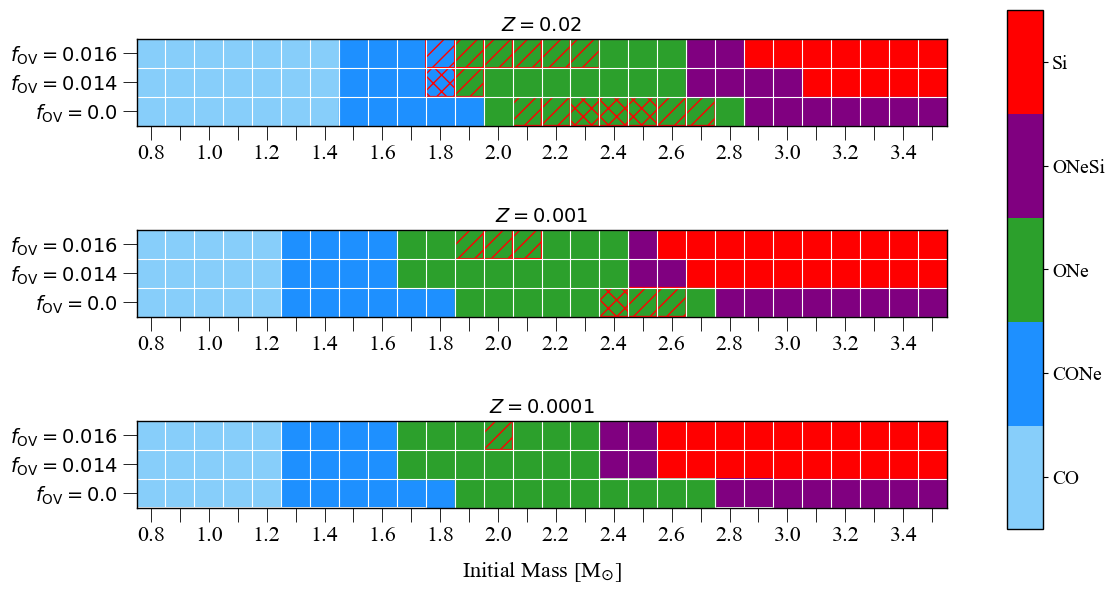

In [49]:
myCmap = cmap(['lightgrey','lightskyblue', 'dodgerblue', 'tab:green', 'purple', 'red'])


fontsize=16
make_canvas(fig_width=12.0, columns=1, clear=True, fontsize=fontsize)




fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex='none', sharey='all')

fig.subplots_adjust(hspace=0.01)

img3 = ax3.imshow(ZLOW, cmap = myCmap, interpolation = 'none', origin = 'lower')
img2 = ax2.imshow(ZINTER, cmap = myCmap, interpolation = 'none', origin = 'lower')
img1 = ax1.imshow(ZHIGH, cmap = myCmap, interpolation = 'none', origin = 'lower')
#img = ax1.imshow(ZHIGH, cmap = cbar_cmap, interpolation = 'none', origin = 'lower')

ax1.add_patch(matplotlib.patches.Rectangle((9.5, 0.5), 1, 1, hatch = 'xx', fill = False, snap = False, color = 'r'))
ax1.add_patch(matplotlib.patches.Rectangle((10.5, 0.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
#ax1.add_patch(matplotlib.patches.Rectangle((8.5, 1.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'k'))
ax1.add_patch(matplotlib.patches.Rectangle((9.5, 1.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax1.add_patch(matplotlib.patches.Rectangle((10.5, 1.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax1.add_patch(matplotlib.patches.Rectangle((11.5, 1.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax1.add_patch(matplotlib.patches.Rectangle((12.5, 1.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax1.add_patch(matplotlib.patches.Rectangle((13.5, 1.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax1.add_patch(matplotlib.patches.Rectangle((14.5, 1.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax1.add_patch(matplotlib.patches.Rectangle((12.5, -0.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax1.add_patch(matplotlib.patches.Rectangle((13.5, -0.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax1.add_patch(matplotlib.patches.Rectangle((14.5, -0.5), 1, 1, hatch = 'xx', fill = False, snap = False, color = 'r'))
ax1.add_patch(matplotlib.patches.Rectangle((15.5, -0.5), 1, 1, hatch = 'xx', fill = False, snap = False, color = 'r'))
ax1.add_patch(matplotlib.patches.Rectangle((16.5, -0.5), 1, 1, hatch = 'xx', fill = False, snap = False, color = 'r'))
ax1.add_patch(matplotlib.patches.Rectangle((17.5, -0.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax1.add_patch(matplotlib.patches.Rectangle((18.5, -0.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))

ax2.add_patch(matplotlib.patches.Rectangle((10.5, 1.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax2.add_patch(matplotlib.patches.Rectangle((11.5, 1.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
####
ax2.add_patch(matplotlib.patches.Rectangle((15.5, -0.5), 1, 1, hatch = 'xx', fill = False, snap = False, color = 'r'))
ax2.add_patch(matplotlib.patches.Rectangle((16.5, -0.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax2.add_patch(matplotlib.patches.Rectangle((17.5, -0.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))

ax3.add_patch(matplotlib.patches.Rectangle((11.5, 1.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))

# These are actually ONe WDs
ax2.add_patch(matplotlib.patches.Rectangle((5.5, -0.5), 1, 1, fill = True, color = 'dodgerblue'))
ax3.add_patch(matplotlib.patches.Rectangle((6.5, 1.5), 1, 1, fill = True, color = 'dodgerblue'))

# These are actually ONeSi cores
ax3.add_patch(matplotlib.patches.Rectangle((21.5, -0.5), 1, 1, fill = True, color = 'purple'))
ax3.add_patch(matplotlib.patches.Rectangle((22.5, -0.5), 1, 1, fill = True, color = 'purple'))
ax3.add_patch(matplotlib.patches.Rectangle((23.5, -0.5), 1, 1, fill = True, color = 'purple'))
ax3.add_patch(matplotlib.patches.Rectangle((24.5, -0.5), 1, 1, fill = True, color = 'purple'))
ax3.add_patch(matplotlib.patches.Rectangle((25.5, -0.5), 1, 1, fill = True, color = 'purple'))
ax3.add_patch(matplotlib.patches.Rectangle((26.5, -0.5), 1, 1, fill = True, color = 'purple'))

ax2.add_patch(matplotlib.patches.Rectangle((21.5, -0.5), 1, 1, fill = True, color = 'purple'))
ax2.add_patch(matplotlib.patches.Rectangle((22.5, -0.5), 1, 1, fill = True, color = 'purple'))
ax2.add_patch(matplotlib.patches.Rectangle((23.5, -0.5), 1, 1, fill = True, color = 'purple'))
ax2.add_patch(matplotlib.patches.Rectangle((24.5, -0.5), 1, 1, fill = True, color = 'purple'))
ax2.add_patch(matplotlib.patches.Rectangle((25.5, -0.5), 1, 1, fill = True, color = 'purple'))
ax2.add_patch(matplotlib.patches.Rectangle((26.5, -0.5), 1, 1, fill = True, color = 'purple'))

ax1.add_patch(matplotlib.patches.Rectangle((20.5, 0.5), 1, 1, fill = True, color = 'purple'))
ax1.add_patch(matplotlib.patches.Rectangle((21.5, 0.5), 1, 1, fill = True, color = 'purple'))



# Fill in the blanks
ax3.add_patch(matplotlib.patches.Rectangle((9.5, -0.5), 1, 1, fill = True, color = 'dodgerblue'))
ax3.add_patch(matplotlib.patches.Rectangle((10.5, -0.5), 1, 1, fill = True, color = 'tab:green'))
ax3.add_patch(matplotlib.patches.Rectangle((11.5, -0.5), 1, 1, fill = True, color = 'tab:green'))
ax3.add_patch(matplotlib.patches.Rectangle((12.5, -0.5), 1, 1, fill = True, color = 'tab:green'))
ax3.add_patch(matplotlib.patches.Rectangle((13.5, -0.5), 1, 1, fill = True, color = 'tab:green'))
ax3.add_patch(matplotlib.patches.Rectangle((14.5, -0.5), 1, 1, fill = True, color = 'tab:green'))
ax3.add_patch(matplotlib.patches.Rectangle((15.5, -0.5), 1, 1, fill = True, color = 'tab:green'))
ax3.add_patch(matplotlib.patches.Rectangle((16.5, -0.5), 1, 1, fill = True, color = 'tab:green'))
ax3.add_patch(matplotlib.patches.Rectangle((17.5, -0.5), 1, 1, fill = True, color = 'tab:green'))
ax3.add_patch(matplotlib.patches.Rectangle((18.5, -0.5), 1, 1, fill = True, color = 'tab:green'))

ax3.add_patch(matplotlib.patches.Rectangle((8.5, 0.5), 1, 1, fill = True, color = 'tab:green'))
ax3.add_patch(matplotlib.patches.Rectangle((9.5, 0.5), 1, 1, fill = True, color = 'tab:green'))
ax3.add_patch(matplotlib.patches.Rectangle((10.5, 0.5), 1, 1, fill = True, color = 'tab:green'))
ax3.add_patch(matplotlib.patches.Rectangle((11.5, 0.5), 1, 1, fill = True, color = 'tab:green'))
ax3.add_patch(matplotlib.patches.Rectangle((12.5, 0.5), 1, 1, fill = True, color = 'tab:green'))
ax3.add_patch(matplotlib.patches.Rectangle((13.5, 0.5), 1, 1, fill = True, color = 'tab:green'))
ax3.add_patch(matplotlib.patches.Rectangle((14.5, 0.5), 1, 1, fill = True, color = 'tab:green'))

ax3.add_patch(matplotlib.patches.Rectangle((7.5, 1.5), 1, 1, fill = True, color = 'dodgerblue'))
ax3.add_patch(matplotlib.patches.Rectangle((8.5, 1.5), 1, 1, fill = True, color = 'tab:green'))
ax3.add_patch(matplotlib.patches.Rectangle((9.5, 1.5), 1, 1, fill = True, color = 'tab:green'))
ax3.add_patch(matplotlib.patches.Rectangle((10.5, 1.5), 1, 1, fill = True, color = 'tab:green'))
ax3.add_patch(matplotlib.patches.Rectangle((12.5, 1.5), 1, 1, fill = True, color = 'tab:green'))
ax3.add_patch(matplotlib.patches.Rectangle((13.5, 1.5), 1, 1, fill = True, color = 'tab:green'))
ax3.add_patch(matplotlib.patches.Rectangle((14.5, 1.5), 1, 1, fill = True, color = 'tab:green'))



ax2.add_patch(matplotlib.patches.Rectangle((9.5, -0.5), 1, 1, fill = True, color = 'dodgerblue'))
ax2.add_patch(matplotlib.patches.Rectangle((10.5, -0.5), 1, 1, fill = True, color = 'tab:green'))
ax2.add_patch(matplotlib.patches.Rectangle((11.5, -0.5), 1, 1, fill = True, color = 'tab:green'))
ax2.add_patch(matplotlib.patches.Rectangle((12.5, -0.5), 1, 1, fill = True, color = 'tab:green'))
ax2.add_patch(matplotlib.patches.Rectangle((13.5, -0.5), 1, 1, fill = True, color = 'tab:green'))
ax2.add_patch(matplotlib.patches.Rectangle((14.5, -0.5), 1, 1, fill = True, color = 'tab:green'))
ax2.add_patch(matplotlib.patches.Rectangle((18.5, -0.5), 1, 1, fill = True, color = 'tab:green'))


ax2.add_patch(matplotlib.patches.Rectangle((8.5, 0.5), 1, 1, fill = True, color = 'tab:green'))
ax2.add_patch(matplotlib.patches.Rectangle((9.5, 0.5), 1, 1, fill = True, color = 'tab:green'))
ax2.add_patch(matplotlib.patches.Rectangle((10.5, 0.5), 1, 1, fill = True, color = 'tab:green'))
ax2.add_patch(matplotlib.patches.Rectangle((11.5, 0.5), 1, 1, fill = True, color = 'tab:green'))
ax2.add_patch(matplotlib.patches.Rectangle((12.5, 0.5), 1, 1, fill = True, color = 'tab:green'))
ax2.add_patch(matplotlib.patches.Rectangle((13.5, 0.5), 1, 1, fill = True, color = 'tab:green'))
ax2.add_patch(matplotlib.patches.Rectangle((14.5, 0.5), 1, 1, fill = True, color = 'tab:green'))
ax2.add_patch(matplotlib.patches.Rectangle((15.5, 0.5), 1, 1, fill = True, color = 'tab:green'))


ax2.add_patch(matplotlib.patches.Rectangle((8.5, 1.5), 1, 1, fill = True, color = 'tab:green'))
ax2.add_patch(matplotlib.patches.Rectangle((9.5, 1.5), 1, 1, fill = True, color = 'tab:green'))
ax2.add_patch(matplotlib.patches.Rectangle((12.5, 1.5), 1, 1, fill = True, color = 'tab:green'))
ax2.add_patch(matplotlib.patches.Rectangle((13.5, 1.5), 1, 1, fill = True, color = 'tab:green'))
ax2.add_patch(matplotlib.patches.Rectangle((14.5, 1.5), 1, 1, fill = True, color = 'tab:green'))
ax2.add_patch(matplotlib.patches.Rectangle((15.5, 1.5), 1, 1, fill = True, color = 'tab:green'))



ax1.add_patch(matplotlib.patches.Rectangle((6.5, -0.5), 1, 1, fill = True, color = 'dodgerblue'))
ax1.add_patch(matplotlib.patches.Rectangle((9.5, -0.5), 1, 1, fill = True, color = 'dodgerblue'))
ax1.add_patch(matplotlib.patches.Rectangle((10.5, -0.5), 1, 1, fill = True, color = 'dodgerblue'))
ax1.add_patch(matplotlib.patches.Rectangle((11.5, -0.5), 1, 1, fill = True, color = 'tab:green'))
ax1.add_patch(matplotlib.patches.Rectangle((19.5, -0.5), 1, 1, fill = True, color = 'tab:green'))
ax1.add_patch(matplotlib.patches.Rectangle((22.5, -0.5), 1, 1, fill = True, color = 'purple'))
ax1.add_patch(matplotlib.patches.Rectangle((23.5, -0.5), 1, 1, fill = True, color = 'purple'))
ax1.add_patch(matplotlib.patches.Rectangle((24.5, -0.5), 1, 1, fill = True, color = 'purple'))
ax1.add_patch(matplotlib.patches.Rectangle((25.5, -0.5), 1, 1, fill = True, color = 'purple'))
ax1.add_patch(matplotlib.patches.Rectangle((26.5, -0.5), 1, 1, fill = True, color = 'purple'))

ax1.add_patch(matplotlib.patches.Rectangle((11.5, 0.5), 1, 1, fill = True, color = 'tab:green'))
ax1.add_patch(matplotlib.patches.Rectangle((12.5, 0.5), 1, 1, fill = True, color = 'tab:green'))
ax1.add_patch(matplotlib.patches.Rectangle((13.5, 0.5), 1, 1, fill = True, color = 'tab:green'))
ax1.add_patch(matplotlib.patches.Rectangle((14.5, 0.5), 1, 1, fill = True, color = 'tab:green'))
ax1.add_patch(matplotlib.patches.Rectangle((15.5, 0.5), 1, 1, fill = True, color = 'tab:green'))
ax1.add_patch(matplotlib.patches.Rectangle((16.5, 0.5), 1, 1, fill = True, color = 'tab:green'))
ax1.add_patch(matplotlib.patches.Rectangle((17.5, 0.5), 1, 1, fill = True, color = 'tab:green'))
ax1.add_patch(matplotlib.patches.Rectangle((18.5, 0.5), 1, 1, fill = True, color = 'purple'))

ax1.add_patch(matplotlib.patches.Rectangle((15.5, 1.5), 1, 1, fill = True, color = 'tab:green'))
ax1.add_patch(matplotlib.patches.Rectangle((16.5, 1.5), 1, 1, fill = True, color = 'tab:green'))
ax1.add_patch(matplotlib.patches.Rectangle((17.5, 1.5), 1, 1, fill = True, color = 'tab:green'))


ax1.grid(True, which = 'major', axis = 'both', color = 'white')
ax2.grid(True, which = 'major', axis = 'both', color = 'white')
ax3.grid(True, which = 'major', axis = 'both', color = 'white')

ax1.xaxis.set_minor_locator(plt.MaxNLocator(29))
ax2.xaxis.set_minor_locator(plt.MaxNLocator(29))
ax3.xaxis.set_minor_locator(plt.MaxNLocator(29))
ax1.yaxis.set_minor_locator(plt.MaxNLocator(3))
ax2.yaxis.set_minor_locator(plt.MaxNLocator(3))
ax3.yaxis.set_minor_locator(plt.MaxNLocator(3))

ax1.tick_params(axis = 'both', which = 'major', length=0)
ax2.tick_params(axis = 'both', which = 'major', length=0)
ax3.tick_params(axis = 'both', which = 'major', length=0)
ax1.tick_params(axis = 'both', which = 'minor', length=10)
ax2.tick_params(axis = 'both', which = 'minor', length=10)
ax3.tick_params(axis = 'both', which = 'minor', length=10)

# Shift grid by 0.5 in both directions
ax1.set_xticks(np.arange(-.5, 27, 1))
ax1.set_yticks(np.arange(-.5, 3, 1))

ax2.set_xticks(np.arange(-.5, 27, 1))
ax2.set_yticks(np.arange(-.5, 3, 1))

ax3.set_xticks(np.arange(-.5, 27, 1))
ax3.set_yticks(np.arange(-.5, 3, 1))

# Get labels
#xlabels = [item.get_text() for item in ax3.get_xticklabels(minor = True)]
y1labels = [item.get_text() for item in ax1.get_yticklabels(minor = True)]
y2labels = [item.get_text() for item in ax2.get_yticklabels(minor = True)]
y3labels = [item.get_text() for item in ax3.get_yticklabels(minor = True)]
xlabels = ['' for i in range(30)]

# Create custom labels
xlabels[1] = '0.8'
#xlabels[2] = '0.9'
xlabels[3] = '1.0'
#xlabels[4] = '1.1'
xlabels[5] = '1.2'
#xlabels[6] = '1.3'
xlabels[7] = '1.4'
#xlabels[8] = '1.5'
xlabels[9] = '1.6'
#xlabels[10] = '1.7'
xlabels[11] = '1.8'
xlabels[13] = '2.0'
xlabels[15] = '2.2'
xlabels[17] = '2.4'
xlabels[19] = '2.6'
xlabels[21] = '2.8'
xlabels[23] = '3.0'
xlabels[25] = '3.2'
xlabels[27] = '3.4'

y1labels[1] = r'$f_{\rm OV}=0.0$'
y1labels[2] = r'$f_{\rm OV}=0.014$'
y1labels[3] = r'$f_{\rm OV}=0.016$'

# Set new labels


ax1.set_xticklabels(xlabels, minor=True)
ax2.set_xticklabels(xlabels, minor=True)
ax3.set_xticklabels(xlabels, minor=True)

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])

ax3.set_xlabel(r'Initial Mass [M$_{\odot}$]', labelpad=10)



ax1.set_yticklabels(y1labels, minor=True, size=14)
ax2.set_yticklabels(y1labels, minor=True, size=14)
ax3.set_yticklabels(y1labels, minor=True, size=14)
ax1.set_yticklabels([])

ax1.set_title(r'$Z=0.02$', size=14)
ax2.set_title(r'$Z=0.001$', size=14)
ax3.set_title(r'$Z=0.0001$', size=14)


# Colorbar config
cbar_cmap = cmap(['lightskyblue', 'dodgerblue', 'tab:green', 'purple', 'red'])

# create dummy invisible image
# (use the colormap you want to have on the colorbar)
img = ax1.imshow(ZHIGH, cmap = cbar_cmap, interpolation = 'none', origin = 'lower')
img.set_visible(False)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.colorbar(img, cax=cbar_ax, ticks=[0.5, 1.5, 2.5, 3.5, 4.5])

cbar_ax.set_yticklabels(['CO', 'CONe', 'ONe', 'ONeSi', 'Si'], size = 14)



# Fixes
ax2.add_patch(matplotlib.patches.Rectangle((12.5, 1.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))

# plt.savefig(os.path.join(plot_results_dir, 'parameterSpaceRaster.png'), dpi=300, bbox_inches='tight')

## SNe rates

In [50]:
# SNIa (f_OV = 0.0)
zams_zsol = mass_converter_he_to_zams([2.1, 2.7])
zams_zlow = mass_converter_he_to_zams([1.8, 2.6])
print('Integral boundaries: ', zams_zsol, zams_zlow)

I1 = quad(lambda m: m**(-2.35), zams_zsol[0], zams_zsol[1])
I2 = quad(lambda m: m**(-2.35), zams_zlow[0], zams_zlow[1])

print(r'Ratio SNIa (f_{OV} = 0.0): ', I1[0]/I2[0])

# SNIa (f_OV = 0.016)
zams_zsol = mass_converter_he_to_zams([1.8, 2.6])
zams_zlow = mass_converter_he_to_zams([1.7, 2.3])
print('Integral boundaries: ', zams_zsol, zams_zlow)

I1 = quad(lambda m: m**(-2.35), zams_zsol[0], zams_zsol[1])
I2 = quad(lambda m: m**(-2.35), zams_zlow[0], zams_zlow[1])

print(r'Ratio SNIa (f_{OV} = 0.016): ', I1[0]/I2[0])


# CCSN (f_OV = 0.0)
zams_zsol = mass_converter_he_to_zams([2.8, 40.0])
zams_zlow = mass_converter_he_to_zams([2.7, 25.0])
print('Integral boundaries: ', zams_zsol, zams_zlow)

I1 = quad(lambda m: m**(-2.35), zams_zsol[0], zams_zsol[1])
I2 = quad(lambda m: m**(-2.35), zams_zlow[0], zams_zlow[1])

print(r'Ratio CCSN (f_{OV} = 0.0): ', I1[0]/I2[0])

# CCSN (f_OV = 0.016)
zams_zsol = mass_converter_he_to_zams([2.7, 40.0])
zams_zlow = mass_converter_he_to_zams([2.4, 30.0])
print('Integral boundaries: ', zams_zsol, zams_zlow)

I1 = quad(lambda m: m**(-2.35), zams_zsol[0], zams_zsol[1])
I2 = quad(lambda m: m**(-2.35), zams_zlow[0], zams_zlow[1])

print(r'Ratio CCSN (f_{OV} = 0.016): ', I1[0]/I2[0])

Integral boundaries:  [12.1, 14.2] [11.0, 13.8]
Ratio SNIa (f_{OV} = 0.0):  0.6478291146030417
Integral boundaries:  [11.0, 13.8] [10.6, 12.8]
Ratio SNIa (f_{OV} = 0.016):  1.1160475288666674
Integral boundaries:  [14.5, 76.2] [14.2, 56.8]
Ratio CCSN (f_{OV} = 0.0):  1.0266648223059232
Integral boundaries:  [14.2, 76.2] [13.2, 63.7]
Ratio CCSN (f_{OV} = 0.016):  0.9225305380153256


## Core growth

In [51]:
def poly_fit(x, a, b, c):
    y = a * (x - b)**3 + c
    return y

In [52]:
massLM_WNO, massIM_WNO, massSM_WNO = [],[],[]
massLM_WO1, massIM_WO1, massSM_WO1 = [],[],[]
massLM_WO2, massIM_WO2, massSM_WO2 = [],[],[]


coreLM_WNO, coreIM_WNO, coreSM_WNO = [],[],[]
coreLM_WO1, coreIM_WO1, coreSM_WO1 = [],[],[]
coreLM_WO2, coreIM_WO2, coreSM_WO2 = [],[],[]

with open('/Users/schanlar/Desktop/Projects/COSNe-Ia/TNS_HeStars_figures/scripts/series1_core_growth_data.csv', 'r') as data:
    next(data)
    reader = csv.reader(data)
    for row in reader:
        
        if float(row[4]) < 0.1: #0.2, 0.3
        
            if row[1] == '0.0001' and row[2] == '0.0000':
                massLM_WNO.append(float(row[0]))
                coreLM_WNO.append(float(row[3]))

            elif row[1] == '0.0001' and row[2] == '0.0140':
                massLM_WO1.append(float(row[0]))
                coreLM_WO1.append(float(row[3]))

            elif row[1] == '0.0001' and row[2] == '0.0160':
                massLM_WO2.append(float(row[0]))
                coreLM_WO2.append(float(row[3]))

            elif row[1] == '0.0010' and row[2] == '0.0000':
                massIM_WNO.append(float(row[0]))
                coreIM_WNO.append(float(row[3]))

            elif row[1] == '0.0010' and row[2] == '0.0140':
                massIM_WO1.append(float(row[0]))
                coreIM_WO1.append(float(row[3]))

            elif row[1] == '0.0010' and row[2] == '0.0160':
                massIM_WO2.append(float(row[0]))
                coreIM_WO2.append(float(row[3]))

            elif row[1] == '0.0200' and row[2] == '0.0000':
                massSM_WNO.append(float(row[0]))
                coreSM_WNO.append(float(row[3]))

            elif row[1] == '0.0200' and row[2] == '0.0140':
                massSM_WO1.append(float(row[0]))
                coreSM_WO1.append(float(row[3]))

            elif row[1] == '0.0200' and row[2] == '0.0160':
                massSM_WO2.append(float(row[0]))
                coreSM_WO2.append(float(row[3]))
                
        elif float(row[3]) >= 1.45 and float(row[0]) >= 2.8:
            
            if row[1] == '0.0001' and row[2] == '0.0000':
                massLM_WNO.append(float(row[0]))
                coreLM_WNO.append(float(row[3]))

            elif row[1] == '0.0001' and row[2] == '0.0140':
                massLM_WO1.append(float(row[0]))
                coreLM_WO1.append(float(row[3]))

            elif row[1] == '0.0001' and row[2] == '0.0160':
                massLM_WO2.append(float(row[0]))
                coreLM_WO2.append(float(row[3]))

            elif row[1] == '0.0010' and row[2] == '0.0000':
                massIM_WNO.append(float(row[0]))
                coreIM_WNO.append(float(row[3]))

            elif row[1] == '0.0010' and row[2] == '0.0140':
                massIM_WO1.append(float(row[0]))
                coreIM_WO1.append(float(row[3]))

            elif row[1] == '0.0010' and row[2] == '0.0160':
                massIM_WO2.append(float(row[0]))
                coreIM_WO2.append(float(row[3]))

            elif row[1] == '0.0200' and row[2] == '0.0000':
                massSM_WNO.append(float(row[0]))
                coreSM_WNO.append(float(row[3]))

            elif row[1] == '0.0200' and row[2] == '0.0140':
                massSM_WO1.append(float(row[0]))
                coreSM_WO1.append(float(row[3]))

            elif row[1] == '0.0200' and row[2] == '0.0160':
                massSM_WO2.append(float(row[0]))
                coreSM_WO2.append(float(row[3]))

In [53]:
# For interpolated data
newx_SMWNO, newy_SMWNO = [], []
newx_LMWNO, newy_LMWNO = [], []
newx_IMWNO, newy_IMWNO = [], []

newx_SMWO1, newy_SMWO1 = [], []
newx_LMWO1, newy_LMWO1 = [], []
newx_IMWO1, newy_IMWO1 = [], []

newx_SMWO2, newy_SMWO2 = [], []
newx_LMWO2, newy_LMWO2 = [], []
newx_IMWO2, newy_IMWO2 = [], []


        
massLM_WNO_n, coreLM_WNO_n = [], []
acceptable_masses_LM_WNO = [0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5]
for i,j in zip(massLM_WNO, coreLM_WNO):
    if i in acceptable_masses_LM_WNO:
        massLM_WNO_n.append(i)
        coreLM_WNO_n.append(j)
        
massIM_WNO_n, coreIM_WNO_n = [], []
acceptable_masses_IM_WNO = [0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 2.4, 2.5, 2.6, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5]
for i,j in zip(massIM_WNO, coreIM_WNO):
    if i in acceptable_masses_IM_WNO:
        massIM_WNO_n.append(i)
        coreIM_WNO_n.append(j)

massSM_WNO_n, coreSM_WNO_n = [2.1, 2.2], [1.369, 1.368]
acceptable_masses_SM_WNO = [0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5]
for i,j in zip(massSM_WNO, coreSM_WNO):
    if i in acceptable_masses_SM_WNO:
        massSM_WNO_n.append(i)
        coreSM_WNO_n.append(j)
        
        
        
        
x_fit = np.linspace(0.8, 3.5, 28)

popt_lm_wno, pcov_lm_wno = so.curve_fit(poly_fit, massLM_WNO_n, coreLM_WNO_n)
y_fit_LMWNO = poly_fit(x_fit, *popt_lm_wno)
print(*popt_lm_wno)
perr_lm_wno = np.sqrt(np.diag(pcov_lm_wno))
print('fit parameter 1-sigma error')
print('———————————–')
for i in range(len(popt_lm_wno)):
    print(str(popt_lm_wno[i])+ '+-' + str(perr_lm_wno[i]))
    
# prepare confidence level curves
nstd = 3. # to draw 3-sigma intervals
popt_up_lm_wno = popt_lm_wno + nstd * perr_lm_wno
popt_dw_lm_wno = popt_lm_wno - nstd * perr_lm_wno

fit_lm_wno = poly_fit(x_fit, *popt_lm_wno)
fit_up_lm_wno = poly_fit(x_fit, *popt_up_lm_wno)
fit_dw_lm_wno = poly_fit(x_fit, *popt_dw_lm_wno)



popt_lm_wo1, pcov = so.curve_fit(poly_fit, massLM_WO1, coreLM_WO1)
y_fit_LMWO1 = poly_fit(x_fit, *popt_lm_wo1)
popt_lm_wo2, pcov = so.curve_fit(poly_fit, massLM_WO2, coreLM_WO2)
y_fit_LMWO2 = poly_fit(x_fit, *popt_lm_wo2)




popt_im_wno, pcov_im_wno = so.curve_fit(poly_fit, massIM_WNO_n, coreIM_WNO_n)
y_fit_IMWNO = poly_fit(x_fit, *popt_im_wno)
print(*popt_im_wno)
perr_im_wno = np.sqrt(np.diag(pcov_im_wno))
print('fit parameter 1-sigma error')
print('———————————–')
for i in range(len(popt_im_wno)):
    print(str(popt_im_wno[i])+ '+-' + str(perr_im_wno[i]))
    
# prepare confidence level curves
nstd = 3. # to draw 3-sigma intervals
popt_up_im_wno = popt_im_wno + nstd * perr_im_wno
popt_dw_im_wno = popt_im_wno - nstd * perr_im_wno

fit_im_wno = poly_fit(x_fit, *popt_im_wno)
fit_up_im_wno = poly_fit(x_fit, *popt_up_im_wno)
fit_dw_im_wno = poly_fit(x_fit, *popt_dw_im_wno)


popt_im_wo1, pcov = so.curve_fit(poly_fit, massIM_WO1, coreIM_WO1)
y_fit_IMWO1 = poly_fit(x_fit, *popt_im_wo1)
popt_im_wo2, pcov = so.curve_fit(poly_fit, massIM_WO2, coreIM_WO2)
y_fit_IMWO2 = poly_fit(x_fit, *popt_im_wo2)




popt_sm_wno, pcov_sm_wno = so.curve_fit(poly_fit, massSM_WNO_n, coreSM_WNO_n)
y_fit_SMWNO = poly_fit(x_fit, *popt_sm_wno)
print(*popt_sm_wno)
perr_sm_wno = np.sqrt(np.diag(pcov_sm_wno))
print('fit parameter 1-sigma error')
print('———————————–')
for i in range(len(popt_sm_wno)):
    print(str(popt_sm_wno[i])+ '+-' + str(perr_sm_wno[i]))
    
# prepare confidence level curves
nstd = 3. # to draw 3-sigma intervals
popt_up_sm_wno = popt_sm_wno + nstd * perr_sm_wno
popt_dw_sm_wno = popt_sm_wno - nstd * perr_sm_wno

fit_sm_wno = poly_fit(x_fit, *popt_sm_wno)
fit_up_sm_wno = poly_fit(x_fit, *popt_up_sm_wno)
fit_dw_sm_wno = poly_fit(x_fit, *popt_dw_sm_wno)



popt_sm_wo1, pcov = so.curve_fit(poly_fit, massSM_WO1, coreSM_WO1)
y_fit_SMWO1 = poly_fit(x_fit, *popt_sm_wo1)
popt_sm_wo2, pcov = so.curve_fit(poly_fit, massSM_WO2, coreSM_WO2)
y_fit_SMWO2 = poly_fit(x_fit, *popt_sm_wo2)









for i in x_fit:
    found = False
    for j in massSM_WNO_n:
        
        if math.isclose(i,j, rel_tol = 0.001):
            #print(f'Value {i} is close to {j}')
            found = True
            break
    if not found:
        newx_SMWNO.append(i)
        newy_SMWNO.append(poly_fit(i, *popt_sm_wno))
        
for i in x_fit:
    found = False
    for j in massLM_WNO_n:
        
        if math.isclose(i,j, rel_tol = 0.001):
            #print(f'Value {i} is close to {j}')
            found = True
            break
    if not found:
        newx_LMWNO.append(i)
        newy_LMWNO.append(poly_fit(i, *popt_lm_wno))
        
        
for i in x_fit:
    found = False
    for j in massIM_WNO_n:
        
        if math.isclose(i,j, rel_tol = 0.001):
            #print(f'Value {i} is close to {j}')
            found = True
            break
    if not found:
        newx_IMWNO.append(i)
        newy_IMWNO.append(poly_fit(i, *popt_im_wno))
        
        
        
        
for i in x_fit:
    found = False
    for j in massSM_WO1:
        
        if math.isclose(i,j, rel_tol = 0.001):
            #print(f'Value {i} is close to {j}')
            found = True
            break
    if not found:
        newx_SMWO1.append(i)
        newy_SMWO1.append(poly_fit(i, *popt_sm_wo1))
        
for i in x_fit:
    found = False
    for j in massLM_WO1:
        
        if math.isclose(i,j, rel_tol = 0.001):
            #print(f'Value {i} is close to {j}')
            found = True
            break
    if not found:
        newx_LMWO1.append(i)
        newy_LMWO1.append(poly_fit(i, *popt_lm_wo1))
        
        
for i in x_fit:
    found = False
    for j in massIM_WO1:
        
        if math.isclose(i,j, rel_tol = 0.001):
            #print(f'Value {i} is close to {j}')
            found = True
            break
    if not found:
        newx_IMWO1.append(i)
        newy_IMWO1.append(poly_fit(i, *popt_im_wo1))
        
        
        
        
for i in x_fit:
    found = False
    for j in massSM_WO2:
        
        if math.isclose(i,j, rel_tol = 0.001):
            #print(f'Value {i} is close to {j}')
            found = True
            break
    if not found:
        newx_SMWO2.append(i)
        newy_SMWO2.append(poly_fit(i, *popt_sm_wo2))
        
for i in x_fit:
    found = False
    for j in massLM_WO2:
        
        if math.isclose(i,j, rel_tol = 0.001):
            #print(f'Value {i} is close to {j}')
            found = True
            break
    if not found:
        newx_LMWO2.append(i)
        newy_LMWO2.append(poly_fit(i, *popt_lm_wo2))
        #newy_LMWNO.append(poly_fit(i, 0.2, 2.145, 1.289))
        
for i in x_fit:
    found = False
    for j in massIM_WO2:
        
        if math.isclose(i,j, rel_tol = 0.001):
            #print(f'Value {i} is close to {j}')
            found = True
            break
    if not found:
        newx_IMWO2.append(i)
        newy_IMWO2.append(poly_fit(i, *popt_im_wo2))
        #newy_IMWNO.append(poly_fit(i, 0.2, 2.206, 1.32))
# -------------------------------------------------------------

0.20136809569870523 2.2242559145267022 1.3519499399021906
fit parameter 1-sigma error
———————————–
0.20136809569870523+-0.006645479222965871
2.2242559145267022+-0.03639837022052317
1.3519499399021906+-0.026339439858938583
0.2007608843420946 2.252466849074164 1.36360606682164
fit parameter 1-sigma error
———————————–
0.2007608843420946+-0.005862104731418796
2.252466849074164+-0.022408638260362507
1.36360606682164+-0.014619541962408372
0.19575386301816447 2.336010910603919 1.3564902749702745
fit parameter 1-sigma error
———————————–
0.19575386301816447+-0.005571035420565269
2.336010910603919+-0.017687019482385356
1.3564902749702745+-0.00914797080509126


<Figure size 1000x1500 with 0 Axes>

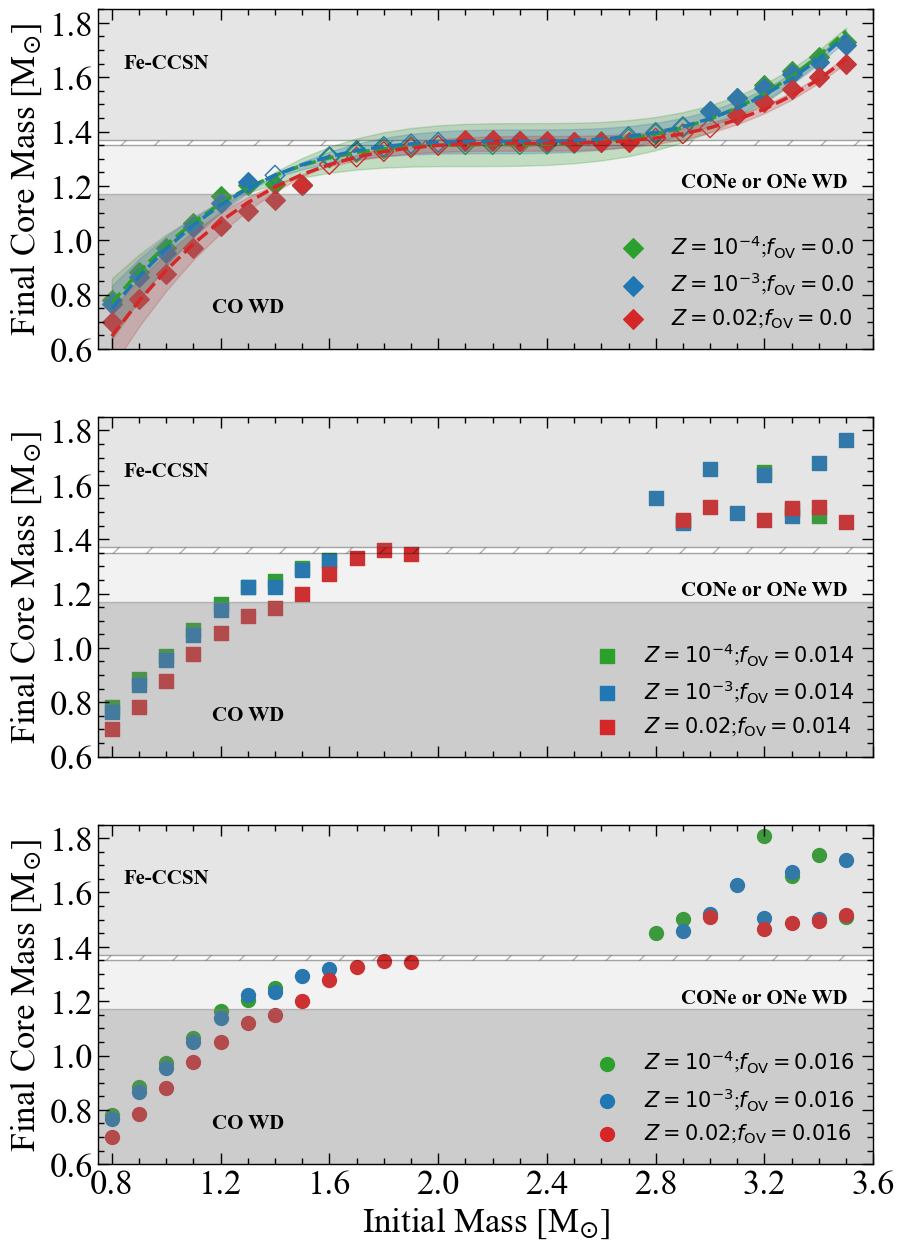

In [54]:
fontsize=25
make_canvas(fig_width=10, fig_height=15, clear=True, fontsize=fontsize)
s=100

fig, (ax0, ax1, ax2) = plt.subplots(3,1, sharex=True)
ax2.set_xlabel(r'Initial Mass [M$_{\odot}$]')
ax0.set_ylabel(r'Final Core Mass [M$_{\odot}$]')
ax1.set_ylabel(r'Final Core Mass [M$_{\odot}$]')
ax2.set_ylabel(r'Final Core Mass [M$_{\odot}$]')

ax0.set_xlim(0.75, 3.6)
ax0.set_ylim(0.6, 1.85)
ax0.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax0.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax0.xaxis.set_major_locator(plt.MaxNLocator(8))
ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax0.yaxis.set_major_locator(plt.MaxNLocator(8))
ax0.yaxis.set_minor_locator(AutoMinorLocator())

ax1.set_xlim(0.75, 3.6)
ax1.set_ylim(0.6, 1.85)
ax1.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax1.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax1.xaxis.set_major_locator(plt.MaxNLocator(8))
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_major_locator(plt.MaxNLocator(8))
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax2.set_xlim(0.75, 3.6)
ax2.set_ylim(0.6, 1.85)
ax2.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax2.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax2.xaxis.set_major_locator(plt.MaxNLocator(8))
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_major_locator(plt.MaxNLocator(8))
ax2.yaxis.set_minor_locator(AutoMinorLocator())


ax0.fill([0.5, 3.7, 3.7, 0.5], [0.4, 0.4, 1.17, 1.17], alpha = 0.4, color='gray')
ax0.fill([0.5, 3.7, 3.7, 0.5], [1.17, 1.17, 1.35, 1.35], alpha = 0.1, color='gray')
ax0.fill([0.5, 3.7, 3.7, 0.5],[1.35, 1.35, 1.37, 1.37], alpha = 0.3, color='black', hatch='/', fill=False)
ax0.fill([0.5, 3.7, 3.7, 0.5], [1.37, 1.37, 2.35, 2.35], alpha = 0.2, color='gray')

ax1.fill([0.5, 3.7, 3.7, 0.5], [0.4, 0.4, 1.17, 1.17], alpha = 0.4, color='gray')
ax1.fill([0.5, 3.7, 3.7, 0.5], [1.17, 1.17, 1.35, 1.35], alpha = 0.1, color='gray')
ax1.fill([0.5, 3.7, 3.7, 0.5],[1.35, 1.35, 1.37, 1.37], alpha = 0.3, color='black', hatch='/', fill=False)
ax1.fill([0.5, 3.7, 3.7, 0.5], [1.37, 1.37, 2.35, 2.35], alpha = 0.2, color='gray')

ax2.fill([0.5, 3.7, 3.7, 0.5], [0.4, 0.4, 1.17, 1.17], alpha = 0.4, color='gray')
ax2.fill([0.5, 3.7, 3.7, 0.5], [1.17, 1.17, 1.35, 1.35], alpha = 0.1, color='gray')
ax2.fill([0.5, 3.7, 3.7, 0.5],[1.35, 1.35, 1.37, 1.37], alpha = 0.3, color='black', hatch='/', fill=False)
ax2.fill([0.5, 3.7, 3.7, 0.5], [1.37, 1.37, 2.35, 2.35], alpha = 0.2, color='gray')

ax0.text(1.3, 0.75, 'CO WD', fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')
ax0.text(3.2, 1.21, 'CONe or ONe WD', fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')
ax0.text(1.0, 1.65, 'Fe-CCSN', fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')

ax1.text(1.3, 0.75, 'CO WD', fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')
ax1.text(3.2, 1.21, 'CONe or ONe WD', fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')
ax1.text(1.0, 1.65, 'Fe-CCSN', fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')

ax2.text(1.3, 0.75, 'CO WD', fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')
ax2.text(3.2, 1.21, 'CONe or ONe WD', fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')
ax2.text(1.0, 1.65, 'Fe-CCSN', fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')






ax0.scatter(massLM_WNO_n, coreLM_WNO_n, c = 'tab:green', marker = 'D', s=s, label = r'$Z = 10^{-4}$;$f_{\rm OV} = 0.0$')
ax0.scatter(newx_LMWNO, newy_LMWNO, facecolors = 'none', edgecolors = 'tab:green', marker = 'D', s=s)
ax0.plot(x_fit[:], y_fit_LMWNO[:], c = 'tab:green', linestyle = '--')
ax0.fill_between(x_fit, fit_up_lm_wno, fit_dw_lm_wno, alpha=.25, color='tab:green')


ax0.scatter(massIM_WNO_n, coreIM_WNO_n, c = 'tab:blue', marker = 'D', s=s, label = r'$Z = 10^{-3}$;$f_{\rm OV} = 0.0$')
ax0.scatter(newx_IMWNO, newy_IMWNO, facecolors = 'none', edgecolors = 'tab:blue', marker = 'D', s=s)
ax0.plot(x_fit[:], y_fit_IMWNO[:], c = 'tab:blue', linestyle = '--')
ax0.fill_between(x_fit, fit_up_im_wno, fit_dw_im_wno, alpha=.25, color='tab:blue')


ax0.scatter(massSM_WNO_n, coreSM_WNO_n, c = 'tab:red', marker = 'D', s=s, label = r'$Z = 0.02$;$f_{\rm OV} = 0.0$')
ax0.scatter(newx_SMWNO, newy_SMWNO, facecolors = 'none', edgecolors = 'tab:red', marker = 'D', s=s)
ax0.plot(x_fit[:], y_fit_SMWNO[:], c = 'tab:red', linestyle = '--')
ax0.fill_between(x_fit, fit_up_sm_wno, fit_dw_sm_wno, alpha=.25, color='tab:red')

legend = ax0.legend(loc = 'lower right', prop={'size': 15}, shadow = False, frameon = False)



ax1.scatter(massLM_WO1, coreLM_WO1, c = 'tab:green', marker = 's', s=s, label = r'$Z = 10^{-4}$;$f_{\rm OV} = 0.014$')
ax1.scatter(massIM_WO1, coreIM_WO1, c = 'tab:blue', marker = 's', s=s, label = r'$Z = 10^{-3}$;$f_{\rm OV} = 0.014$')
ax1.scatter(massSM_WO1, coreSM_WO1, c = 'tab:red', marker = 's', s=s, label = r'$Z = 0.02$;$f_{\rm OV} = 0.014$')

legend = ax1.legend(loc = 'lower right', prop={'size': 15}, shadow = False, frameon = False)

ax2.scatter(massLM_WO2, coreLM_WO2, c = 'tab:green', marker = 'o', s=s, label = r'$Z = 10^{-4}$;$f_{\rm OV} = 0.016$')
ax2.scatter(massIM_WO2, coreIM_WO2, c = 'tab:blue', marker = 'o', s=s, label = r'$Z = 10^{-3}$;$f_{\rm OV} = 0.016$')
ax2.scatter(massSM_WO2, coreSM_WO2, c = 'tab:red', marker = 'o', s=s, label = r'$Z = 0.02$;$f_{\rm OV} = 0.016$')

legend = ax2.legend(loc = 'lower right', prop={'size': 15}, shadow = False, frameon = False)


# plt.savefig('/Users/schanlar/Desktop/asdf/final_figures_draft/series1_coreGrowth_panel1_interpolated.pdf', dpi=300, bbox_inches='tight')

<Figure size 1000x1500 with 0 Axes>

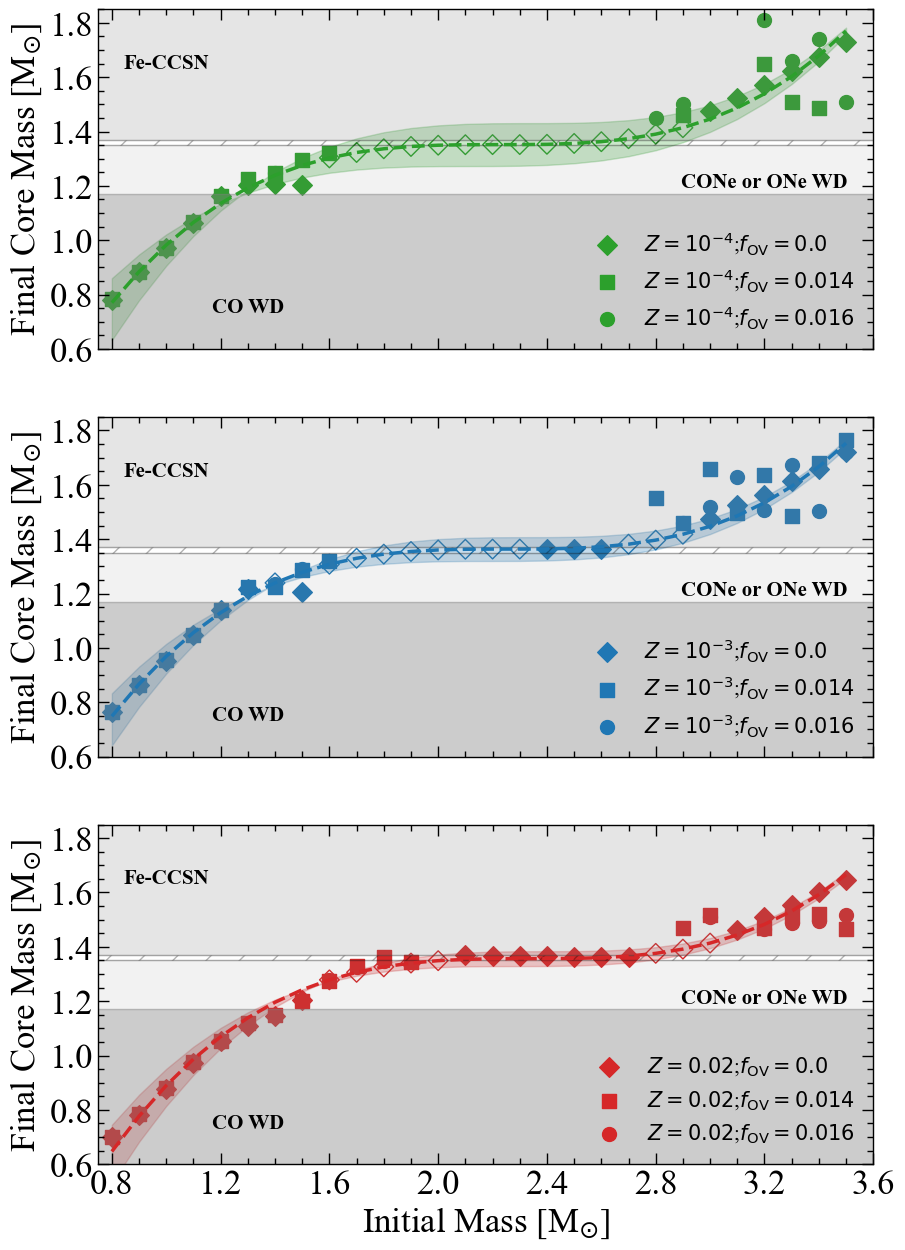

In [55]:
fontsize=25
make_canvas(fig_width=10, fig_height=15, clear=True, fontsize=fontsize)
s=100

fig, (ax0, ax1, ax2) = plt.subplots(3,1, sharex=True)
ax2.set_xlabel(r'Initial Mass [M$_{\odot}$]')
ax0.set_ylabel(r'Final Core Mass [M$_{\odot}$]')
ax1.set_ylabel(r'Final Core Mass [M$_{\odot}$]')
ax2.set_ylabel(r'Final Core Mass [M$_{\odot}$]')


ax0.set_xlim(0.75, 3.6)
ax0.set_ylim(0.6, 1.85)
ax0.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax0.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax0.xaxis.set_major_locator(plt.MaxNLocator(8))
ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax0.yaxis.set_major_locator(plt.MaxNLocator(8))
ax0.yaxis.set_minor_locator(AutoMinorLocator())

ax1.set_xlim(0.75, 3.6)
ax1.set_ylim(0.6, 1.85)
ax1.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax1.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax1.xaxis.set_major_locator(plt.MaxNLocator(8))
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_major_locator(plt.MaxNLocator(8))
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax2.set_xlim(0.75, 3.6)
ax2.set_ylim(0.6, 1.85)
ax2.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax2.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax2.xaxis.set_major_locator(plt.MaxNLocator(8))
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_major_locator(plt.MaxNLocator(8))
ax2.yaxis.set_minor_locator(AutoMinorLocator())


ax0.fill([0.5, 3.7, 3.7, 0.5], [0.4, 0.4, 1.17, 1.17], alpha = 0.4, color='gray')
ax0.fill([0.5, 3.7, 3.7, 0.5], [1.17, 1.17, 1.35, 1.35], alpha = 0.1, color='gray')
ax0.fill([0.5, 3.7, 3.7, 0.5],[1.35, 1.35, 1.37, 1.37], alpha = 0.3, color='black', hatch='/', fill=False)
ax0.fill([0.5, 3.7, 3.7, 0.5], [1.37, 1.37, 2.35, 2.35], alpha = 0.2, color='gray')

ax1.fill([0.5, 3.7, 3.7, 0.5], [0.4, 0.4, 1.17, 1.17], alpha = 0.4, color='gray')
ax1.fill([0.5, 3.7, 3.7, 0.5], [1.17, 1.17, 1.35, 1.35], alpha = 0.1, color='gray')
ax1.fill([0.5, 3.7, 3.7, 0.5],[1.35, 1.35, 1.37, 1.37], alpha = 0.3, color='black', hatch='/', fill=False)
ax1.fill([0.5, 3.7, 3.7, 0.5], [1.37, 1.37, 2.35, 2.35], alpha = 0.2, color='gray')

ax2.fill([0.5, 3.7, 3.7, 0.5], [0.4, 0.4, 1.17, 1.17], alpha = 0.4, color='gray')
ax2.fill([0.5, 3.7, 3.7, 0.5], [1.17, 1.17, 1.35, 1.35], alpha = 0.1, color='gray')
ax2.fill([0.5, 3.7, 3.7, 0.5],[1.35, 1.35, 1.37, 1.37], alpha = 0.3, color='black', hatch='/', fill=False)
ax2.fill([0.5, 3.7, 3.7, 0.5], [1.37, 1.37, 2.35, 2.35], alpha = 0.2, color='gray')

ax0.text(1.3, 0.75, 'CO WD', fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')
ax0.text(3.2, 1.21, 'CONe or ONe WD', fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')
ax0.text(1.0, 1.65, 'Fe-CCSN', fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')

ax1.text(1.3, 0.75, 'CO WD', fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')
ax1.text(3.2, 1.21, 'CONe or ONe WD', fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')
ax1.text(1.0, 1.65, 'Fe-CCSN', fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')

ax2.text(1.3, 0.75, 'CO WD', fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')
ax2.text(3.2, 1.21, 'CONe or ONe WD', fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')
ax2.text(1.0, 1.65, 'Fe-CCSN', fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')


ax0.scatter(massLM_WNO_n, coreLM_WNO_n, c = 'tab:green', marker = 'D', s=s, label = r'$Z = 10^{-4}$;$f_{\rm OV} = 0.0$')
ax0.scatter(massLM_WO1, coreLM_WO1, c = 'tab:green', marker = 's', s=s,  label = r'$Z = 10^{-4}$;$f_{\rm OV} = 0.014$')
ax0.scatter(massLM_WO2, coreLM_WO2, c = 'tab:green', marker = 'o', s=s, label = r'$Z = 10^{-4}$;$f_{\rm OV} = 0.016$')
legend = ax0.legend(loc = 'lower right', prop={'size': 15}, shadow = False, frameon = False)

ax1.scatter(massIM_WNO_n, coreIM_WNO_n, c = 'tab:blue', marker = 'D', s=s, label = r'$Z = 10^{-3}$;$f_{\rm OV} = 0.0$')
ax1.scatter(massIM_WO1, coreIM_WO1, c = 'tab:blue', marker = 's', s=s, label = r'$Z = 10^{-3}$;$f_{\rm OV} = 0.014$')
ax1.scatter(massIM_WO2, coreIM_WO2, c = 'tab:blue', marker = 'o', s=s, label = r'$Z = 10^{-3}$;$f_{\rm OV} = 0.016$')
legend = ax1.legend(loc = 'lower right', prop={'size': 15}, shadow = False, frameon = False)

ax2.scatter(massSM_WNO_n, coreSM_WNO_n, c = 'tab:red', marker = 'D', s=s, label = r'$Z = 0.02$;$f_{\rm OV} = 0.0$')
ax2.scatter(massSM_WO1, coreSM_WO1, c = 'tab:red', marker = 's', s=s, label = r'$Z = 0.02$;$f_{\rm OV} = 0.014$')
ax2.scatter(massSM_WO2, coreSM_WO2, c = 'tab:red', marker = 'o', s=s, label = r'$Z = 0.02$;$f_{\rm OV} = 0.016$')
legend = ax2.legend(loc = 'lower right', prop={'size': 15}, shadow = False, frameon = False)
# -------------------------------------------------------------



# Fitting curves + interpolated data
# -------------------------------------------------------------

ax0.scatter(newx_LMWNO, newy_LMWNO, facecolors = 'none', edgecolors = 'tab:green', marker = 'D', s=s)
ax0.plot(x_fit[:], y_fit_LMWNO[:], c = 'tab:green', linestyle = '--')
ax0.fill_between(x_fit, fit_up_lm_wno, fit_dw_lm_wno, alpha=.25, color='tab:green')

# ax0.plot(x_fit, y_fit_LMWO1, c = 'b', linestyle = '--')
# ax0.scatter(newx_LMWO1, newy_LMWO1, facecolors = 'none', edgecolors = 'b', marker = 's', s=s)

# ax0.plot(x_fit, y_fit_LMWO2, c = 'r', linestyle = '--')
# ax0.scatter(newx_LMWO2, newy_LMWO2, facecolors = 'none', edgecolors = 'r', marker = 'o',s=s)



ax1.plot(x_fit, y_fit_IMWNO, c = 'tab:blue', linestyle = '--')
ax1.scatter(newx_IMWNO, newy_IMWNO, facecolors = 'none', edgecolors = 'tab:blue', marker = 'D', s=s)
ax1.fill_between(x_fit, fit_up_im_wno, fit_dw_im_wno, alpha=.25, color='tab:blue')

# ax1.plot(x_fit, y_fit_IMWO1, c = 'b', linestyle = '--')
# ax1.scatter(newx_IMWO1, newy_IMWO1, facecolors = 'none', edgecolors = 'b', marker = 's', s=s)

# ax1.plot(x_fit, y_fit_IMWO2, c = 'r', linestyle = '--')
# ax1.scatter(newx_IMWO2, newy_IMWO2, facecolors = 'none', edgecolors = 'r', marker = 'o', s=s)



ax2.plot(x_fit, y_fit_SMWNO, c = 'tab:red', linestyle = '--')
ax2.scatter(newx_SMWNO, newy_SMWNO, facecolors = 'none', edgecolors = 'tab:red', marker = 'D', s=s)
ax2.fill_between(x_fit, fit_up_sm_wno, fit_dw_sm_wno, alpha=.25, color='tab:red')

# ax2.plot(x_fit, y_fit_SMWO1, c = 'b', linestyle = '--')
# ax2.scatter(newx_SMWO1, newy_SMWO1, facecolors = 'none', edgecolors = 'b', marker = 's', s=s)

# ax2.plot(x_fit, y_fit_SMWO2, c = 'r', linestyle = '--')
# ax2.scatter(newx_SMWO2, newy_SMWO2, facecolors = 'none', edgecolors = 'r', marker = 'o', s=s)

# plt.savefig('/Users/schanlar/Desktop/asdf/final_figures_draft/series1_coreGrowth_panel2_interpolated.pdf', dpi=300, bbox_inches='tight')

In [56]:
def core_mass(initial_mass, z='0.0001'):
    
    if z == '0.0001':
        return 0.2 * (initial_mass - 2.224)**3 + 1.352
    elif z == '0.0010':
        return 0.2*(initial_mass - 2.252)**3 + 1.364
    else:
        return 0.2*(initial_mass - 2.336)**3 + 1.357


initial_masses = np.linspace(0.8, 3.5, 28)

core_masses_zlow, core_masses_zim, core_masses_zsol = [], [], []

print('M_initial --> M_core')
print('*'*100)

for mass in initial_masses:
    core_masses_zlow.append(core_mass(mass))
    core_masses_zim.append(core_mass(mass, z='0.0010'))
    core_masses_zsol.append(core_mass(mass, z='0.0200'))
    
for i,j in zip(initial_masses, core_masses_zlow):
    if j < 1.35:
        print(round(i, 1), '-->', round(j,4))
print('--'*50)

for i,j in zip(initial_masses, core_masses_zim):
    if j < 1.35:
        print(round(i, 1), '-->', round(j,4))
print('--'*50)

for i,j in zip(initial_masses, core_masses_zsol):
    if j < 1.35:
        print(round(i, 1), '-->', round(j,4))

M_initial --> M_core
****************************************************************************************************
0.8 --> 0.7745
0.9 --> 0.8878
1.0 --> 0.9852
1.1 --> 1.068
1.2 --> 1.1373
1.3 --> 1.1942
1.4 --> 1.2401
1.5 --> 1.2761
1.6 --> 1.3034
1.7 --> 1.3232
1.8 --> 1.3368
1.9 --> 1.3452
2.0 --> 1.3498
----------------------------------------------------------------------------------------------------
0.8 --> 0.7517
0.9 --> 0.8697
1.0 --> 0.9715
1.1 --> 1.0582
1.2 --> 1.1311
1.3 --> 1.1914
1.4 --> 1.2403
1.5 --> 1.2789
1.6 --> 1.3086
1.7 --> 1.3304
1.8 --> 1.3455
----------------------------------------------------------------------------------------------------
0.8 --> 0.6322
0.9 --> 0.7648
1.0 --> 0.8801
1.1 --> 0.9794
1.2 --> 1.0638
1.3 --> 1.1346
1.4 --> 1.193
1.5 --> 1.2401
1.6 --> 1.2773
1.7 --> 1.3055
1.8 --> 1.3262
1.9 --> 1.3404
2.0 --> 1.3494


In [57]:
# Series 2 core growth
mass,metal,etawind,mcore,menv = [],[],[],[],[]

init_mass_eta0p1, init_mass_eta0p25, init_mass_eta0p5, init_mass_eta0p8, \
init_mass_eta1p0, init_mass_eta1p58 = [],[],[],[],[],[]

final_core_mass_eta0p1, final_core_mass_eta0p25, final_core_mass_eta0p5, \
final_core_mass_eta0p8, final_core_mass_eta1p0, final_core_mass_eta1p58 = [],[],[],[],[],[]

envelope_mass_eta0p1, envelope_mass_eta0p25, envelope_mass_eta0p5, \
envelope_mass_eta0p8, envelope_mass_eta1p0, envelope_mass_eta1p58 = [],[],[],[],[],[]


with open('/Users/schanlar/Desktop/Projects/COSNe-Ia/TNS_HeStars_figures/scripts/series2_core_growth_data.csv', 'r') as f:
    # Skip header of first row
    next(f)
    r = csv.reader(f)
    for row in r:
        mass.append(row[0])
        metal.append(row[1])
        etawind.append(row[2])
        mcore.append(row[3])
        menv.append(row[4])
        

for i,j,k,l,m in list(zip(mass, metal, etawind, mcore, menv)):
    if float(k) == 0.1000:
        init_mass_eta0p1.append(float(i))
        final_core_mass_eta0p1.append(float(l))
        envelope_mass_eta0p1.append(float(m))
    elif float(k) == 0.2500:
        init_mass_eta0p25.append(float(i))
        final_core_mass_eta0p25.append(float(l))
        envelope_mass_eta0p25.append(float(m))
    elif float(k) == 0.5000:
        init_mass_eta0p5.append(float(i))
        final_core_mass_eta0p5.append(float(l))
        envelope_mass_eta0p5.append(float(m))
    elif float(k) == 0.8000:
        init_mass_eta0p8.append(float(i))
        final_core_mass_eta0p8.append(float(l))
        envelope_mass_eta0p8.append(float(m))
    elif float(k) == 1.0000:
        init_mass_eta1p0.append(float(i))
        final_core_mass_eta1p0.append(float(l))
        envelope_mass_eta1p0.append(float(m))
    elif float(k) == 1.5800:
        init_mass_eta1p58.append(float(i))
        final_core_mass_eta1p58.append(float(l))
        envelope_mass_eta1p58.append(float(m))
    else:
        print('Oops! Something went wrong!')

In [58]:
fm_2 = []

for path in glob.glob('/Volumes/SavvasExternal/zsol_eta0p1/*'):
    info = path.split('/')[-1]
    im = float(info.split('_')[0])
    if im*10 >= 29:
        print('Working with model: ', info)
        h = mr.MesaData(os.path.join(path, 'LOGS/history.data')).data
        fm_2.append(h('star_mass')[-1])

In [59]:
im_2, cm_2, en_2 = [], [], []
eta=''
im = 0
with open('/Users/schanlar/Desktop/Projects/COSNe-Ia/TNS_HeStars/scripts/series2_isos_distribution_log.txt', 'r') as f:
    for line in f:
        if line.startswith('PROCEEDING WITH MODEL:'):
            info = line.split(' ')[-1]
            im = float(info.split('_')[0])
            eta = str(info.split('_')[-1].rstrip())
            
        if eta == '0.1000' and (im*10 >= 29):
            if line.startswith('Core mass estimate:'):
                cm = float(line.split(' ')[-1])
                im_2.append(im)
                cm_2.append(cm)
                en_2.append(im-cm)

<Figure size 700x432.624 with 0 Axes>

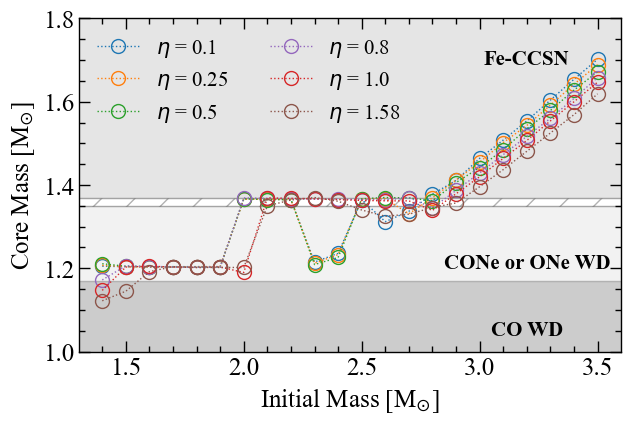

In [60]:
make_canvas(clear=True)
s1, s2, s3, s4, s5, s6 = 100, 200, 300, 400, 500, 600

fig, ax = plt.subplots()
ax.set_xlabel(r'Initial Mass [M$_{\odot}$]')
ax.set_ylabel(r'Core Mass [M$_{\odot}$]')

ax.set_xlim(1.3, 3.6)
ax.set_ylim(1.0, 1.8)

ax.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator())



# ax.scatter(init_mass_eta0p1, final_core_mass_eta0p1, marker = 'o', facecolors='none', edgecolors='blue',
#            s = s1, alpha=1.0, label = r'subset $\eta$ = 0.1')
# ax.scatter(init_mass_eta0p25, final_core_mass_eta0p25, marker = 'o', facecolors='none', edgecolors='orange',
#            s = s2,alpha=1.0, label = r'subset $\eta$ = 0.25')
# ax.scatter(init_mass_eta0p5, final_core_mass_eta0p5, marker = 'o', facecolors='none', edgecolors='green',
#            s = s3,alpha=1.0, label = r'subset $\eta$ = 0.5')
# ax.scatter(init_mass_eta0p8, final_core_mass_eta0p8, marker = 'o', facecolors='none', edgecolors='red',
#            s = s4,alpha=1.0, label = r'subset $\eta$ = 0.8')
# ax.scatter(init_mass_eta1p0, final_core_mass_eta1p0, marker = 'o', facecolors='none',  edgecolors='purple',
#            s = s5,alpha=1.0, label = r'subset $\eta$ = 1.0')
# ax.scatter(init_mass_eta1p58, final_core_mass_eta1p58, marker = 'o', facecolors='none',edgecolors='brown',
#            s = s6,alpha=1.0, label = r'subset $\eta$ = 1.58')

init_mass_eta0p1.extend(im_2)
final_core_mass_eta0p1.extend(cm_2)

plt.plot(init_mass_eta0p1, final_core_mass_eta0p1, ':o', fillstyle='none', lw=1, c='tab:blue', label = r'$\eta$ = 0.1', markersize=10)
#plt.plot(im_2, cm_2, ':o', fillstyle='none', lw=1, c='tab:blue', markersize=10)
plt.plot(init_mass_eta0p25, final_core_mass_eta0p25, ':o', fillstyle='none', lw=1, c='tab:orange', label = r'$\eta$ = 0.25', markersize=10)
plt.plot(init_mass_eta0p5, final_core_mass_eta0p5, ':o', fillstyle='none', lw=1, c='tab:green', label = r'$\eta$ = 0.5', markersize=10)
plt.plot(init_mass_eta0p8, final_core_mass_eta0p8, ':o', fillstyle='none', lw=1, c='tab:purple', label = r'$\eta$ = 0.8', markersize=10)
plt.plot(init_mass_eta1p0, final_core_mass_eta1p0, ':o', fillstyle='none', lw=1, c='tab:red', label = r'$\eta$ = 1.0', markersize=10)
plt.plot(init_mass_eta1p58, final_core_mass_eta1p58, ':o', fillstyle='none', lw=1, c='tab:brown', label = r'$\eta$ = 1.58', markersize=10)

ax.fill([0.5, 3.7, 3.7, 0.5], [0.4, 0.4, 1.17, 1.17], alpha = 0.4, color='gray')
ax.fill([0.5, 3.7, 3.7, 0.5], [1.17, 1.17, 1.35, 1.35], alpha = 0.1, color='gray')
ax.fill([0.5, 3.7, 3.7, 0.5],[1.35, 1.35, 1.37, 1.37], alpha = 0.3, color='black', hatch='/', fill=False)
ax.fill([0.5, 3.7, 3.7, 0.5], [1.37, 1.37, 2.35, 2.35], alpha = 0.2, color='gray')

ax.text(3.2, 1.05, 'CO WD', fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')
ax.text(3.2, 1.21, 'CONe or ONe WD', fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')
ax.text(3.2, 1.7, 'Fe-CCSN', fontsize = 15, horizontalalignment='center', verticalalignment='center', weight='bold')


legend = ax.legend(loc = 'upper left', ncol=2, shadow = False, frameon=False, prop={'size':15})

# plt.savefig(os.path.join(plot_results_dir, 'series2_coreGrowth.pdf'), dpi=300, bbox_inches='tight')

<Figure size 700x432.624 with 0 Axes>

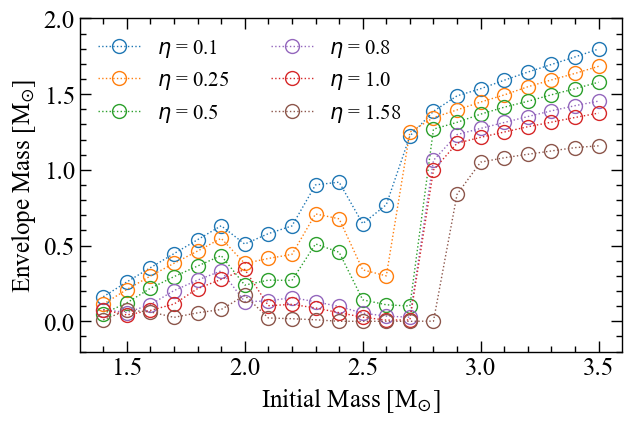

In [61]:
make_canvas(clear=True)
s=100

fig, ax = plt.subplots()
ax.set_xlabel(r'Initial Mass [M$_{\odot}$]')
ax.set_ylabel(r'Envelope Mass [M$_{\odot}$]')

ax.set_xlim(1.3, 3.6)
ax.set_ylim(-0.2, 2.0)

ax.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator())


envelope_mass_eta0p1.extend(en_2)
plt.plot(init_mass_eta0p1, envelope_mass_eta0p1, ':o', fillstyle='none', lw=1, c='tab:blue', label = r'$\eta$ = 0.1', markersize=10)
plt.plot(init_mass_eta0p25, envelope_mass_eta0p25, ':o', fillstyle='none', lw=1, c='tab:orange', label = r'$\eta$ = 0.25', markersize=10)
plt.plot(init_mass_eta0p5, envelope_mass_eta0p5, ':o', fillstyle='none', lw=1, c='tab:green', label = r'$\eta$ = 0.5', markersize=10)
plt.plot(init_mass_eta0p8, envelope_mass_eta0p8, ':o', fillstyle='none', lw=1, c='tab:purple', label = r'$\eta$ = 0.8', markersize=10)
plt.plot(init_mass_eta1p0, envelope_mass_eta1p0, ':o', fillstyle='none', lw=1, c='tab:red', label = r'$\eta$ = 1.0', markersize=10)
plt.plot(init_mass_eta1p58, envelope_mass_eta1p58, ':o', fillstyle='none', lw=1, c='tab:brown', label = r'$\eta$ = 1.58', markersize=10)

legend = ax.legend(loc = 'upper left', ncol=2, shadow = False, frameon=False, prop={'size':15})

# plt.savefig(os.path.join(plot_results_dir, 'series2_envelopeMass.pdf'), dpi=300, bbox_inches='tight')

## Kippenhahn diagrams

In [62]:
def get_burning_zones(history_paths, kipp_args, xlims = None):
    # Get burning zones and mass borders from history.data files

    xaxis_divide = kipp_args.xaxis_divide
    if kipp_args.xaxis == "star_age":
        if kipp_args.time_units == "1000 yr":
            xaxis_divide = 1000
        elif kipp_args.time_units == "Myr":
            xaxis_divide = 1e6
        elif kipp_args.time_units == "Gyr":
            xaxis_divide = 1e9

    print("Reading history data")
    burn_data = []
    histories = []
    for history_name in history_paths:
        history = mesa_data(history_name, read_data = False)
        columns = []
        for key in history.columns.keys():
            search_regex = "log_R|star_mass|model_number|star_age|.*core_mass|burn_type.*|"
            for extra_col in kipp_args.extra_history_cols:
                search_regex = search_regex + extra_col + "|"
            if kipp_args.yaxis == "radius":
                search_regex = search_regex + "burn_relr_top.*"
            else:
                search_regex = search_regex + "burn_qtop.*"
            if re.search(search_regex,key):
                columns.append(key)
        history.read_data(columns, clean_data = kipp_args.clean_data)
        histories.append(history)
    x_coords = []
    for history in histories:
        x_coords.extend(history.get(kipp_args.xaxis) / xaxis_divide)
    x_coords = kipp_args.function_on_xaxis(np.array(x_coords))
    y_coords = []
    if kipp_args.yaxis_normalize:
        y_coords = [1.0]*len(x_coords)
    elif kipp_args.yaxis == "radius":
        for history in histories:
            y_coords.extend(np.power(10,history.get('log_R')))
    else:
        for history in histories:
            y_coords.extend(history.get('star_mass'))

    print("Constructing burning regions")
    mesa_burn_zones = 0
    while True:
        try:
            mesa_burn_zones = mesa_burn_zones + 1
            burn_type = []
            burn_top = []
            for history in histories:
                burn_type.extend(history.get('burn_type_'+str(mesa_burn_zones)))
                if kipp_args.yaxis == "radius":
                     burn_top.extend(history.get('burn_relr_top_'+str(mesa_burn_zones)))
                else:
                     burn_top.extend(history.get('burn_qtop_'+str(mesa_burn_zones)))
            burn_data.append([burn_type, burn_top])
        except (Exception):
            #reached all burn zones included
            mesa_burn_zones = mesa_burn_zones - 1
            print("there are " + str(mesa_burn_zones) + " burning zones")
            break

    if kipp_args.yaxis == "radius":
        tolerance = kipp_args.radius_tolerance
    else:
        tolerance = kipp_args.mass_tolerance

    zones = []
    burn_types = []
    open_zones = []
    new_zones = []
    for i in range(1,len(x_coords)):
        current_x = x_coords[i]
        #ignore points outside of range, but include one outside each boundary
        #do not assume x_coords is in increasing order
        if xlims != None:
            if not xlims[0] <= current_x <= xlims[1]:
                if not ((i+1 < len(x_coords) and xlims[0] <= x_coords[i+1] <= xlims[1]) \
                        or (i-1 > 0 and xlims[0] <= x_coords[i-1] <= xlims[1])):
                    continue
        previous_x = x_coords[i-1]
        for j in range(0,mesa_burn_zones):
            burn_type = burn_data[j][0][i]
            if burn_type == 0 or burn_type == -1:
                continue 
            max_y_coord = burn_data[j][1][i]*y_coords[i]
            min_y_coord = 0
            if j > 0:
                min_y_coord = burn_data[j-1][1][i]*y_coords[i]
            #ignore too small regions
            if max_y_coord - min_y_coord < tolerance*y_coords[i]:
                continue
            zone_block = kipp_data.Zone_Block(previous_x, current_x, min_y_coord, max_y_coord)
            exists = False
            zones_to_merge = []
            for z in open_zones:
                if z.extend(zone_block.vertices[1], zone_block.vertices[1].prev_vertex, burn_type):
                    exists = True
                    z.new_blocks.append(zone_block)
                    zones_to_merge.append(z)
            #merge zones as needed
            for k in range(1,len(zones_to_merge)):
                zones_to_merge[0].merge_zone(zones_to_merge[k])
                open_zones.remove(zones_to_merge[k])
            #create zone if it has no predecesor
            if not exists:
                z = kipp_data.Zone(zone_block, burn_type)
                new_zones.append(z)
        open_zones.extend(new_zones)
        new_zones = []
        #separate zones which didn't continue here so we don't need to check them all the time
        for z in open_zones:
            z.switch_new_blocks()
        for z in open_zones:
            if len(z.last_blocks) == 0:
                zones.append(z.get_path())
                burn_types.append(z.mix_type)
                open_zones.remove(z)
        #order zones
        temp_open_zones = []
        while(len(open_zones)>0):
            min_y = -1
            j = -1
            for i, zone in enumerate(open_zones):
                for block in zone.last_blocks:
                    if block.vertices[0].coords[1] < min_y or min_y < 0:
                        min_y = block.vertices[0].coords[1]
                        j = i
            temp_open_zones.append(open_zones.pop(j))
        open_zones =temp_open_zones

    for z in open_zones:
        z.switch_new_blocks()
        zones.append(z.get_path())
        burn_types.append(z.mix_type)

    Burning_Zones = namedtuple('Burning_Zones', 'zones burn_types x_coords y_coords histories')
    return Burning_Zones(zones, burn_types, x_coords, y_coords, histories)

In [63]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

l = mr.MesaLogDir(os.path.join("/Volumes/SavvasExternal/aifa_models/full_grid_logfiles/2.5000_0.0200_0.0000",'LOGS'))
h = l.history

coreMassHistory = []
for idx, value in enumerate(h.data('c_core_mass')):
    if value < 1.2:
        coreMassHistory.append(value)
        
        
    else:
        #calculate core mass
        model_number = h.data('model_number')[idx]
        if l.have_profile_with_model_number(model_number):
            try:
                p = l.profile_data(model_number=model_number)
                print('Profile found and loaded!')
            except Exception as e:
                print(e)
        else:
            print('There is no profile that much the model number for Rho9!')
            print('Trying to load the nearest profile!')

            m_nums = l.model_numbers
            
            new_model_number = find_nearest(m_nums, model_number)

            try:
                p = l.profile_data(model_number=new_model_number)
                print('Nearest profile loaded!')
            except Exception as e:
                print(e)
                
        Pdeg = 10 ** p.data("logP") - p.data("Pgas")
        P_ratio = p.data("Pgas") / Pdeg
        logP = p.data('logP')

        try:
            foundCoreMassWithPratio = False
            for i in range(len(P_ratio)):
                if math.isclose(P_ratio[i], 1.0, abs_tol=0.05):
                    core_boundary = p.data("mass")[i]
                    foundCoreMassWithPratio = True
        except Exception as e:
            print(e)

        if foundCoreMassWithPratio:
            print("Core mass estimated with Pratio")
        else:
            mask = 0.80 * max(p.data("logP"))
            core_boundary = p.data("mass")[np.where(logP < mask)][-1]
            print("Core mass estimated with the pressure profile")

        print('Core mass estimate: ', core_boundary)
        coreMassHistory.append(core_boundary)
        
print(len(h.data('star_age')) == len(coreMassHistory))

There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with the pressure profile
Core mass estimate:  1.232635113252001
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with the pressure profile
Core mass estimate:  1.232635113252001
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with the pressure profile
Core mass estimate:  1.232635113252001
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with the pressure profile
Core mass estimate:  1.232635113252001
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with the pressure profile
Core mass estimate:  1.232635

Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2264931261272816
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2264931261272816
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2264931261272816
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2264931261272816
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2264931261272816
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio

Core mass estimated with Pratio
Core mass estimate:  1.2264931261272816
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2264931261272816
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2264931261272816
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2264931261272816
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2264931261272816
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.

Core mass estimated with Pratio
Core mass estimate:  1.2283822464101868
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2283822464101868
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2283822464101868
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2283822464101868
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2283822464101868
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.

Core mass estimated with Pratio
Core mass estimate:  1.2299560183007758
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2299560183007758
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2299560183007758
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2299560183007758
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2299560183007758
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.

Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2314145075082927
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2314145075082927
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2314145075082927
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2314145075082927
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2314145075082927
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio

Core mass estimated with Pratio
Core mass estimate:  1.2314145075082927
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2314145075082927
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2314145075082927
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2314145075082927
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2314145075082927
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.

Core mass estimated with Pratio
Core mass estimate:  1.2327547837261217
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2327547837261217
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2327547837261217
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2327547837261217
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2327547837261217
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.

Core mass estimated with Pratio
Core mass estimate:  1.2340778306428337
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2340778306428337
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2340778306428337
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2340778306428337
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2340778306428337
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.

Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2368038728634645
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2368038728634645
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2368038728634645
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2368038728634645
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2368038728634645
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio

Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2368900496931445
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2368900496931445
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2368900496931445
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2368900496931445
Profile found and loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2368900496931445
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2368900496931445
There is no profile that much the model number for

Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2373457391569878
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2373457391569878
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2373457391569878
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2373457391569878
Profile found and loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2373457391569878
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2373457391569878
There is no profile that much the model number for

Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2377170248786336
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2377170248786336
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2377170248786336
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2377170248786336
Profile found and loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2377170248786336
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2377170248786336
There is no profile that much the model number for

Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.238742717206608
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.238742717206608
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.238742717206608
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.238742717206608
Profile found and loaded!
Core mass estimated with Pratio
Core mass estimate:  1.238742717206608
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.238742717206608
There is no profile that much the model number for Rho9!

Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2396320250750492
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2396320250750492
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2396320250750492
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2396320250750492
Profile found and loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2396320250750492
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2396320250750492
There is no profile that much the model number for

Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2404565824138751
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2404565824138751
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2404565824138751
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2404565824138751
Profile found and loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2404565824138751
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2404565824138751
There is no profile that much the model number for

Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.241313371737715
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.241313371737715
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.241313371737715
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.241313371737715
Profile found and loaded!
Core mass estimated with Pratio
Core mass estimate:  1.241313371737715
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.241313371737715
There is no profile that much the model number for Rho9!

Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2423267048214512
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2423267048214512
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2423267048214512
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2423267048214512
Profile found and loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2423267048214512
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2423267048214512
There is no profile that much the model number for

Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2469548484051245
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2469548484051245
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2469548484051245
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2469548484051245
Profile found and loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2469548484051245
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2469548484051245
There is no profile that much the model number for

Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2752187912887147
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2752187912887147
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2752187912887147
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2752187912887147
Profile found and loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2752187912887147
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.2752187912887147
There is no profile that much the model number for

Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.305566145794621
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.305566145794621
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.305566145794621
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.305566145794621
Profile found and loaded!
Core mass estimated with Pratio
Core mass estimate:  1.305566145794621
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.305566145794621
There is no profile that much the model number for Rho9!

Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3322079439087413
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3322079439087413
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3322079439087413
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3322079439087413
Profile found and loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3322079439087413
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3322079439087413
There is no profile that much the model number for

Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3505403129460376
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3505403129460376
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3505403129460376
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3505403129460376
Profile found and loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3505403129460376
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3505403129460376
There is no profile that much the model number for

Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3599317886531468
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3599317886531468
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3599317886531468
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3599317886531468
Profile found and loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3599317886531468
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3599317886531468
There is no profile that much the model number for

Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3629277847791064
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3629277847791064
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3629277847791064
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3629277847791064
Profile found and loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3629277847791064
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3629277847791064
There is no profile that much the model number for

Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3629308970531773
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3629308970531773
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3629308970531773
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3629308970531773
Profile found and loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3629308970531773
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3629308970531773
There is no profile that much the model number for

Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3629308970531775
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3629308970531775
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3629308970531775
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3629308970531775
Profile found and loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3629308970531775
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.3629308970531775
There is no profile that much the model number for

Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.362946458423496
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.362946458423496
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.362946458423496
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.362946458423496
Profile found and loaded!
Core mass estimated with Pratio
Core mass estimate:  1.362946458423496
There is no profile that much the model number for Rho9!
Trying to load the nearest profile!
Nearest profile loaded!
Core mass estimated with Pratio
Core mass estimate:  1.362946458423496
There is no profile that much the model number for Rho9!

/Volumes/SavvasExternal/aifa_models/full_grid_logfiles/2.5000_0.0200_0.0000/LOGS ['/Volumes/SavvasExternal/aifa_models/full_grid_logfiles/2.5000_0.0200_0.0000/LOGS']
/Volumes/SavvasExternal/aifa_models/full_grid_logfiles/2.5000_0.0200_0.0000/LOGS ['/Volumes/SavvasExternal/aifa_models/full_grid_logfiles/2.5000_0.0200_0.0000/LOGS']
Reading profile data
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coo

Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are 

Text(2.5, 2.3, '')

<Figure size 700x432.624 with 0 Axes>

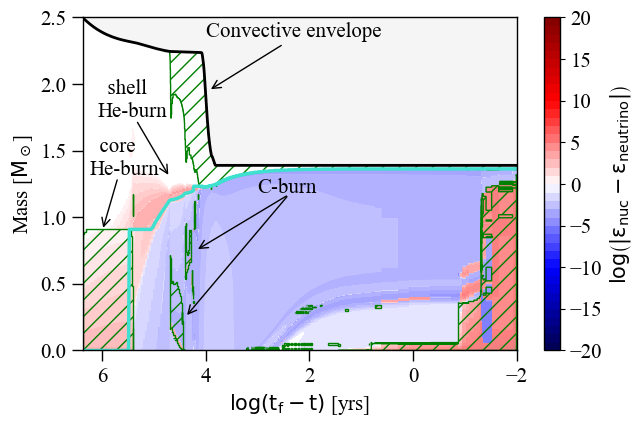

In [64]:
# Kipp diagram vs remaining time of evolution
remaining_time_func = lambda x: np.log10(max_age+0.01 - x)

mapa = 'seismic'

path = '/Volumes/SavvasExternal/aifa_models/full_grid_logfiles/2.5000_0.0200_0.0000'
log_directory = os.path.join(path, 'LOGS')
history_file = os.path.join(log_directory, 'history.data')

history = mesa_data(history_file, read_data_cols = ["star_mass", "star_age"])
max_mass = max(history.get("star_mass"))
max_age = max(history.get("star_age"))
min_age = min(history.get("star_age"))

mini, maxi = (-20,20)
step = 1
# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = range(mini,maxi+step,step)
CS3 = plt.contourf(Z, levels, cmap=mapa)
plt.clf()
profile_paths = get_profile_paths([log_directory])
# if data is distributed among several history.data files, you can provide them
history_paths = [history_file]


# Arguments for plotter
# Mass vs remaining time
kipp_args = mkipp.Kipp_Args(
    logs_dirs = [log_directory],
    contour_colormap = mapa,
    xaxis = "star_age",
    time_units = "yr",
    function_on_xaxis = remaining_time_func,
    yaxis = "mass",
    # show_conv = True, 
    # show_therm = True, 
    # show_semi = False, 
    # show_over = False, 
    # show_rot = False,
    core_masses = ["total"],
    decorate_plot = False
)



xaxis_divide = kipp_args.xaxis_divide
if kipp_args.xaxis == "star_age":
    if kipp_args.time_units == "1000 yr":
        xaxis_divide = 1000
    elif kipp_args.time_units == "Myr":
        xaxis_divide = 1e6
    elif kipp_args.time_units == "Gyr":
        xaxis_divide = 1e9



# Canvas
golden_ratio = (np.sqrt(5.0) - 1.0) / 2.0
fig_width = 7.0
fig_height = fig_width * golden_ratio
fontsize = 15

params = {
    'font.family': 'sans-serif',
    'font.sans-serif' : ['Times New Roman'],
    'font.size' : fontsize,
    "figure.figsize":[fig_width, fig_height],
    'axes.labelsize' : fontsize,
    'axes.titlesize' : fontsize,
    'xtick.labelsize' : fontsize,
    'ytick.labelsize' : fontsize,
    'legend.fontsize' : fontsize,
    'axes.linewidth' : 1,
    'lines.linewidth' : 2.5
}
plt.rcParams.update(params)

fig = plt.figure()
axis = plt.gca()
colormapper = plt.get_cmap(mapa)

axis.tick_params(direction='out', which='major', axis='both', length=8, width=1, top=False, right=False)
axis.yaxis.set_major_locator(plt.MaxNLocator(6))

# Plotting burning zones
xyz_data = kipp_data.get_xyz_data(profile_paths, kipp_args)
burning_zones = get_burning_zones(history_paths, kipp_args, xlims = xyz_data.xlims)
for i,zone in enumerate(burning_zones.zones):
    color = ""
    x = (float(burning_zones.burn_types[i])+20.0)/40.0
    if x>1:
        x=0.9999999999
    if x<0:
        x=0
    color = colormapper(x)

    axis.add_patch(PathPatch(zone, color=color, alpha = 0.5, lw = 0))


# Plotting mixing zones
mixing_zones = kipp_data.get_mixing_zones(history_paths, kipp_args, xlims = xyz_data.xlims)
for i,zone in enumerate(mixing_zones.zones):
    color = ""
    # Convective mixing
    if mixing_zones.mix_types[i] == 1: #convection
        color = "green"
        hatch = "//"
        line  = 1
    # Overshooting 
    elif mixing_zones.mix_types[i] == 3: #overshooting
        color = "purple"
        hatch = "x"
        line  = 1
    # Semiconvective mixing
    # elif mixing_zones.mix_types[i] == 4: #semiconvection
        # color = '#f28123'
    # elif mixing_zones.mix_types[i] == 5: #thermohaline
        # color = '#ffc132'
    # elif mixing_zones.mix_types[i] == 6: #rotational mixing
        # color = '#087e8b'

    else:
        continue

    axis.add_patch(PathPatch(zone, fill=False, hatch = hatch, edgecolor=color, linewidth=line))




for i, x_coord in enumerate(mixing_zones.x_coords):
        if x_coord > xyz_data.xlims[1]:
            break

# I also fill with white above the plot to cover any remainer of the contour plot
axis.fill_between(mixing_zones.x_coords, max(mixing_zones.y_coords), mixing_zones.y_coords, color = "whitesmoke")
axis.plot(mixing_zones.x_coords[:i], mixing_zones.y_coords[:i], "k-")

# add core masses
if kipp_args.yaxis == "mass":
    for core_mass in kipp_args.core_masses:
        if core_mass == "He":
            field_name = "he_core_mass"
            color = "b:"
        elif core_mass == "C":
            field_name = "c_core_mass"
            color = "r:"
        elif core_mass == "O":
            field_name = "o_core_mass"
            color = "g:"
        elif core_mass == "total":
            field_name = "star_mass"
            color = "k"
            line = 2
        for history in mixing_zones.histories:
            axis.plot(kipp_args.function_on_xaxis(history.get(kipp_args.xaxis) / xaxis_divide), \
                    history.get(field_name), color, linewidth=line)

# CO core    
axis.plot(remaining_time_func(h.data("star_age")), coreMassHistory, color='turquoise', linewidth=2.5)
# axis.plot(remaining_time_func(h.data("star_age")), h.data('c_core_mass'), color='magenta', linewidth=2.5)

# Colorbar
bar = plt.colorbar(CS3)
bar.set_label(r"$\rm \log \left( |\epsilon_{\rm nuc} - \epsilon_{\rm neutrino}| \right)$")
axis.set_xlabel(r"$\rm \log (t_f-t)$ [yrs]")
axis.set_ylabel(r"Mass [$\rm M_\odot$]")
axis.set_xlim([remaining_time_func(max_age), remaining_time_func(min_age)])
axis.set_ylim([0.0, max_mass])


plt.gca().invert_xaxis()




# Annotate regions
text1 = '  core' + '\n' + 'He-burn'
text2 = '  shell' + '\n' + 'He-burn'
text3 = 'C-burn'
text4 = 'Convective envelope'


plt.text(6.25, 1.32, text1, fontsize='medium')
plt.annotate("",
            xy=(6.0, 0.9),
            xytext=(5.7, 1.3),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.text(6.1, 1.75, text2, fontsize='medium')
plt.annotate("",
            xy=(4.7, 1.3),
            xytext=(5.35, 1.73),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.text(3.0, 1.18, text3, fontsize='medium')
plt.annotate("",
            xy=(4.4, 0.25),
            xytext=(2.4, 1.17),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )
plt.annotate("",
            xy=(4.2, 0.75),
            xytext=(2.4, 1.17),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.text(4.0, 2.35, text4, fontsize='medium')
plt.annotate("",
            xy=(3.95, 1.95),
            xytext=(2.5, 2.3),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )



# plt.savefig(os.path.join(plot_results_dir, 'new_kipps_net/remaining_time/series1_rt_2p5M_z0p02_f0.png'), dpi=300, bbox_inches='tight')

/Volumes/SavvasExternal/aifa_models/full_grid_logfiles/2.5000_0.0200_0.0000/LOGS ['/Volumes/SavvasExternal/aifa_models/full_grid_logfiles/2.5000_0.0200_0.0000/LOGS']
/Volumes/SavvasExternal/aifa_models/full_grid_logfiles/2.5000_0.0200_0.0000/LOGS ['/Volumes/SavvasExternal/aifa_models/full_grid_logfiles/2.5000_0.0200_0.0000/LOGS']
Reading profile data
Reading history data
Constructing mixing regions
there are 40 mixing zones
Reading profile data
Reading history data
Constructing burning regions
there are 80 burning zones
Reading history data
Constructing mixing regions
there are 40 mixing zones


(0.0, 2.5)

<Figure size 700x432.624 with 0 Axes>

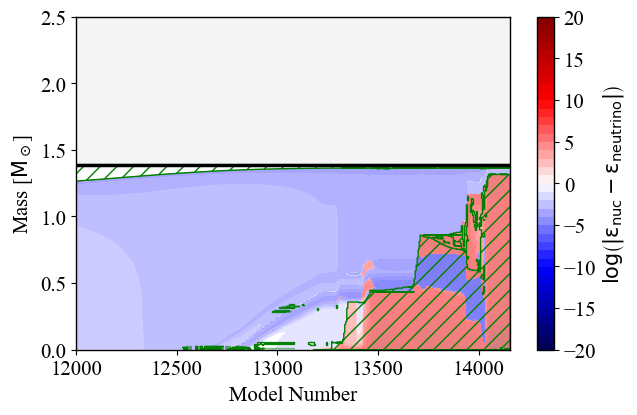

In [65]:
# Kipp diagran vs model number

mapa = 'seismic'

history = mesa_data(history_file, read_data_cols = ["star_mass", "model_number"])
max_mass = max(history.get("star_mass"))
max_model = max(history.get("model_number"))
min_model = min(history.get("model_number"))

mini, maxi = (-20,20)
step = 1
# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = range(mini,maxi+step,step)
CS3 = plt.contourf(Z, levels, cmap=mapa)
plt.clf()
profile_paths = get_profile_paths([log_directory])
# if data is distributed among several history.data files, you can provide them
history_paths = [history_file]



# Arguments for plotter
# Mass vs model number
kipp_args = mkipp.Kipp_Args(
    logs_dirs = [log_directory],
    contour_colormap = mapa,
    xaxis = "model_number",
    function_on_xaxis = lambda x: x,
    yaxis = "mass",
    # show_conv = True, 
    # show_therm = True, 
    # show_semi = False, 
    # show_over = False, 
    # show_rot = False,
    core_masses = ["total"],
    decorate_plot = False
)



xaxis_divide = kipp_args.xaxis_divide
if kipp_args.xaxis == "star_age":
    if kipp_args.time_units == "1000 yr":
        xaxis_divide = 1000
    elif kipp_args.time_units == "Myr":
        xaxis_divide = 1e6
    elif kipp_args.time_units == "Gyr":
        xaxis_divide = 1e9
        
        
        
# Canvas
golden_ratio = (np.sqrt(5.0) - 1.0) / 2.0
fig_width = 7.0
fig_height = fig_width * golden_ratio
fontsize = 15

params = {
    'font.family': 'sans-serif',
    'font.sans-serif' : ['Times New Roman'],
    'font.size' : fontsize,
    "figure.figsize":[fig_width, fig_height],
    'axes.labelsize' : fontsize,
    'axes.titlesize' : fontsize,
    'xtick.labelsize' : fontsize,
    'ytick.labelsize' : fontsize,
    'legend.fontsize' : fontsize,
    'axes.linewidth' : 1,
    'lines.linewidth' : 2.5
}
plt.rcParams.update(params)

fig = plt.figure()
axis = plt.gca()
colormapper = plt.get_cmap(mapa)



# Plotting burning zones
xyz_data = kipp_data.get_xyz_data(profile_paths, kipp_args)
burning_zones = get_burning_zones(history_paths, kipp_args, xlims = xyz_data.xlims)
for i,zone in enumerate(burning_zones.zones):
    color = ""
    x = (float(burning_zones.burn_types[i])+20.0)/40.0
    if x>1:
        x=0.9999999999
    if x<0:
        x=0
    color = colormapper(x)

    axis.add_patch(PathPatch(zone, color=color, alpha = 0.5, lw = 0))
    
    
mixing_zones = kipp_data.get_mixing_zones(history_paths, kipp_args, xlims = xyz_data.xlims)
for i,zone in enumerate(mixing_zones.zones):
    color = ""
    # Convective mixing
    if mixing_zones.mix_types[i] == 1: #convection
        color = "green"
        hatch = "//"
        line  = 1
    # Overshooting 
    elif mixing_zones.mix_types[i] == 3: #overshooting
        color = "purple"
        hatch = "x"
        line  = 1
    # Semiconvective mixing
    # elif mixing_zones.mix_types[i] == 4: #semiconvection
        # color = '#f28123'
    # elif mixing_zones.mix_types[i] == 5: #thermohaline
        # color = '#ffc132'
    # elif mixing_zones.mix_types[i] == 6: #rotational mixing
        # color = '#087e8b'

    else:
        continue

    axis.add_patch(PathPatch(zone, fill=False, hatch = hatch, edgecolor=color, linewidth=line))
    
    
for i, x_coord in enumerate(mixing_zones.x_coords):
        if x_coord > xyz_data.xlims[1]:
            break
            
# I also fill with white above the plot to cover any remainer of the contour plot
axis.fill_between(mixing_zones.x_coords, max(mixing_zones.y_coords)+5.0, mixing_zones.y_coords, color = "whitesmoke")
axis.plot(mixing_zones.x_coords[:i], mixing_zones.y_coords[:i], "k-")

# add core masses
if kipp_args.yaxis == "mass":
    for core_mass in kipp_args.core_masses:
        if core_mass == "He":
            field_name = "he_core_mass"
            color = "b:"
        elif core_mass == "C":
            field_name = "c_core_mass"
            color = "r:"
        elif core_mass == "O":
            field_name = "o_core_mass"
            color = "g:"
        elif core_mass == "total":
            field_name = "star_mass"
            color = "k"
            line = 2
        for history in mixing_zones.histories:
            axis.plot(kipp_args.function_on_xaxis(history.get(kipp_args.xaxis) / xaxis_divide), \
                    history.get(field_name), color, linewidth=line)
    
    


# Colorbar
bar = plt.colorbar(CS3)
bar.set_label(r"$\rm \log \left( |\epsilon_{\rm nuc} - \epsilon_{neutrino}| \right)$")
axis.set_xlabel("Model Number")
axis.set_ylabel(r"Mass [$\rm M_\odot$]")


# axis.set_xlim([min_model, max_model])
axis.set_xlim([12000, max_model])
axis.set_ylim([0.0, 2.5])



# plt.axvline(11955, c='b', ls='--') # 1st Urca
# plt.axvline(12800, c='b', ls='--') # 2nd Urca
# plt.axvline(13299, c='b', ls='--') # end Urca
# plt.axvline(13300, c='b', ls='--') # Mg24 e-captures

# plt.axvline(26740, c='b', ls='--') # simmering
# plt.axvline(27075, c='b', ls='--') # carbon burning
# plt.axvline(21450, c='b', ls='--') # end carbon burning
# plt.axvline(24245, c='b', ls='--') # oxygen burning



# plt.text(21875, 2.1, text_urca, fontsize = 12, horizontalalignment='center', verticalalignment='center')
# plt.text(22235, 2.1, text_cburn, fontsize = 12, horizontalalignment='center', verticalalignment='center')
# plt.text(22565, 2.1, text_oburn, fontsize = 12, horizontalalignment='center', verticalalignment='center')

# plt.annotate("",
#             xy=(27500, 1.9),
#             xytext=(26500, 2.1),
#             arrowprops=dict(arrowstyle="->",
#                             connectionstyle="arc3"),
#             )



# plt.savefig(os.path.join(plot_results_dir, 'new_kipps_net/model_number/series1_mn_2p5M_z0p02_f0.png'), dpi=300, bbox_inches='tight')

## Abundance profiles

[None, None, None, None, None, None, None, None, None, None, None, None, None]

<Figure size 800x800 with 0 Axes>

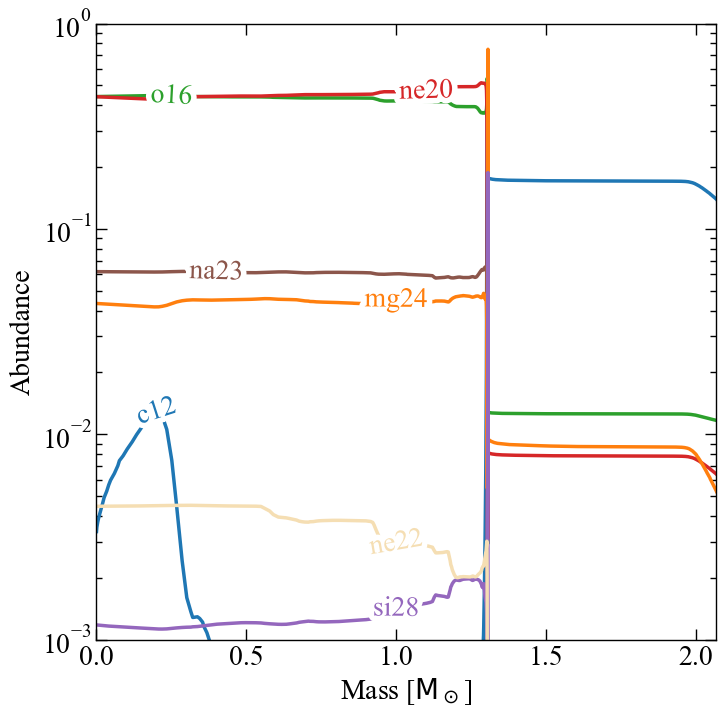

In [66]:
# l = mr.MesaLogDir(os.path.join(main_dir_aifa_grid, '2.5000_0.0200_0.0000/LOGS'))
l = mr.MesaLogDir('/Volumes/SavvasExternal/zsol_eta0p8/2.7000_0.0200_0.8000/LOGS')
# l = mr.MesaLogDir('/Volumes/SavvasExternal/aifa_models/carbon_free/2.5000_0.0200_0.0000/LOGS')

p = l.profile_data(3000).data

make_canvas(fig_width=8, fig_height=8, clear=True, fontsize=20)
fig, ax = plt.subplots()

ax.set_yscale('log')
ax.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)

ax.set_ylim([0.001, 1.0])
ax.set_xlim([0.0, p('mass')[0]])

ax.set_xlabel(r'Mass [$\rm M_\odot$]')
ax.set_ylabel('Abundance')


# ax.plot(p('mass'),p('he4'), label='he4', c='k')

ax.plot(p('mass'),p('c12'), label='c12', c='tab:blue')

ax.plot(p('mass'),p('o16'), label='o16', c='tab:green')
ax.plot(p('mass'),p('o20'), label='o20', c='tab:cyan')

ax.plot(p('mass'),p('ne20'), label='ne20', c='tab:red')
ax.plot(p('mass'),p('ne23'), label='ne23', c='coral')
ax.plot(p('mass'),p('ne24'), label='ne24', c='mediumseagreen')

ax.plot(p('mass'),p('na23'), label='na23', c='tab:brown')
ax.plot(p('mass'),p('na24'), label='na24', c='tab:gray')
# ax.plot(p('mass'),p('na25'), label='na25', c='lavender')

ax.plot(p('mass'),p('mg24'), label='mg24', c='tab:orange')
ax.plot(p('mass'),p('mg25'), label='mg25', c='tab:pink')

ax.plot(p('mass'),p('al27'), label='al27', c='tab:olive')

ax.plot(p('mass'),p('si28'), label='si28', c='tab:purple')

ax.plot(p('mass'),p('ne22'), label='ne22', c='wheat')

xvals = [0.2, 0.25, 0.15, 1.1, 0.45, 0.5, 0.4, 0.45, 1.0, 1.3, 0.8, 1.0, 1.0]
# xvals = [0.3, 1.5, 1.5, 0.45, 0.55, 0.3, 0.6, 1.5, 0.2, 0.8, 0.2, 0.2]
labelLines(ax.get_lines(), drop_label=True, outline_width=8, xvals=xvals)



# plt.savefig('/Users/schanlar/Desktop/appendix_plots/2p7_eta0p8_final_abun.pdf', dpi=300, bbox_inches='tight')

## Electron-to-baryon ratio

In [67]:
def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )

<Figure size 700x432.624 with 0 Axes>

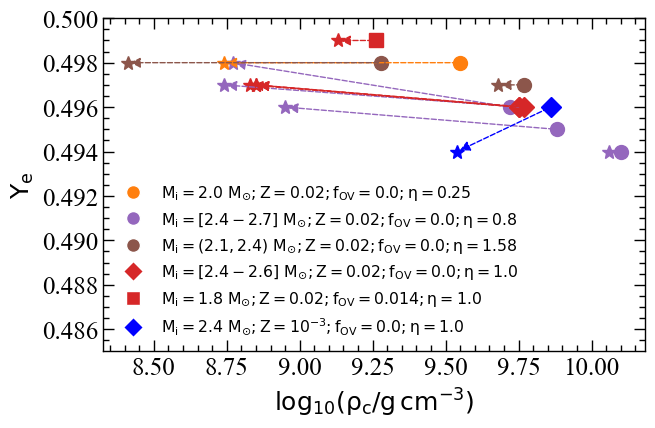

In [68]:
from matplotlib.lines import Line2D
s=10
arrow_size = 15
arrow_color = 'k'
make_canvas(clear=True)

fig, ax = plt.subplots()
ax.set_xlabel(r'$\rm \log_{10}(\rho_{\rm c} / g\,cm^{-3})$')
ax.set_ylabel(r'$\rm Y_e$')

# ax.set_xlim(1.35, 3.6)
# # ax.set_ylim(-0.03, 0.45)
ax.set_ylim(0.485, 0.5)

ax.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_major_locator(plt.MaxNLocator(8))
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.plot([9.72, 9.76, 9.88, 10.1],[0.496, 0.496, 0.495, 0.494], marker='o', c='tab:purple', ls='', fillstyle='full', markersize=s)
ax.plot([8.77, 8.74, 8.95, 10.06], [0.498, 0.497, 0.496, 0.494], marker='*', c='tab:purple', ls='', fillstyle='full', markersize=s)

ax.annotate('', xytext=(9.72, 0.496), xy=(8.77, 0.498), arrowprops=dict(arrowstyle='-|>', linestyle="--", color='tab:purple'),size=arrow_size)
ax.annotate('', xytext=(9.76, 0.496), xy=(8.74, 0.497), arrowprops=dict(arrowstyle='-|>', linestyle="--", color='tab:purple'),size=arrow_size)
ax.annotate('', xytext=(9.88, 0.495), xy=(8.95, 0.496), arrowprops=dict(arrowstyle='-|>', linestyle="--", color='tab:purple'),size=arrow_size)
ax.annotate('', xytext=(10.1, 0.494), xy=(10.06, 0.494), arrowprops=dict(arrowstyle='-|>', linestyle="--", color='tab:purple'),size=arrow_size)


ax.plot([9.55],[0.498], marker='o', c='tab:orange', ls='', fillstyle='full', markersize=s)
ax.plot([8.74],[0.498], marker='*', c='tab:orange', ls='', fillstyle='full', markersize=s)

ax.annotate('', xytext=(9.55, 0.498), xy=(8.74, 0.498), arrowprops=dict(arrowstyle='-|>', linestyle="--", color='tab:orange'),size=arrow_size)


ax.plot([9.28, 9.77],[0.498, 0.497], marker='o', c='tab:brown', ls='', fillstyle='full', markersize=s)
ax.plot([8.41, 9.68],[0.498, 0.497], marker='*', c='tab:brown', ls='', fillstyle='full', markersize=s)

ax.annotate('', xytext=(9.28, 0.498), xy=(8.41, 0.498), arrowprops=dict(arrowstyle='-|>', linestyle="--", color='tab:brown'),size=arrow_size)
ax.annotate('', xytext=(9.77, 0.497), xy=(9.68, 0.497), arrowprops=dict(arrowstyle='-|>', linestyle="--", color='tab:brown'),size=arrow_size)

ax.plot([9.75, 9.75, 9.77],[0.496, 0.496, 0.496], marker='D', c='tab:red', ls='', fillstyle='full', markersize=s)
ax.plot([8.83, 8.85, 8.85],[0.497, 0.497, 0.497], marker='*', c='tab:red', ls='', fillstyle='full', markersize=s)

ax.annotate('', xytext=(9.75, 0.496), xy=(8.83, 0.497), arrowprops=dict(arrowstyle='-|>', linestyle="--", color='tab:red'),size=arrow_size)
ax.annotate('', xytext=(9.75, 0.496), xy=(8.85, 0.497), arrowprops=dict(arrowstyle='-|>', linestyle="--", color='tab:red'),size=arrow_size)
ax.annotate('', xytext=(9.77, 0.496), xy=(8.85, 0.497), arrowprops=dict(arrowstyle='-|>', linestyle="--", color='tab:red'),size=arrow_size)

ax.plot([9.26],[0.499], marker='s', c='tab:red', ls='', fillstyle='full', markersize=s)
ax.plot([9.13],[0.499], marker='*', c='tab:red', ls='', fillstyle='full', markersize=s)

ax.annotate('', xytext=(9.26, 0.499), xy=(9.13, 0.499), arrowprops=dict(arrowstyle='-|>', linestyle="--", color='tab:red'),size=arrow_size)

ax.plot([9.86],[0.496], marker='D', c='blue', ls='', fillstyle='full', markersize=s)
ax.plot([9.54],[0.494], marker='*', c='blue', ls='', fillstyle='full', markersize=s)

ax.annotate('', xytext=(9.86, 0.496), xy=(9.54, 0.494), arrowprops=dict(arrowstyle='-|>', linestyle="--", color='blue'),size=arrow_size)

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:orange', label=r'$\rm M_i=2.0\ M_{\odot};Z=0.02;f_{\rm OV}=0.0; \eta=0.25$', markersize=s),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:purple', label=r'$\rm M_i=[2.4 - 2.7]\ M_{\odot};Z=0.02;f_{\rm OV}=0.0; \eta=0.8$', markersize=s),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:brown', label=r'$\rm M_i=(2.1, 2.4)\ M_{\odot};Z=0.02;f_{\rm OV}=0.0; \eta=1.58$', markersize=s),
                   Line2D([0], [0], marker='D', color='w', markerfacecolor='tab:red', label=r'$\rm M_i=[2.4 - 2.6]\ M_{\odot};Z=0.02;f_{\rm OV}=0.0; \eta=1.0$', markersize=s),
                   Line2D([0], [0], marker='s', color='w', markerfacecolor='tab:red', label=r'$\rm M_i=1.8\ M_{\odot};Z=0.02;f_{\rm OV}=0.014; \eta=1.0$', markersize=s),
                   Line2D([0], [0], marker='D', color='w', markerfacecolor='blue', label=r'$\rm M_i=2.4\ M_{\odot};Z=10^{-3};f_{\rm OV}=0.0; \eta=1.0$', markersize=s),
                   ]

ax.legend(handles=legend_elements, loc='lower left', prop={'size':11.3}, frameon=False, ncol=1) 

# plt.savefig('/Users/schanlar/Desktop/asdf/final_figures_draft/ye_rho.pdf', dpi=300, bbox_inches = 'tight')

In [69]:
Ebin = [-5.52380437,
        -5.71441195,
        -5.69553922,
        -5.9374213,
        -6.18315736,
        -5.73634507,
        -5.65646589,
        -5.75274483,
        -5.1292877,
        -5.53602195,
        -5.16115249,
        -5.67498779
]

Ye = [0.498,
      0.496,
      0.496,
      0.495,
      0.494,
      0.496,
      0.496,
      0.496,
      0.498,
      0.497,
      0.499,
      0.496   
]

colors =['tab:orange',
         'tab:purple',
         'tab:purple',
         'tab:purple',
         'tab:purple',
         'red',
         'red',
         'red',
         'tab:brown',
         'tab:brown',
         'red',
         'blue'
          
]

markers = ['o',
          'o',
          'o',
          'o',
          'o',
          'D',
          'D',
          'D',
          'o',
          'o',
          's',
          'D'
          
    
]

<Figure size 700x432.624 with 0 Axes>

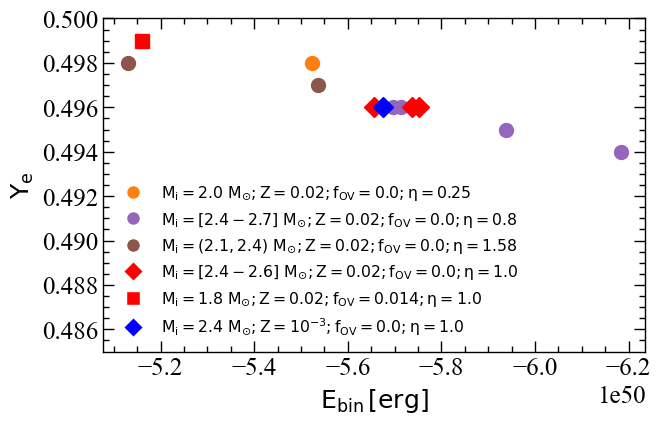

In [70]:
s=10
make_canvas(clear=True)


fig, ax = plt.subplots()
ax.set_xlabel(r'$\rm E_{\rm bin}\,[erg]$')
ax.set_ylabel(r'$\rm Y_e$')

#ax.set_xlim(0.7, 3.6)
ax.set_ylim(0.485, 0.5)

ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_major_locator(plt.MaxNLocator(8))
ax.yaxis.set_minor_locator(AutoMinorLocator())

# ax.plot(Ebin, Ye, markersize=s, marker='x', ls='')

for i,j,c,m in zip([energy*(10**(50)) for energy in Ebin], Ye, colors, markers):
    ax.plot(i,j, ls='', marker=m, markersize=s, c=c)
    
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:orange', label=r'$\rm M_i=2.0\ M_{\odot};Z=0.02;f_{\rm OV}=0.0; \eta=0.25$', markersize=s),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:purple', label=r'$\rm M_i=[2.4 - 2.7]\ M_{\odot};Z=0.02;f_{\rm OV}=0.0; \eta=0.8$', markersize=s),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:brown', label=r'$\rm M_i=(2.1, 2.4)\ M_{\odot};Z=0.02;f_{\rm OV}=0.0; \eta=1.58$', markersize=s),
                   Line2D([0], [0], marker='D', color='w', markerfacecolor='red', label=r'$\rm M_i=[2.4 - 2.6]\ M_{\odot};Z=0.02;f_{\rm OV}=0.0; \eta=1.0$', markersize=s),
                   Line2D([0], [0], marker='s', color='w', markerfacecolor='red', label=r'$\rm M_i=1.8\ M_{\odot};Z=0.02;f_{\rm OV}=0.014; \eta=1.0$', markersize=s),
                   Line2D([0], [0], marker='D', color='w', markerfacecolor='blue', label=r'$\rm M_i=2.4\ M_{\odot};Z=10^{-3};f_{\rm OV}=0.0; \eta=1.0$', markersize=s),
                   ]

ax.legend(handles=legend_elements, loc='lower left', prop={'size':11.3}, frameon=False) 
ax.invert_xaxis()
# plt.savefig('/Users/schanlar/Desktop/asdf/final_figures_draft/ye_ebin.pdf', dpi=300, bbox_inches='tight')